<a href="https://colab.research.google.com/github/gbiamgaurav/ML-Use-Cases/blob/main/SubmarineSonarMinevsRock.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Setup**

## **Install Libraries**

In [ ]:
pip install ucimlrepo

## **Load Libraries**

In [ ]:
# Import All Libraries

# GENERAL
import sys
from packaging import version
import uuid

# DATA
import numpy as np
import pandas as pd

# Data Repository
from ucimlrepo import fetch_ucirepo

# VISULISATION
import seaborn as sns
import matplotlib.pyplot as plt

# MACHINE LEARNING

# Scikitlearn
import sklearn
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier, BaggingClassifier
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, roc_auc_score, roc_curve, precision_recall_curve, confusion_matrix, auc, \
                            log_loss, accuracy_score, make_scorer, average_precision_score
from sklearn.base import clone


# STATISTICS
from scipy.signal import find_peaks
from scipy.stats import boxcox

# XGBoost
import xgboost as xgb
from xgboost import XGBClassifier

# HYPERPARAMETER TUNNING
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK

# Fundamental algorithms for scientific computing in Python
# Savitzky-Golay filter
from scipy.signal import savgol_filter


In [ ]:
# Manage Versions

assert sys.version_info >= (3, 7)
assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

## **Build Constants**

In [ ]:
#Constants

# Test Ratio = 15%
TEST_PORTION = 0.15

# Random State
RANDOM_STATE = 42

# Target Column
TARGET_COL =  'class'

# Number of Cross Validation Folds

NR_FOLDS = 10


## **Load All Functions**

In [ ]:
def load_data_from_uci():

  '''Go to UC Irvine Machine Learning reposity and find the Data Set you like
  https://archive.ics.uci.edu/dataset/151/connectionist+bench+sonar+mines+vs+rocks and then use Import
  in Python button and then Copy the Python Code into your Notebook
  to Load the Data
  '''

  # fetch dataset
  sonar_mines_vs_rocks = fetch_ucirepo(id=151)

  # data (as pandas dataframes)
  input_features = sonar_mines_vs_rocks.data.features
  target_feature = sonar_mines_vs_rocks.data.targets
  metadata = sonar_mines_vs_rocks.data.metadata
  variables_info = sonar_mines_vs_rocks.data.variables
  return input_features, target_feature, metadata, variables_info


def understand_data(data_frame):
    """

    Args:
    data_frame: The Input Dataframe

    Returns:
    The concanation of type of each column number of NAs in a column
    count of categories for categorical columns and 0 for numerical columns in a DataFrame
    """

    data_type = pd.DataFrame(data_frame.dtypes, columns = ['Type']).T
    data_na = pd.DataFrame(data_frame.isna().sum(), columns = ['Nr_NAs']).T
    category_info = pd.DataFrame(data_frame.apply(lambda col: col.nunique() if col.dtype == 'object' or col.dtype.name == 'category' else 0), columns = ['Category_Info']).T
    data_frame_info = pd.concat([data_type, data_na, category_info], axis = 0)

    return data_frame_info

def make_x_y(Xy, target_col, drop_col):
  """

  Args:
    Xy:
    target_col:

  Returns:

  """
  Xy = Xy.drop(columns = drop_col)
  X = Xy.drop(columns = [target_col])
  y = Xy[target_col]
  return X,y

# **Data Understanding**

## **1. Load Data**

In [ ]:
# Load Data
input_features, target_feature, metadata, variables_info = load_data_from_uci()

## **2. Findings about Data**

In [ ]:
input_features

Attribute1  Attribute2  Attribute3  Attribute4  Attribute5  Attribute6  \
0        0.0200      0.0371      0.0428      0.0207      0.0954      0.0986   
1        0.0453      0.0523      0.0843      0.0689      0.1183      0.2583   
2        0.0262      0.0582      0.1099      0.1083      0.0974      0.2280   
3        0.0100      0.0171      0.0623      0.0205      0.0205      0.0368   
4        0.0762      0.0666      0.0481      0.0394      0.0590      0.0649   
..          ...         ...         ...         ...         ...         ...   
203      0.0187      0.0346      0.0168      0.0177      0.0393      0.1630   
204      0.0323      0.0101      0.0298      0.0564      0.0760      0.0958   
205      0.0522      0.0437      0.0180      0.0292      0.0351      0.1171   
206      0.0303      0.0353      0.0490      0.0608      0.0167      0.1354   
207      0.0260      0.0363      0.0136      0.0272      0.0214      0.0338   

     Attribute7  Attribute8  Attribute9  Attribute10  ...  Attribute51  \
0        0.1539      0.1601      0.3109       0.2111  ...       0.0232   
1        0.2156      0.3481      0.3337       0.2872  ...       0.0125   
2        0.2431      0.3771      0.5598       0.6194  ...       0.0033   
3        0.1098      0.1276      0.0598       0.1264  ...       0.0241   
4        0.1209      0.2467      0.3564       0.4459  ...       0.0156   
..          ...         ...         ...          ...  ...          ...   
203      0.2028      0.1694      0.2328       0.2684  ...       0.0203   
204      0.0990      0.1018      0.1030       0.2154  ...       0.0051   
205      0.1257      0.1178      0.1258       0.2529  ...       0.0155   
206      0.1465      0.1123      0.1945       0.2354  ...       0.0042   
207      0.0655      0.1400      0.1843       0.2354  ...       0.0181   

     Attribute52  Attribute53  Attribute54  Attribute55  Attribute56  \
0         0.0027       0.0065       0.0159       0.0072       0.0167   
1         0.0084       0.0089       0.0048       0.0094       0.0191   
2         0.0232       0.0166       0.0095       0.0180       0.0244   
3         0.0121       0.0036       0.0150       0.0085       0.0073   
4         0.0031       0.0054       0.0105       0.0110       0.0015   
..           ...          ...          ...          ...          ...   
203       0.0116       0.0098       0.0199       0.0033       0.0101   
204       0.0061       0.0093       0.0135       0.0063       0.0063   
205       0.0160       0.0029       0.0051       0.0062       0.0089   
206       0.0086       0.0046       0.0126       0.0036       0.0035   
207       0.0146       0.0129       0.0047       0.0039       0.0061   

     Attribute57  Attribute58  Attribute59  Attribute60  
0         0.0180       0.0084       0.0090       0.0032  
1         0.0140       0.0049       0.0052       0.0044  
2         0.0316       0.0164       0.0095       0.0078  
3         0.0050       0.0044       0.0040       0.0117  
4         0.0072       0.0048       0.0107       0.0094  
..           ...          ...          ...          ...  
203       0.0065       0.0115       0.0193       0.0157  
204       0.0034       0.0032       0.0062       0.0067  
205       0.0140       0.0138       0.0077       0.0031  
206       0.0034       0.0079       0.0036       0.0048  
207       0.0040       0.0036       0.0061       0.0115  

[208 rows x 60 columns]

In [ ]:
input_features.shape

(208, 60)

In [ ]:
target_feature

class
0       R
1       R
2       R
3       R
4       R
..    ...
203     M
204     M
205     M
206     M
207     M

[208 rows x 1 columns]

In [ ]:
target_feature.value_counts(normalize = True)

class
M        0.533654
R        0.466346
Name: proportion, dtype: float64

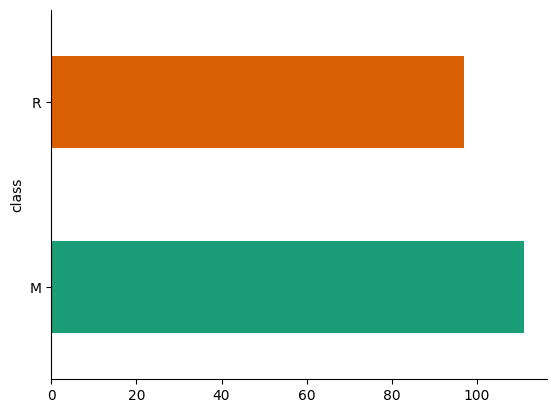

In [ ]:
target_feature.groupby('class').size()\
.plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

Color maps:
https://seaborn.pydata.org/generated/seaborn.mpl_palette.html

In [ ]:
print(metadata, variables_info)

None None


### **Summary statistics for the features**

In [ ]:
input_features.describe().T

count      mean       std     min       25%      50%       75%  \
Attribute1   208.0  0.029164  0.022991  0.0015  0.013350  0.02280  0.035550   
Attribute2   208.0  0.038437  0.032960  0.0006  0.016450  0.03080  0.047950   
Attribute3   208.0  0.043832  0.038428  0.0015  0.018950  0.03430  0.057950   
Attribute4   208.0  0.053892  0.046528  0.0058  0.024375  0.04405  0.064500   
Attribute5   208.0  0.075202  0.055552  0.0067  0.038050  0.06250  0.100275   
Attribute6   208.0  0.104570  0.059105  0.0102  0.067025  0.09215  0.134125   
Attribute7   208.0  0.121747  0.061788  0.0033  0.080900  0.10695  0.154000   
Attribute8   208.0  0.134799  0.085152  0.0055  0.080425  0.11210  0.169600   
Attribute9   208.0  0.178003  0.118387  0.0075  0.097025  0.15225  0.233425   
Attribute10  208.0  0.208259  0.134416  0.0113  0.111275  0.18240  0.268700   
Attribute11  208.0  0.236013  0.132705  0.0289  0.129250  0.22480  0.301650   
Attribute12  208.0  0.250221  0.140072  0.0236  0.133475  0.24905  0.331250   
Attribute13  208.0  0.273305  0.140962  0.0184  0.166125  0.26395  0.351250   
Attribute14  208.0  0.296568  0.164474  0.0273  0.175175  0.28110  0.386175   
Attribute15  208.0  0.320201  0.205427  0.0031  0.164625  0.28170  0.452925   
Attribute16  208.0  0.378487  0.232650  0.0162  0.196300  0.30470  0.535725   
Attribute17  208.0  0.415983  0.263677  0.0349  0.205850  0.30840  0.659425   
Attribute18  208.0  0.452318  0.261529  0.0375  0.242075  0.36830  0.679050   
Attribute19  208.0  0.504812  0.257988  0.0494  0.299075  0.43495  0.731400   
Attribute20  208.0  0.563047  0.262653  0.0656  0.350625  0.54250  0.809325   
Attribute21  208.0  0.609060  0.257818  0.0512  0.399725  0.61770  0.816975   
Attribute22  208.0  0.624275  0.255883  0.0219  0.406925  0.66490  0.831975   
Attribute23  208.0  0.646975  0.250175  0.0563  0.450225  0.69970  0.848575   
Attribute24  208.0  0.672654  0.239116  0.0239  0.540725  0.69850  0.872175   
Attribute25  208.0  0.675424  0.244926  0.0240  0.525800  0.72110  0.873725   
Attribute26  208.0  0.699866  0.237228  0.0921  0.544175  0.75450  0.893800   
Attribute27  208.0  0.702155  0.245657  0.0481  0.531900  0.74560  0.917100   
Attribute28  208.0  0.694024  0.237189  0.0284  0.534775  0.73190  0.900275   
Attribute29  208.0  0.642074  0.240250  0.0144  0.463700  0.68080  0.852125   
Attribute30  208.0  0.580928  0.220749  0.0613  0.411400  0.60715  0.735175   
Attribute31  208.0  0.504475  0.213992  0.0482  0.345550  0.49035  0.641950   
Attribute32  208.0  0.439040  0.213237  0.0404  0.281400  0.42960  0.580300   
Attribute33  208.0  0.417220  0.206513  0.0477  0.257875  0.39120  0.556125   
Attribute34  208.0  0.403233  0.231242  0.0212  0.217575  0.35105  0.596125   
Attribute35  208.0  0.392571  0.259132  0.0223  0.179375  0.31275  0.593350   
Attribute36  208.0  0.384848  0.264121  0.0080  0.154350  0.32115  0.556525   
Attribute37  208.0  0.363807  0.239912  0.0351  0.160100  0.30630  0.518900   
Attribute38  208.0  0.339657  0.212973  0.0383  0.174275  0.31270  0.440550   
Attribute39  208.0  0.325800  0.199075  0.0371  0.173975  0.28350  0.434900   
Attribute40  208.0  0.311207  0.178662  0.0117  0.186450  0.27805  0.424350   
Attribute41  208.0  0.289252  0.171111  0.0360  0.163100  0.25950  0.387525   
Attribute42  208.0  0.278293  0.168728  0.0056  0.158900  0.24510  0.384250   
Attribute43  208.0  0.246542  0.138993  0.0000  0.155200  0.22255  0.324525   
Attribute44  208.0  0.214075  0.133291  0.0000  0.126875  0.17770  0.271750   
Attribute45  208.0  0.197232  0.151628  0.0000  0.094475  0.14800  0.231550   
Attribute46  208.0  0.160631  0.133938  0.0000  0.068550  0.12135  0.200375   
Attribute47  208.0  0.122453  0.086953  0.0000  0.064250  0.10165  0.154425   
Attribute48  208.0  0.091424  0.062417  0.0000  0.045125  0.07810  0.120100   
Attribute49  208.0  0.051929  0.035954  0.0000  0.026350  0.04470  0.068525   
Attribute50  208.0  0.020424  0.013665  0.0000  0.011550  0.017

In [ ]:
input_features.describe().T[['mean', 'std', 'max']]

mean       std     max
Attribute1   0.029164  0.022991  0.1371
Attribute2   0.038437  0.032960  0.2339
Attribute3   0.043832  0.038428  0.3059
Attribute4   0.053892  0.046528  0.4264
Attribute5   0.075202  0.055552  0.4010
Attribute6   0.104570  0.059105  0.3823
Attribute7   0.121747  0.061788  0.3729
Attribute8   0.134799  0.085152  0.4590
Attribute9   0.178003  0.118387  0.6828
Attribute10  0.208259  0.134416  0.7106
Attribute11  0.236013  0.132705  0.7342
Attribute12  0.250221  0.140072  0.7060
Attribute13  0.273305  0.140962  0.7131
Attribute14  0.296568  0.164474  0.9970
Attribute15  0.320201  0.205427  1.0000
Attribute16  0.378487  0.232650  0.9988
Attribute17  0.415983  0.263677  1.0000
Attribute18  0.452318  0.261529  1.0000
Attribute19  0.504812  0.257988  1.0000
Attribute20  0.563047  0.262653  1.0000
Attribute21  0.609060  0.257818  1.0000
Attribute22  0.624275  0.255883  1.0000
Attribute23  0.646975  0.250175  1.0000
Attribute24  0.672654  0.239116  1.0000
Attribute25  0.675424  0.244926  1.0000
Attribute26  0.699866  0.237228  1.0000
Attribute27  0.702155  0.245657  1.0000
Attribute28  0.694024  0.237189  1.0000
Attribute29  0.642074  0.240250  1.0000
Attribute30  0.580928  0.220749  1.0000
Attribute31  0.504475  0.213992  0.9657
Attribute32  0.439040  0.213237  0.9306
Attribute33  0.417220  0.206513  1.0000
Attribute34  0.403233  0.231242  0.9647
Attribute35  0.392571  0.259132  1.0000
Attribute36  0.384848  0.264121  1.0000
Attribute37  0.363807  0.239912  0.9497
Attribute38  0.339657  0.212973  1.0000
Attribute39  0.325800  0.199075  0.9857
Attribute40  0.311207  0.178662  0.9297
Attribute41  0.289252  0.171111  0.8995
Attribute42  0.278293  0.168728  0.8246
Attribute43  0.246542  0.138993  0.7733
Attribute44  0.214075  0.133291  0.7762
Attribute45  0.197232  0.151628  0.7034
Attribute46  0.160631  0.133938  0.7292
Attribute47  0.122453  0.086953  0.5522
Attribute48  0.091424  0.062417  0.3339
Attribute49  0.051929  0.035954  0.1981
Attribute50  0.020424  0.013665  0.0825
Attribute51  0.016069  0.012008  0.1004
Attribute52  0.013420  0.009634  0.0709
Attribute53  0.010709  0.007060  0.0390
Attribute54  0.010941  0.007301  0.0352
Attribute55  0.009290  0.007088  0.0447
Attribute56  0.008222  0.005736  0.0394
Attribute57  0.007820  0.005785  0.0355
Attribute58  0.007949  0.006470  0.0440
Attribute59  0.007941  0.006181  0.0364
Attribute60  0.006507  0.005031  0.0439

In [ ]:
def understand_data(data_frame):
    """

    Args:
    data_frame: The Input Dataframe

    Returns:
    The concanation of type of each column number of NAs in a column
    count of categories for categorical columns and 0 for numerical columns in a DataFrame
    """

    data_type = pd.DataFrame(data_frame.dtypes, columns = ['Type']).T
    data_na = pd.DataFrame(data_frame.isna().sum(), columns = ['Nr_NAs']).T
    category_info = pd.DataFrame(data_frame.apply(lambda col: col.nunique() if col.dtype == 'object' or col.dtype.name == 'category' else 0), columns = ['Category_Info']).T
    data_frame_info = pd.concat([data_type, data_na, category_info], axis = 0)

    return data_frame_info

understand_data(input_features)

Attribute1 Attribute2 Attribute3 Attribute4 Attribute5  \
Type             float64    float64    float64    float64    float64   
Nr_NAs                 0          0          0          0          0   
Category_Info          0          0          0          0          0   

              Attribute6 Attribute7 Attribute8 Attribute9 Attribute10  ...  \
Type             float64    float64    float64    float64     float64  ...   
Nr_NAs                 0          0          0          0           0  ...   
Category_Info          0          0          0          0           0  ...   

              Attribute51 Attribute52 Attribute53 Attribute54 Attribute55  \
Type              float64     float64     float64     float64     float64   
Nr_NAs                  0           0           0           0           0   
Category_Info           0           0           0           0           0   

              Attribute56 Attribute57 Attribute58 Attribute59 Attribute60  
Type              float64     float64     float64     float64     float64  
Nr_NAs                  0           0           0           0           0  
Category_Info           0           0           0           0           0  

[3 rows x 60 columns]

In [ ]:
understand_data(target_feature)

class
Type           object
Nr_NAs              0
Category_Info       2

In [ ]:
Xy = pd.concat([input_features, target_feature], axis = 1)

In [ ]:
Xy

Attribute1  Attribute2  Attribute3  Attribute4  Attribute5  Attribute6  \
0        0.0200      0.0371      0.0428      0.0207      0.0954      0.0986   
1        0.0453      0.0523      0.0843      0.0689      0.1183      0.2583   
2        0.0262      0.0582      0.1099      0.1083      0.0974      0.2280   
3        0.0100      0.0171      0.0623      0.0205      0.0205      0.0368   
4        0.0762      0.0666      0.0481      0.0394      0.0590      0.0649   
..          ...         ...         ...         ...         ...         ...   
203      0.0187      0.0346      0.0168      0.0177      0.0393      0.1630   
204      0.0323      0.0101      0.0298      0.0564      0.0760      0.0958   
205      0.0522      0.0437      0.0180      0.0292      0.0351      0.1171   
206      0.0303      0.0353      0.0490      0.0608      0.0167      0.1354   
207      0.0260      0.0363      0.0136      0.0272      0.0214      0.0338   

     Attribute7  Attribute8  Attribute9  Attribute10  ...  Attribute52  \
0        0.1539      0.1601      0.3109       0.2111  ...       0.0027   
1        0.2156      0.3481      0.3337       0.2872  ...       0.0084   
2        0.2431      0.3771      0.5598       0.6194  ...       0.0232   
3        0.1098      0.1276      0.0598       0.1264  ...       0.0121   
4        0.1209      0.2467      0.3564       0.4459  ...       0.0031   
..          ...         ...         ...          ...  ...          ...   
203      0.2028      0.1694      0.2328       0.2684  ...       0.0116   
204      0.0990      0.1018      0.1030       0.2154  ...       0.0061   
205      0.1257      0.1178      0.1258       0.2529  ...       0.0160   
206      0.1465      0.1123      0.1945       0.2354  ...       0.0086   
207      0.0655      0.1400      0.1843       0.2354  ...       0.0146   

     Attribute53  Attribute54  Attribute55  Attribute56  Attribute57  \
0         0.0065       0.0159       0.0072       0.0167       0.0180   
1         0.0089       0.0048       0.0094       0.0191       0.0140   
2         0.0166       0.0095       0.0180       0.0244       0.0316   
3         0.0036       0.0150       0.0085       0.0073       0.0050   
4         0.0054       0.0105       0.0110       0.0015       0.0072   
..           ...          ...          ...          ...          ...   
203       0.0098       0.0199       0.0033       0.0101       0.0065   
204       0.0093       0.0135       0.0063       0.0063       0.0034   
205       0.0029       0.0051       0.0062       0.0089       0.0140   
206       0.0046       0.0126       0.0036       0.0035       0.0034   
207       0.0129       0.0047       0.0039       0.0061       0.0040   

     Attribute58  Attribute59  Attribute60  class  
0         0.0084       0.0090       0.0032      R  
1         0.0049       0.0052       0.0044      R  
2         0.0164       0.0095       0.0078      R  
3         0.0044       0.0040       0.0117      R  
4         0.0048       0.0107       0.0094      R  
..           ...          ...          ...    ...  
203       0.0115       0.0193       0.0157      M  
204       0.0032       0.0062       0.0067      M  
205       0.0138       0.0077       0.0031      M  
206       0.0079       0.0036       0.0048      M  
207       0.0036       0.0061       0.0115      M  

[208 rows x 61 columns]

In [ ]:
Xy.groupby('class').mean().T

class               M         R
Attribute1   0.034989  0.022498
Attribute2   0.045544  0.030303
Attribute3   0.050720  0.035951
Attribute4   0.064768  0.041447
Attribute5   0.086715  0.062028
Attribute6   0.111864  0.096224
Attribute7   0.128359  0.114180
Attribute8   0.149832  0.117596
Attribute9   0.213492  0.137392
Attribute10  0.251022  0.159325
Attribute11  0.289581  0.174713
Attribute12  0.301459  0.191589
Attribute13  0.314426  0.226249
Attribute14  0.320692  0.268963
Attribute15  0.331182  0.307636
Attribute16  0.380999  0.375611
Attribute17  0.415007  0.417100
Attribute18  0.455882  0.448240
Attribute19  0.538062  0.466762
Attribute20  0.617941  0.500229
Attribute21  0.667426  0.542270
Attribute22  0.672325  0.569290
Attribute23  0.676701  0.612959
Attribute24  0.689165  0.653761
Attribute25  0.681204  0.668809
Attribute26  0.706075  0.692762
Attribute27  0.714754  0.687737
Attribute28  0.712269  0.673145
Attribute29  0.650283  0.632680
Attribute30  0.581796  0.579934
Attribute31  0.482378  0.529762
Attribute32  0.428049  0.451619
Attribute33  0.396577  0.440841
Attribute34  0.366140  0.445680
Attribute35  0.337553  0.455530
Attribute36  0.318553  0.460710
Attribute37  0.317034  0.417330
Attribute38  0.331608  0.348868
Attribute39  0.336365  0.313709
Attribute40  0.305221  0.318057
Attribute41  0.292594  0.285428
Attribute42  0.300975  0.252338
Attribute43  0.276883  0.211822
Attribute44  0.248106  0.175132
Attribute45  0.245225  0.142312
Attribute46  0.198804  0.116949
Attribute47  0.146917  0.094458
Attribute48  0.110594  0.069488
Attribute49  0.063708  0.038449
Attribute50  0.022721  0.017796
Attribute51  0.019352  0.012311
Attribute52  0.016014  0.010453
Attribute53  0.011643  0.009640
Attribute54  0.012185  0.009518
Attribute55  0.009923  0.008567
Attribute56  0.008914  0.007430
Attribute57  0.007825  0.007814
Attribute58  0.009060  0.006677
Attribute59  0.008695  0.007078
Attribute60  0.006930  0.006024

# **Data Preparation**

1. Integrate Data
2. Select Data
3. Format & Clean Data
4. Construct Data


## **1. Integrate Data (Enrich Data)**

Add any External or Internal Data

## **2. Select Data**

In [ ]:
Xy = pd.concat([input_features, target_feature], axis = 1)
Xy.head(5)

Attribute1  Attribute2  Attribute3  Attribute4  Attribute5  Attribute6  \
0      0.0200      0.0371      0.0428      0.0207      0.0954      0.0986   
1      0.0453      0.0523      0.0843      0.0689      0.1183      0.2583   
2      0.0262      0.0582      0.1099      0.1083      0.0974      0.2280   
3      0.0100      0.0171      0.0623      0.0205      0.0205      0.0368   
4      0.0762      0.0666      0.0481      0.0394      0.0590      0.0649   

   Attribute7  Attribute8  Attribute9  Attribute10  ...  Attribute52  \
0      0.1539      0.1601      0.3109       0.2111  ...       0.0027   
1      0.2156      0.3481      0.3337       0.2872  ...       0.0084   
2      0.2431      0.3771      0.5598       0.6194  ...       0.0232   
3      0.1098      0.1276      0.0598       0.1264  ...       0.0121   
4      0.1209      0.2467      0.3564       0.4459  ...       0.0031   

   Attribute53  Attribute54  Attribute55  Attribute56  Attribute57  \
0       0.0065       0.0159       0.0072       0.0167       0.0180   
1       0.0089       0.0048       0.0094       0.0191       0.0140   
2       0.0166       0.0095       0.0180       0.0244       0.0316   
3       0.0036       0.0150       0.0085       0.0073       0.0050   
4       0.0054       0.0105       0.0110       0.0015       0.0072   

   Attribute58  Attribute59  Attribute60  class  
0       0.0084       0.0090       0.0032      R  
1       0.0049       0.0052       0.0044      R  
2       0.0164       0.0095       0.0078      R  
3       0.0044       0.0040       0.0117      R  
4       0.0048       0.0107       0.0094      R  

[5 rows x 61 columns]

### **2.1 Create a Unique ID**

In [ ]:
# Adding a 'uuid' column with a unique identifier for each row
Xy['uuid'] = [uuid.uuid4() for _ in range(len(Xy))]
print(f"{Xy['uuid'].nunique()} vs {Xy.shape[0]} rows")

208 vs 208 rows


In [ ]:
Xy.columns

Index(['Attribute1', 'Attribute2', 'Attribute3', 'Attribute4', 'Attribute5',
       'Attribute6', 'Attribute7', 'Attribute8', 'Attribute9', 'Attribute10',
       'Attribute11', 'Attribute12', 'Attribute13', 'Attribute14',
       'Attribute15', 'Attribute16', 'Attribute17', 'Attribute18',
       'Attribute19', 'Attribute20', 'Attribute21', 'Attribute22',
       'Attribute23', 'Attribute24', 'Attribute25', 'Attribute26',
       'Attribute27', 'Attribute28', 'Attribute29', 'Attribute30',
       'Attribute31', 'Attribute32', 'Attribute33', 'Attribute34',
       'Attribute35', 'Attribute36', 'Attribute37', 'Attribute38',
       'Attribute39', 'Attribute40', 'Attribute41', 'Attribute42',
       'Attribute43', 'Attribute44', 'Attribute45', 'Attribute46',
       'Attribute47', 'Attribute48', 'Attribute49', 'Attribute50',
       'Attribute51', 'Attribute52', 'Attribute53', 'Attribute54',
       'Attribute55', 'Attribute56', 'Attribute57', 'Attribute58',
       'Attribute59', 'Attribute60', 'cla

### **2.2 Create a Test Set**

In [ ]:
Train_Xy, Test_Xy = train_test_split(Xy,
                                     test_size = TEST_PORTION,
                                     stratify=Xy[TARGET_COL],
                                     random_state = RANDOM_STATE)

print(f"\nSize of Train Set is: {Train_Xy.shape[0]} \
rows ({100-100*TEST_PORTION}% of Data)\n\n\
Size of Test Set is: {Test_Xy.shape[0]}\
rows ({100*TEST_PORTION}% of Data)")


Size of Train Set is: 176 rows (85.0% of Data)

Size of Test Set is: 32rows (15.0% of Data)


In [ ]:
Train_Xy['class'].value_counts(normalize = True)

class
M    0.534091
R    0.465909
Name: proportion, dtype: float64

## **3. Format & Clean Data**

### **3.1 Understand Data**

In [ ]:
understand_data(Train_Xy)

Attribute1 Attribute2 Attribute3 Attribute4 Attribute5  \
Type             float64    float64    float64    float64    float64   
Nr_NAs                 0          0          0          0          0   
Category_Info          0          0          0          0          0   

              Attribute6 Attribute7 Attribute8 Attribute9 Attribute10  ...  \
Type             float64    float64    float64    float64     float64  ...   
Nr_NAs                 0          0          0          0           0  ...   
Category_Info          0          0          0          0           0  ...   

              Attribute53 Attribute54 Attribute55 Attribute56 Attribute57  \
Type              float64     float64     float64     float64     float64   
Nr_NAs                  0           0           0           0           0   
Category_Info           0           0           0           0           0   

              Attribute58 Attribute59 Attribute60   class    uuid  
Type              float64     float64     float64  object  object  
Nr_NAs                  0           0           0       0       0  
Category_Info           0           0           0       2     176  

[3 rows x 62 columns]

In [ ]:
Train_Xy.columns

Index(['Attribute1', 'Attribute2', 'Attribute3', 'Attribute4', 'Attribute5',
       'Attribute6', 'Attribute7', 'Attribute8', 'Attribute9', 'Attribute10',
       'Attribute11', 'Attribute12', 'Attribute13', 'Attribute14',
       'Attribute15', 'Attribute16', 'Attribute17', 'Attribute18',
       'Attribute19', 'Attribute20', 'Attribute21', 'Attribute22',
       'Attribute23', 'Attribute24', 'Attribute25', 'Attribute26',
       'Attribute27', 'Attribute28', 'Attribute29', 'Attribute30',
       'Attribute31', 'Attribute32', 'Attribute33', 'Attribute34',
       'Attribute35', 'Attribute36', 'Attribute37', 'Attribute38',
       'Attribute39', 'Attribute40', 'Attribute41', 'Attribute42',
       'Attribute43', 'Attribute44', 'Attribute45', 'Attribute46',
       'Attribute47', 'Attribute48', 'Attribute49', 'Attribute50',
       'Attribute51', 'Attribute52', 'Attribute53', 'Attribute54',
       'Attribute55', 'Attribute56', 'Attribute57', 'Attribute58',
       'Attribute59', 'Attribute60', 'cla

### **3.2 Columns**

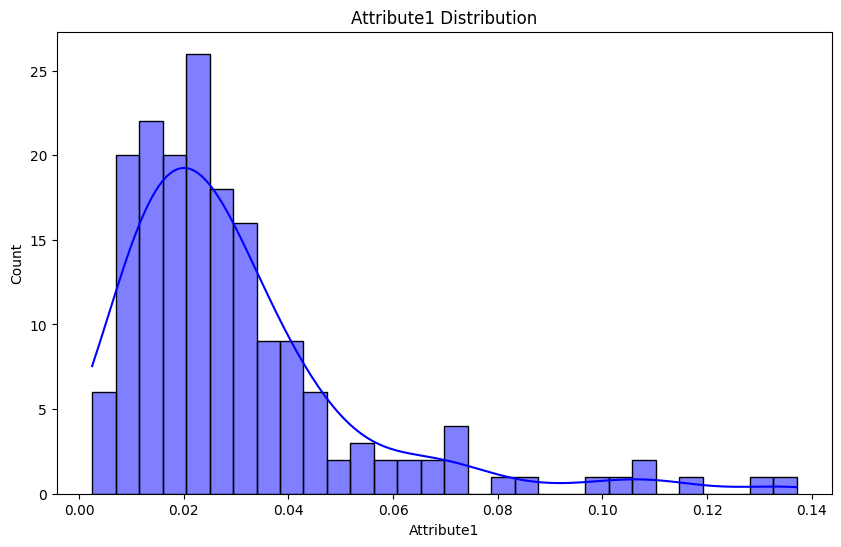

In [ ]:
# Plotting the distribution of age
col_name = 'Attribute1'
plt.figure(figsize=(10, 6))
sns.histplot(Train_Xy[col_name], bins=30, kde=True, color='blue')
plt.title(col_name+' Distribution')
plt.xlabel(col_name)
plt.ylabel('Count')
plt.show()

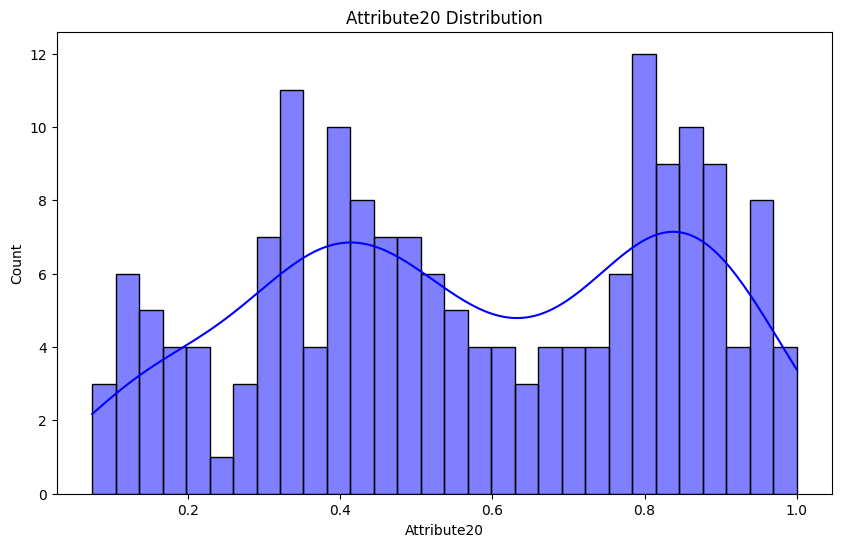

In [ ]:
# Plotting the distribution of age
col_name = 'Attribute20'
plt.figure(figsize=(10, 6))
sns.histplot(Train_Xy[col_name], bins=30, kde=True, color='blue')
plt.title(col_name+' Distribution')
plt.xlabel(col_name)
plt.ylabel('Count')
plt.show()

A KDE plot is a smooth curve that represents the distribution of data and is an estimate of the probability density function of the variable. It provides a way to visualize the underlying distribution shape of the data, offering a smoothed alternative to the histogram's bins.

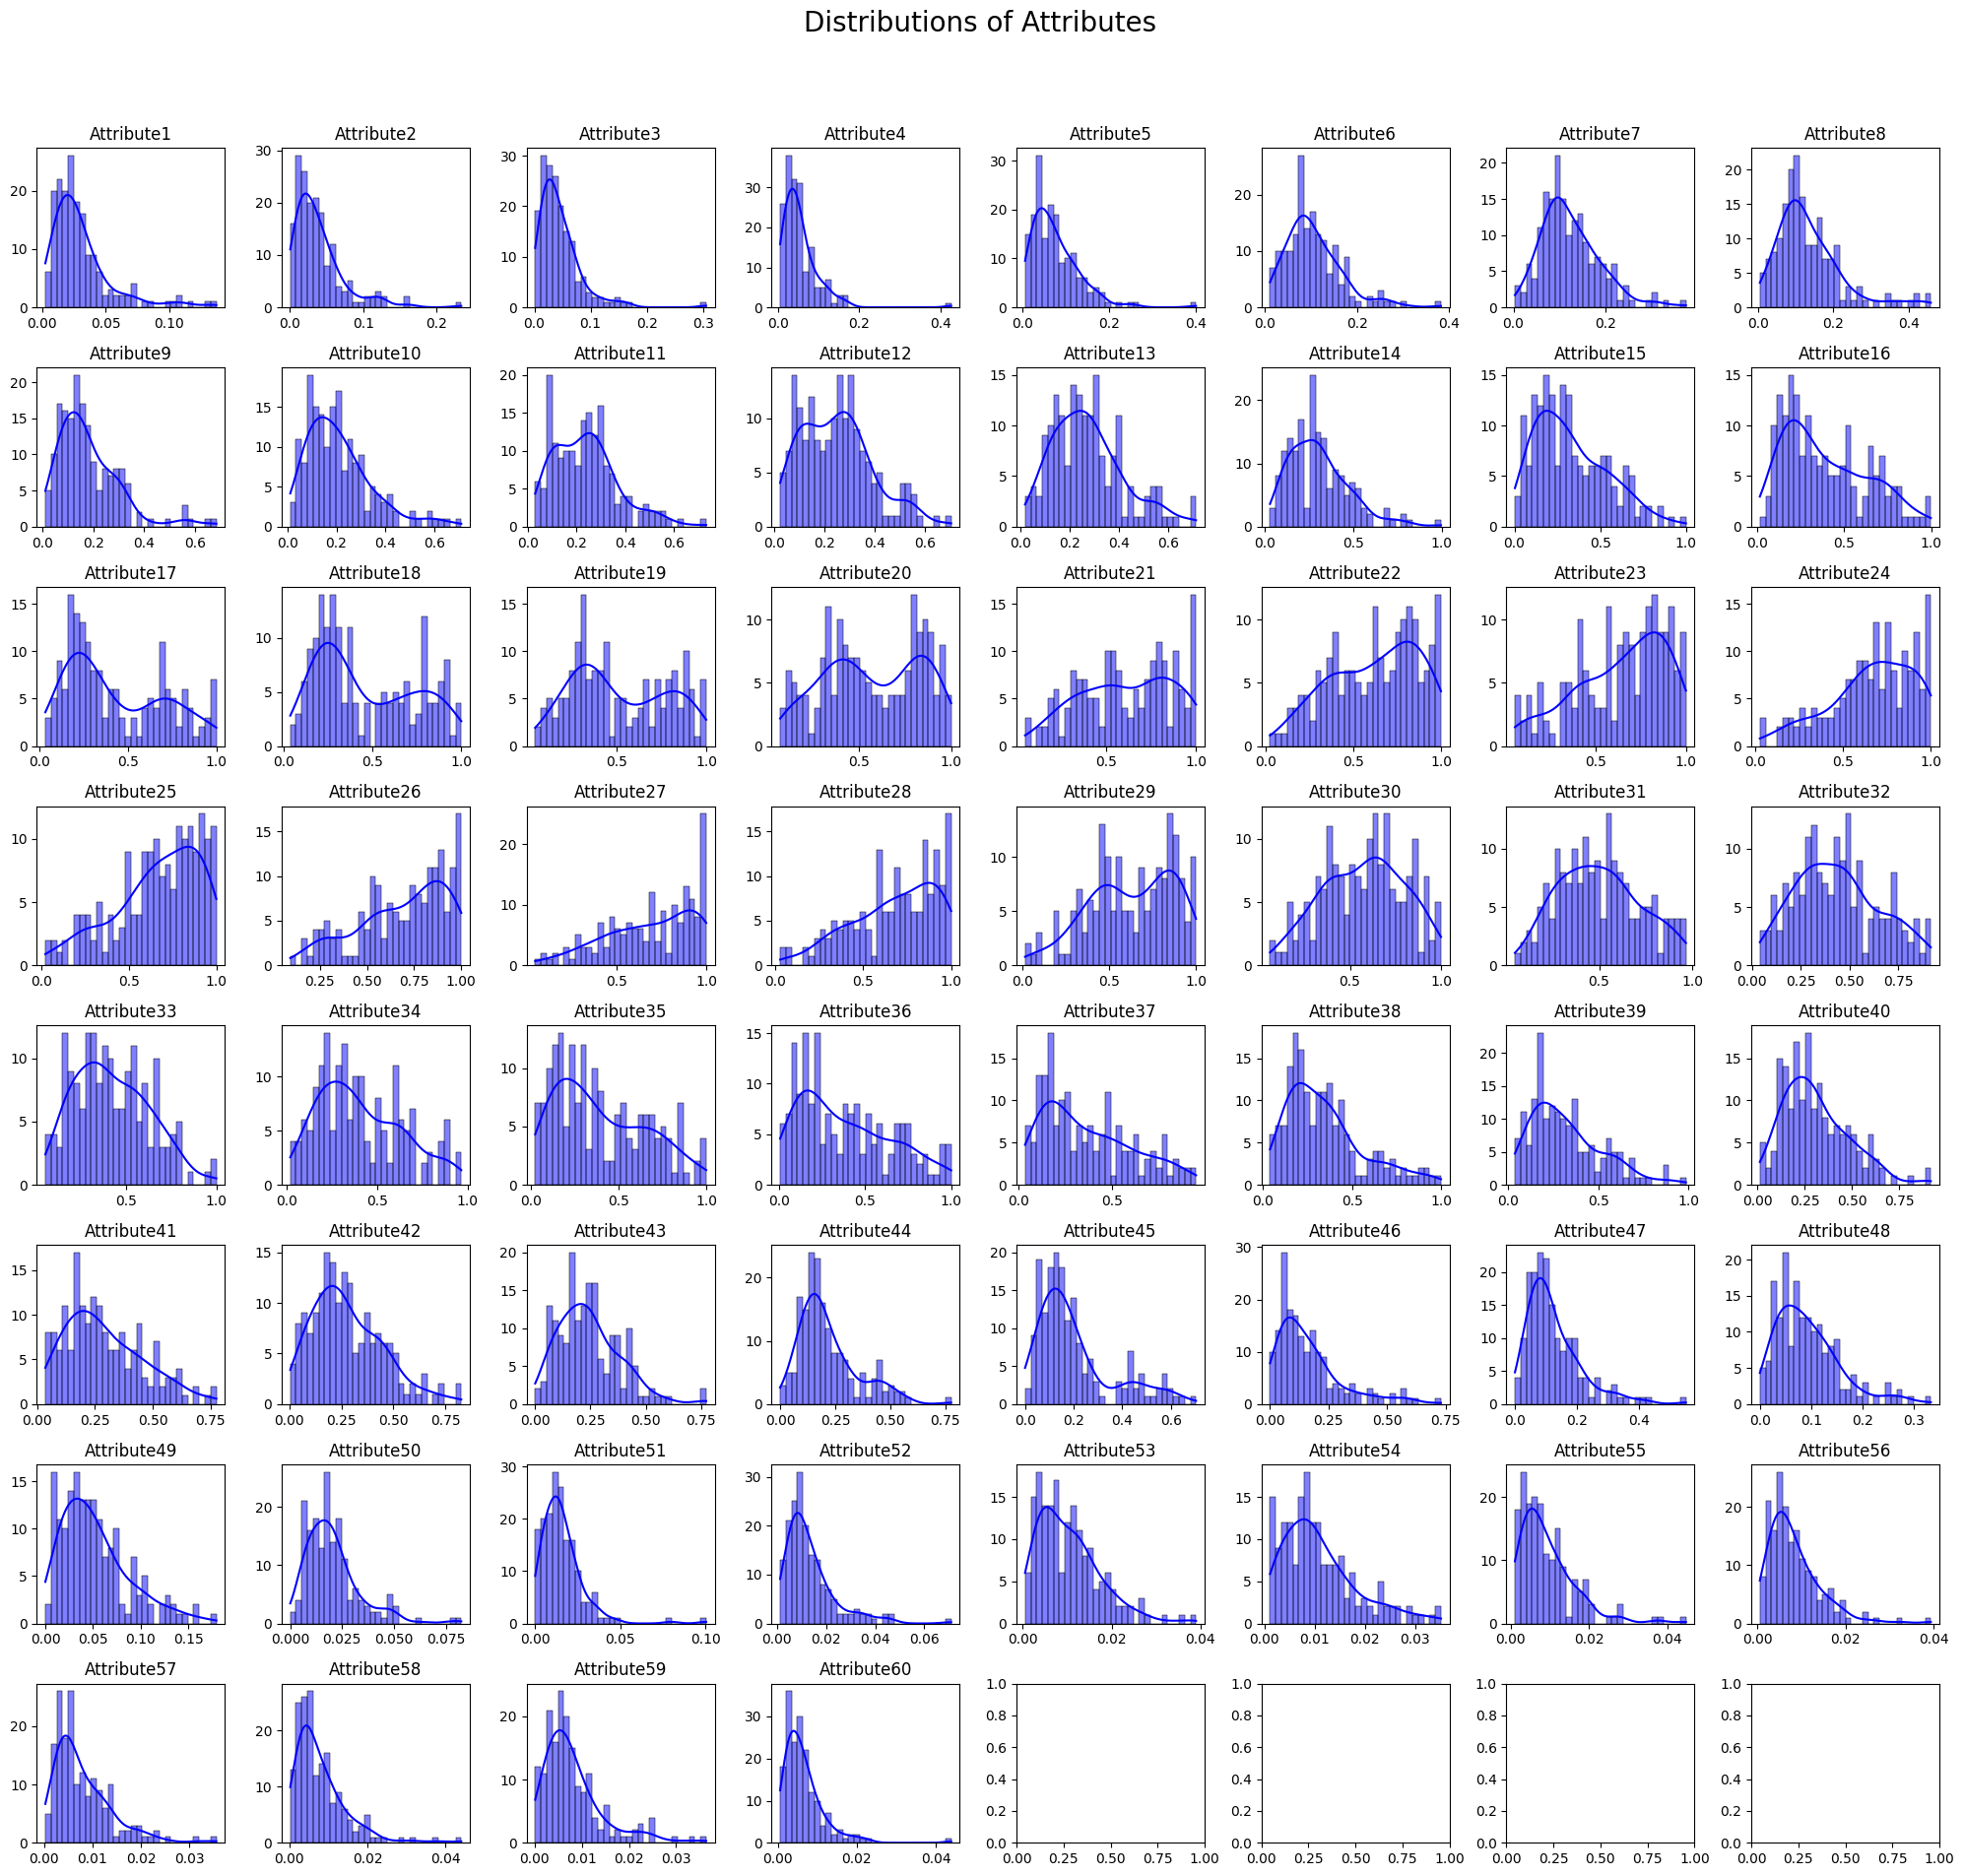

In [ ]:
columns = [f'Attribute{i}' for i in range(1, 61)]

# Set up the matplotlib figure with 8x8 subplots
fig, axes = plt.subplots(8, 8, figsize=(20, 20))
fig.suptitle('Distributions of Attributes', fontsize=20)

# Plot each attribute in a separate subplot
for i, column in enumerate(columns):
    row = i // 8
    col = i % 8
    sns.histplot(Train_Xy[column], bins=30, kde=True, color='blue', ax=axes[row, col])
    axes[row, col].set_title(column)
    axes[row, col].set_xlabel('')
    axes[row, col].set_ylabel('')

# Adjust layout
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# **Feature Engineering**

* Feature Creation
* Tansformation
* Encoding
* Scaling

## **1. Generate X and y**

In [ ]:
# Determine X and y
Train_X, Train_y = make_x_y(Xy = Train_Xy, target_col = TARGET_COL, drop_col = ['uuid'])
Test_X, Test_y = make_x_y(Xy = Test_Xy, target_col = TARGET_COL, drop_col = ['uuid'])

In [ ]:
Train_X.head()

Attribute1  Attribute2  Attribute3  Attribute4  Attribute5  Attribute6  \
38       0.0123      0.0022      0.0196      0.0206      0.0180      0.0492   
115      0.0414      0.0436      0.0447      0.0844      0.0419      0.1215   
161      0.0305      0.0363      0.0214      0.0227      0.0456      0.0665   
5        0.0286      0.0453      0.0277      0.0174      0.0384      0.0990   
122      0.0249      0.0119      0.0277      0.0760      0.1218      0.1538   

     Attribute7  Attribute8  Attribute9  Attribute10  ...  Attribute51  \
38       0.0033      0.0398      0.0791       0.0475  ...       0.0149   
115      0.2002      0.1516      0.0818       0.1975  ...       0.0222   
161      0.0939      0.0972      0.2535       0.3127  ...       0.0271   
5        0.1201      0.1833      0.2105       0.3039  ...       0.0104   
122      0.1192      0.1229      0.2119       0.2531  ...       0.0140   

     Attribute52  Attribute53  Attribute54  Attribute55  Attribute56  \
38        0.0125       0.0134       0.0026       0.0038       0.0018   
115       0.0045       0.0136       0.0113       0.0053       0.0165   
161       0.0200       0.0070       0.0070       0.0086       0.0089   
5         0.0045       0.0014       0.0038       0.0013       0.0089   
122       0.0027       0.0068       0.0150       0.0012       0.0133   

     Attribute57  Attribute58  Attribute59  Attribute60  
38        0.0113       0.0058       0.0047       0.0071  
115       0.0141       0.0077       0.0246       0.0198  
161       0.0074       0.0042       0.0055       0.0021  
5         0.0057       0.0027       0.0051       0.0062  
122       0.0048       0.0244       0.0077       0.0074  

[5 rows x 60 columns]

In [ ]:
Train_y.value_counts()

class
M    94
R    82
Name: count, dtype: int64

## **2. Feature Transformation**


Size of Train Set is: 176 rows (85.0% of Data)

Size of Test Set is: 32rows (15.0% of Data)


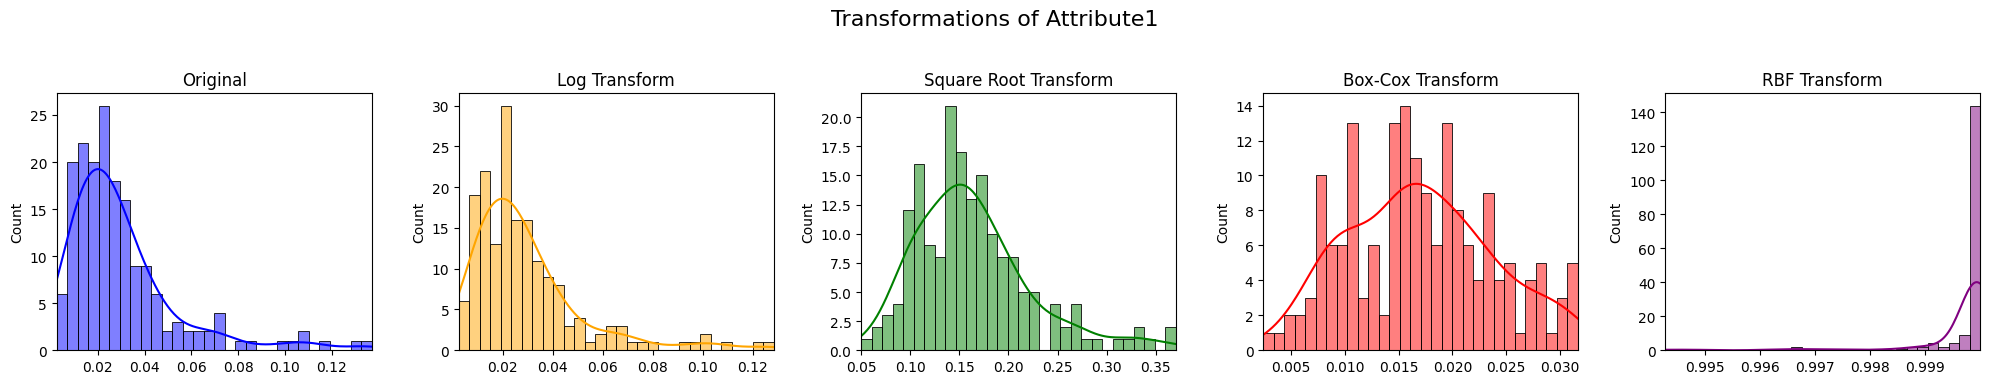

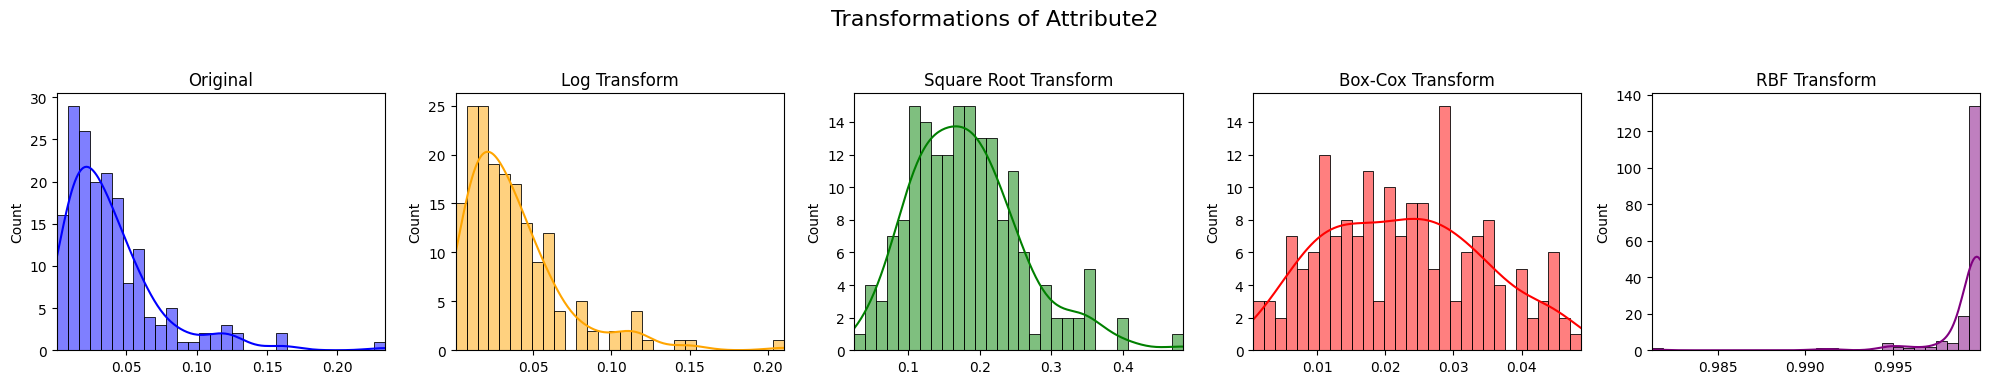

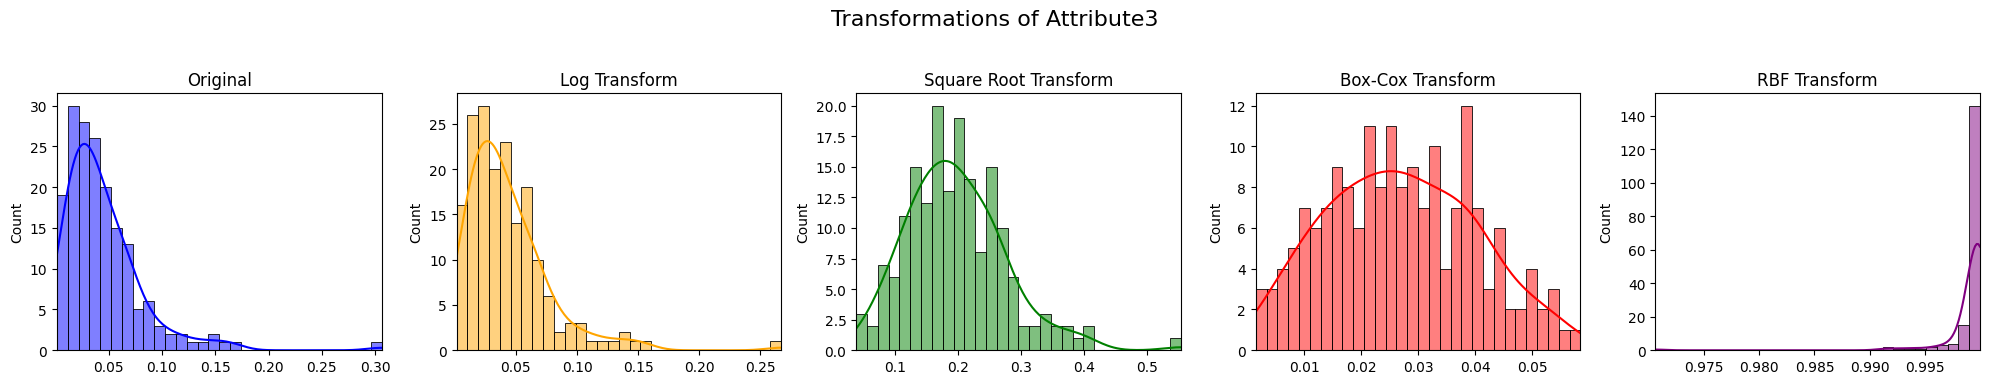

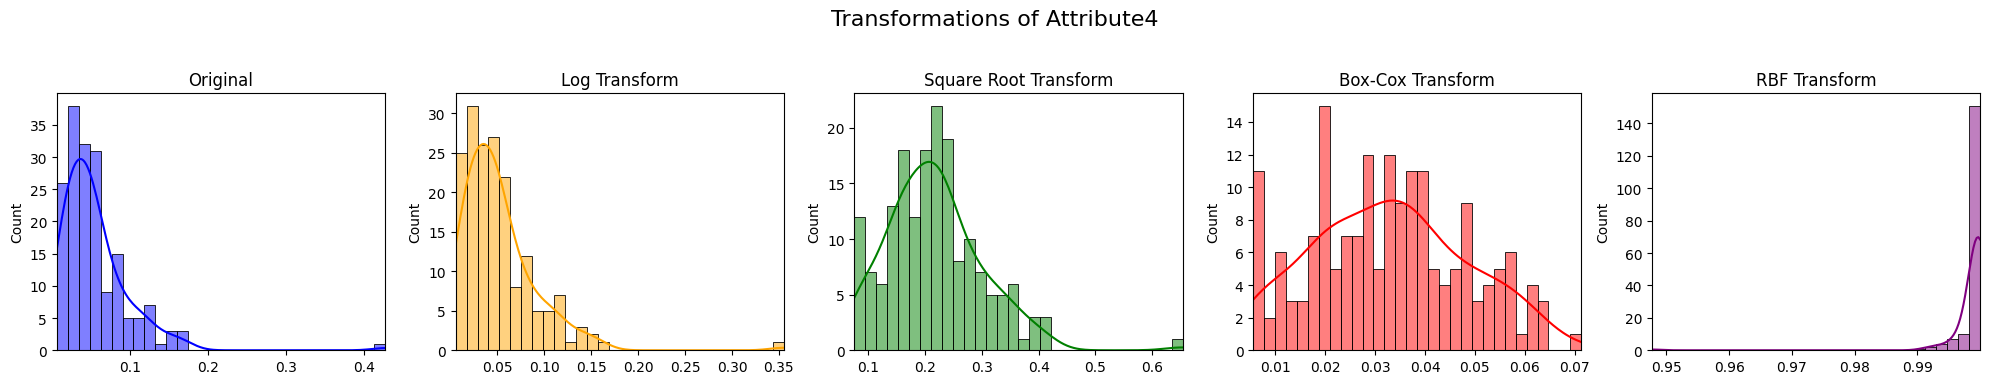

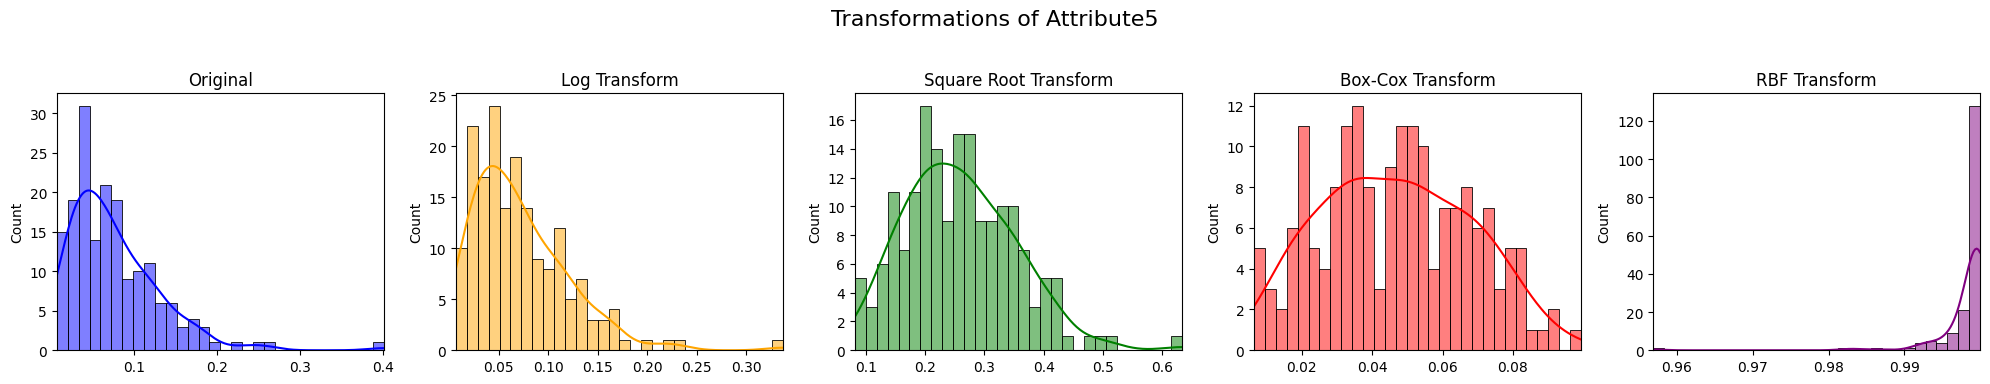

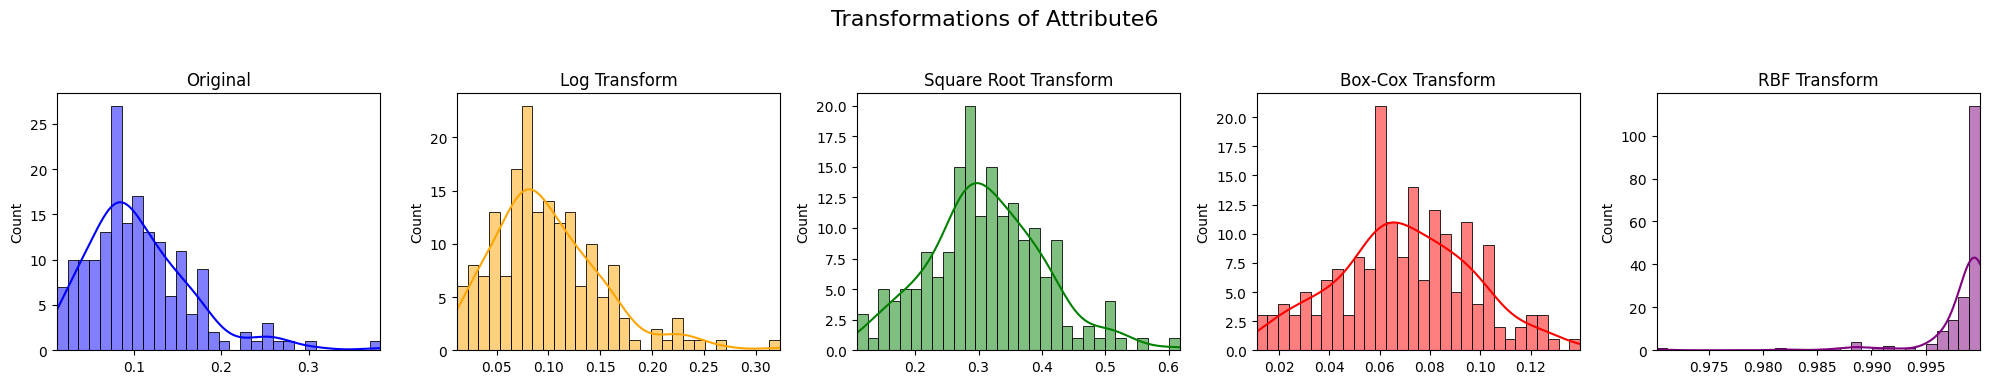

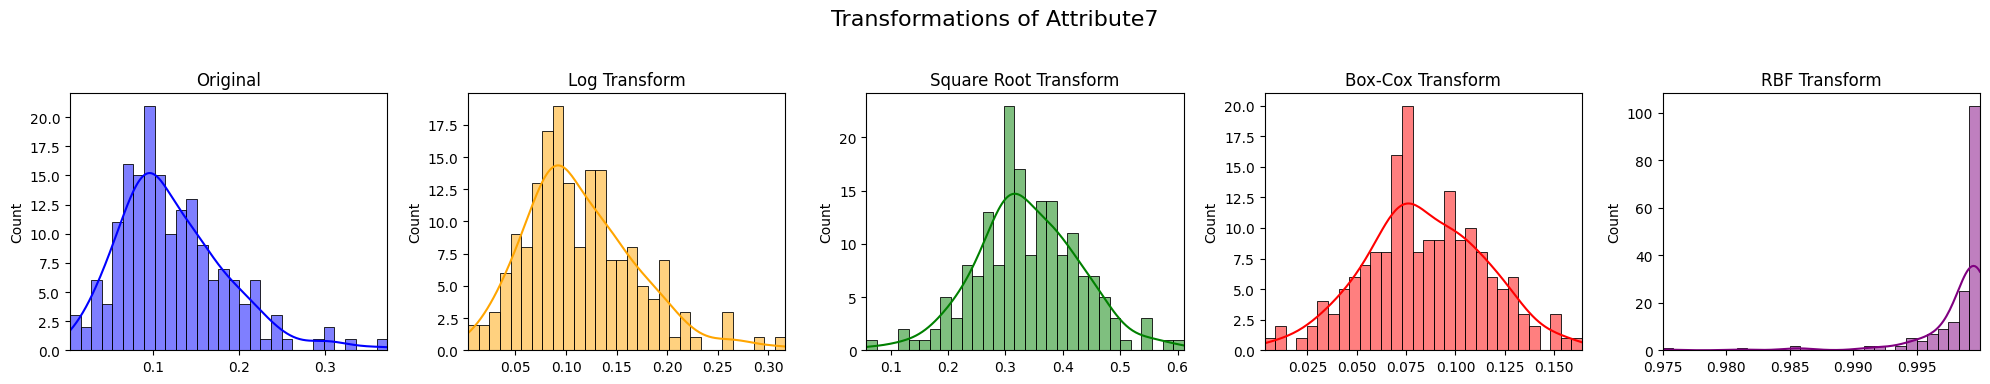

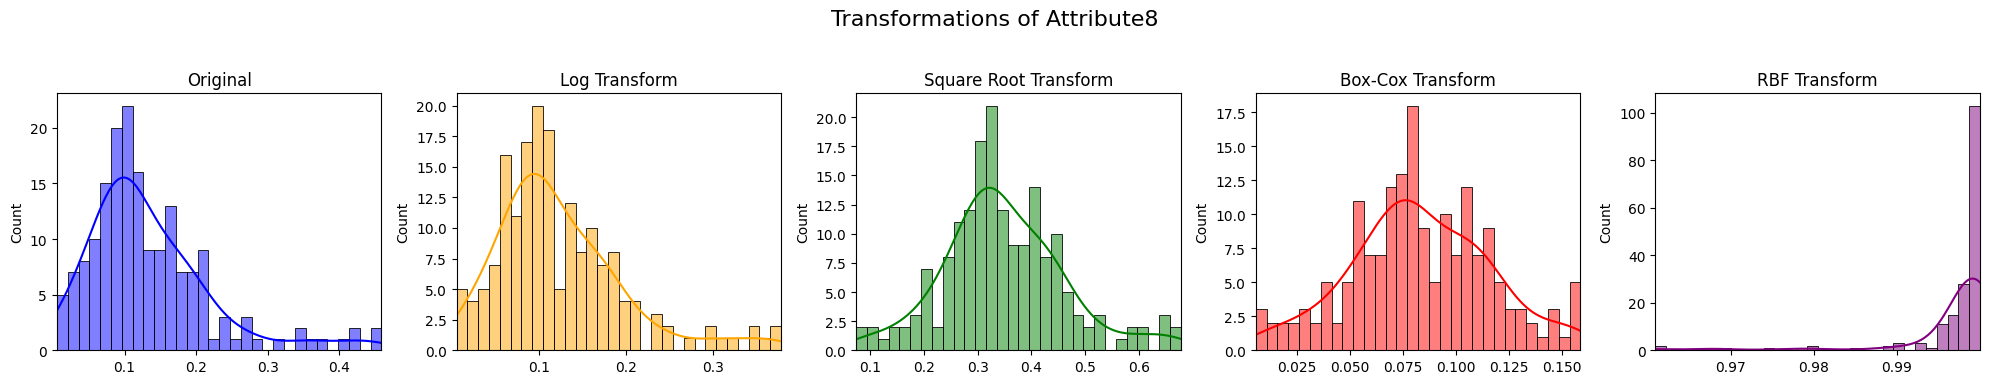

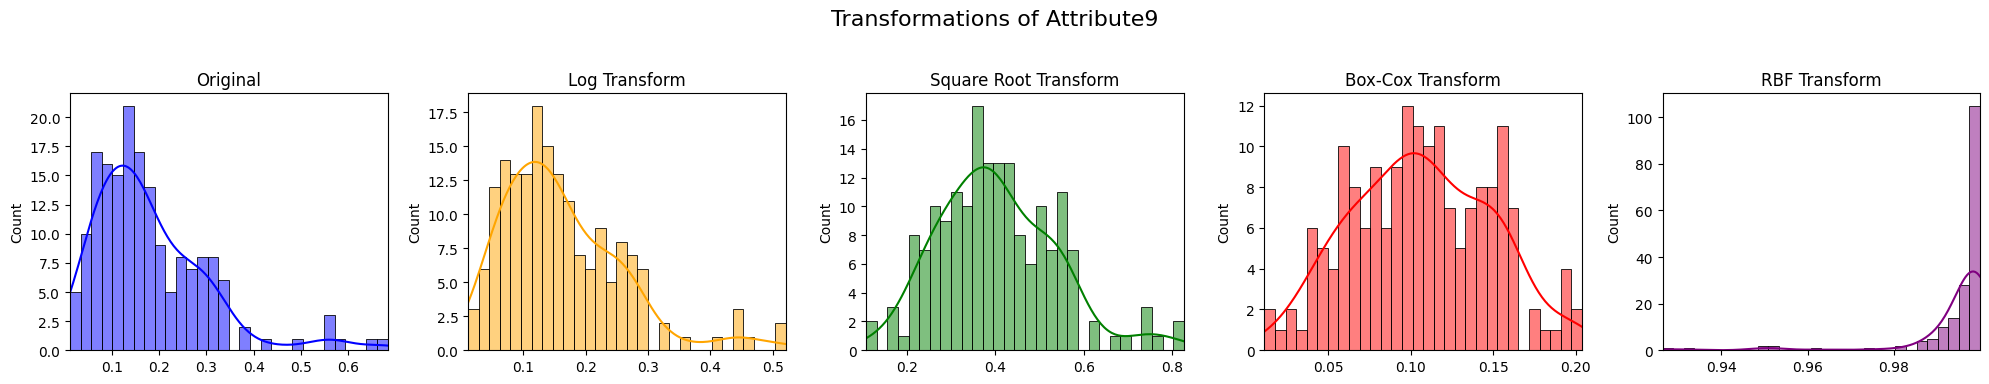

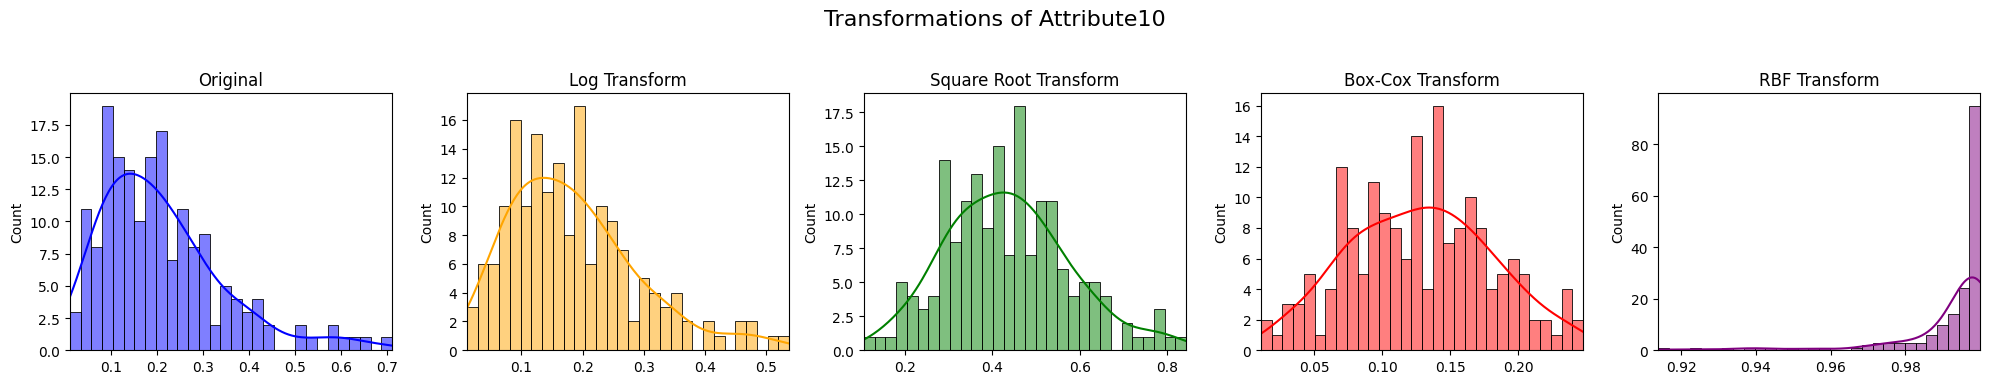

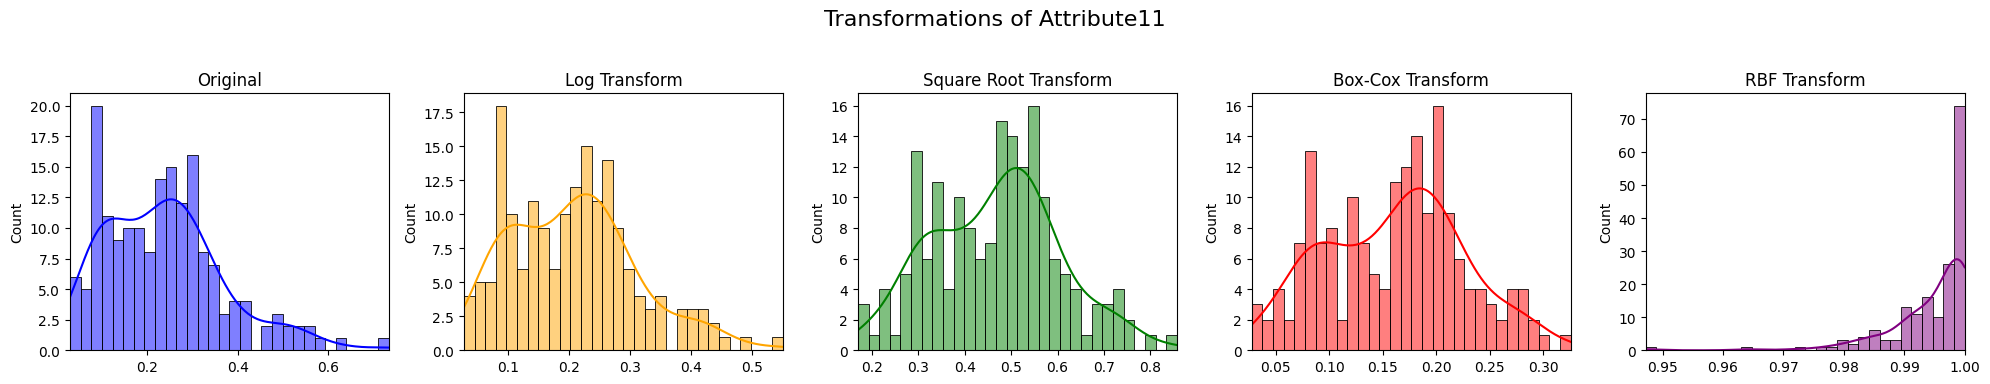

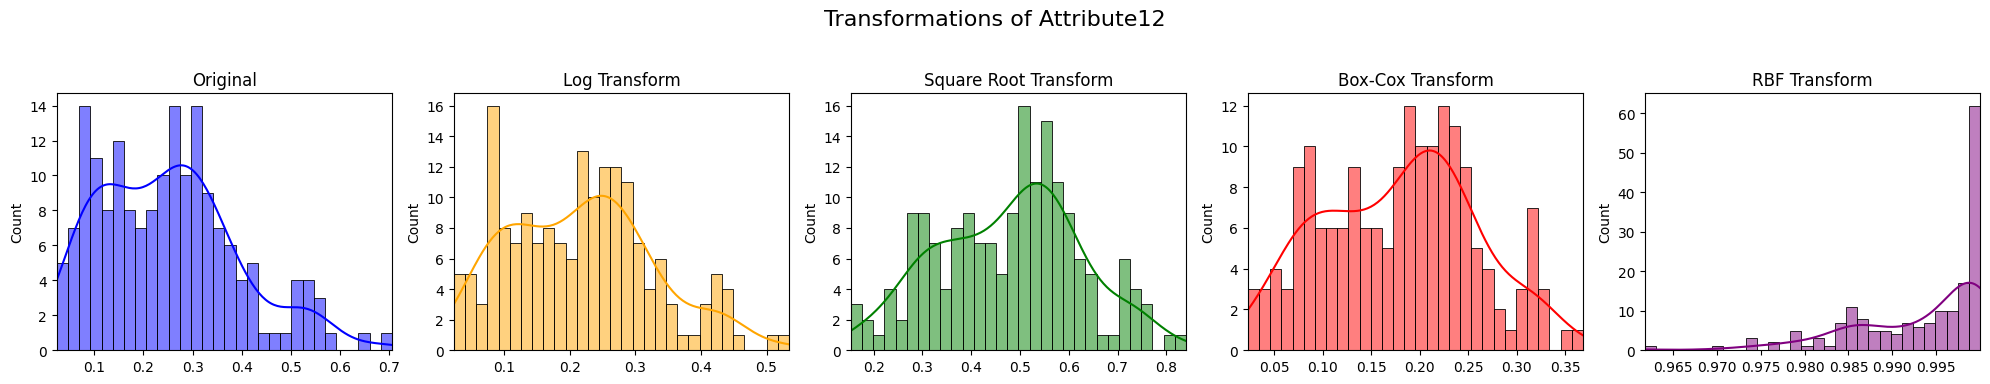

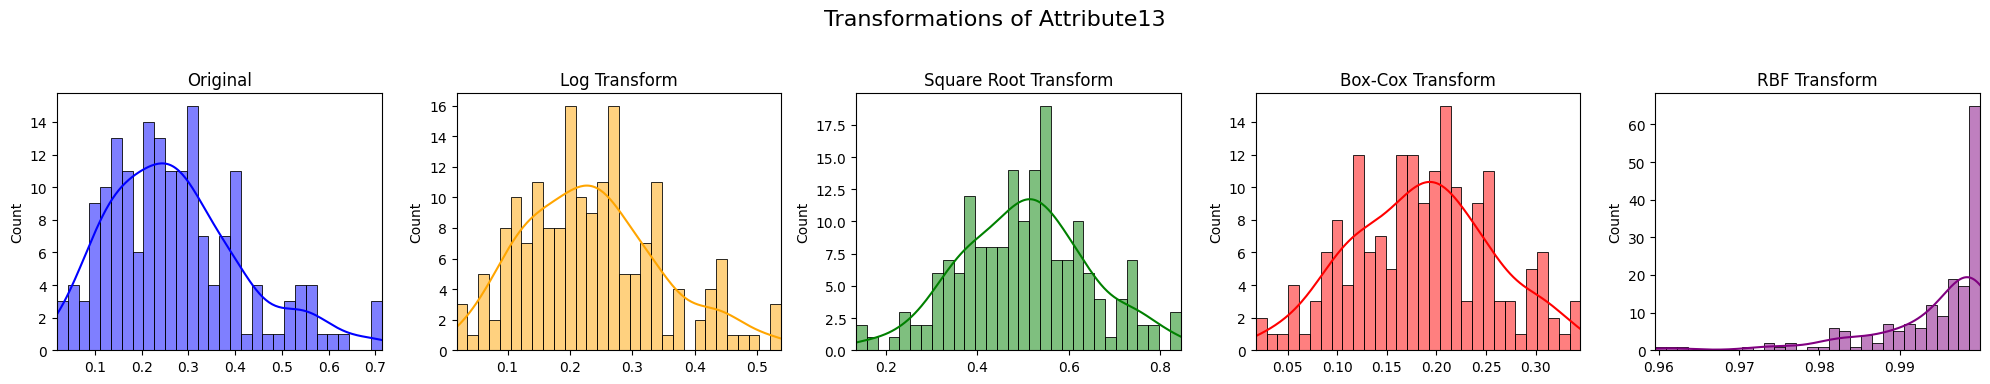

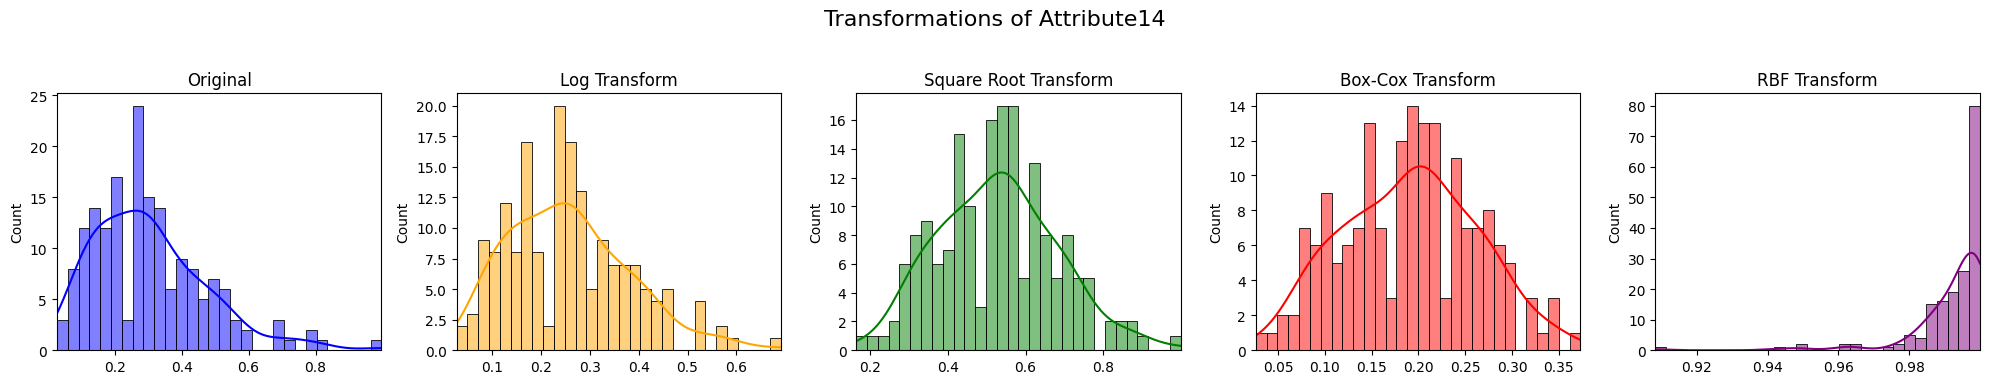

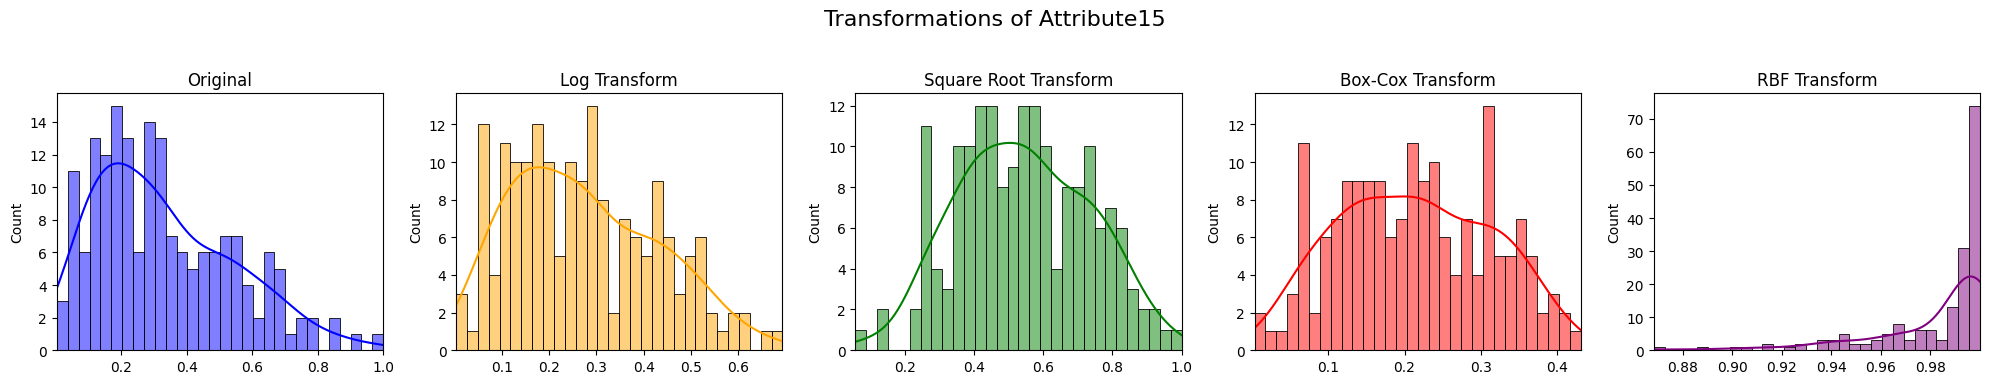

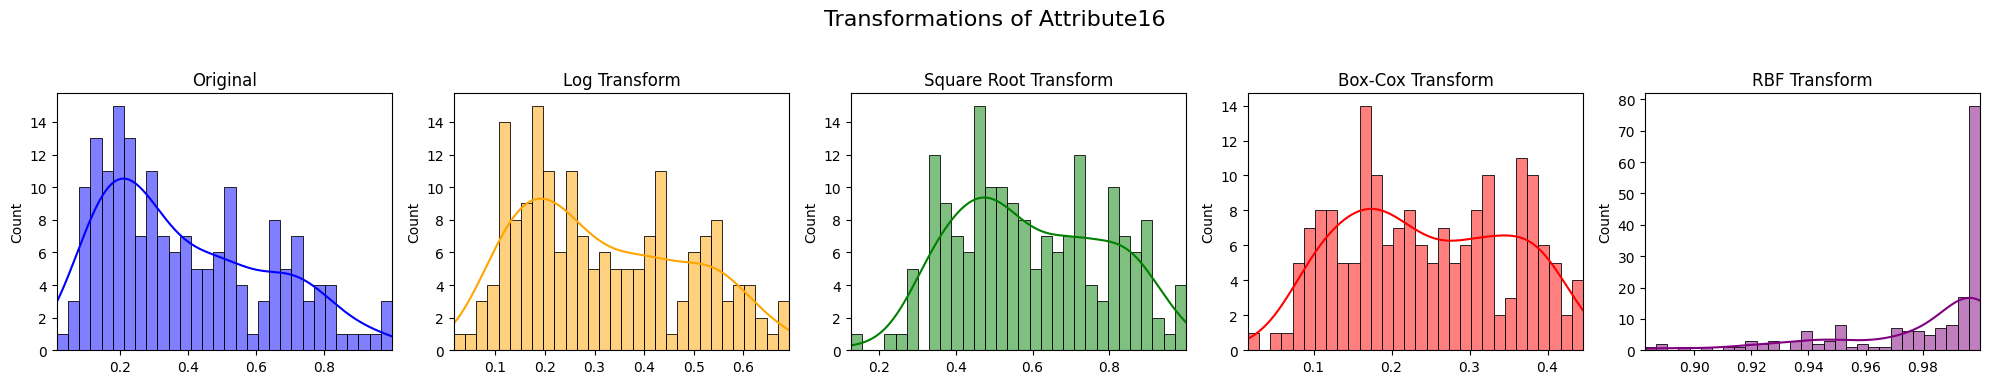

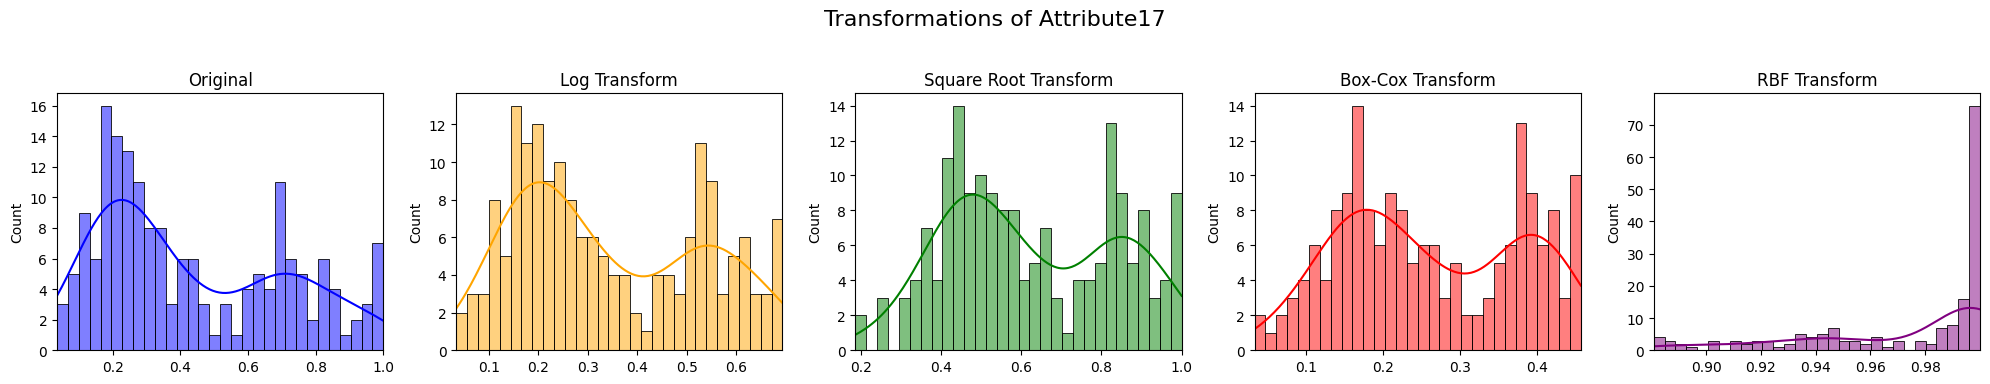

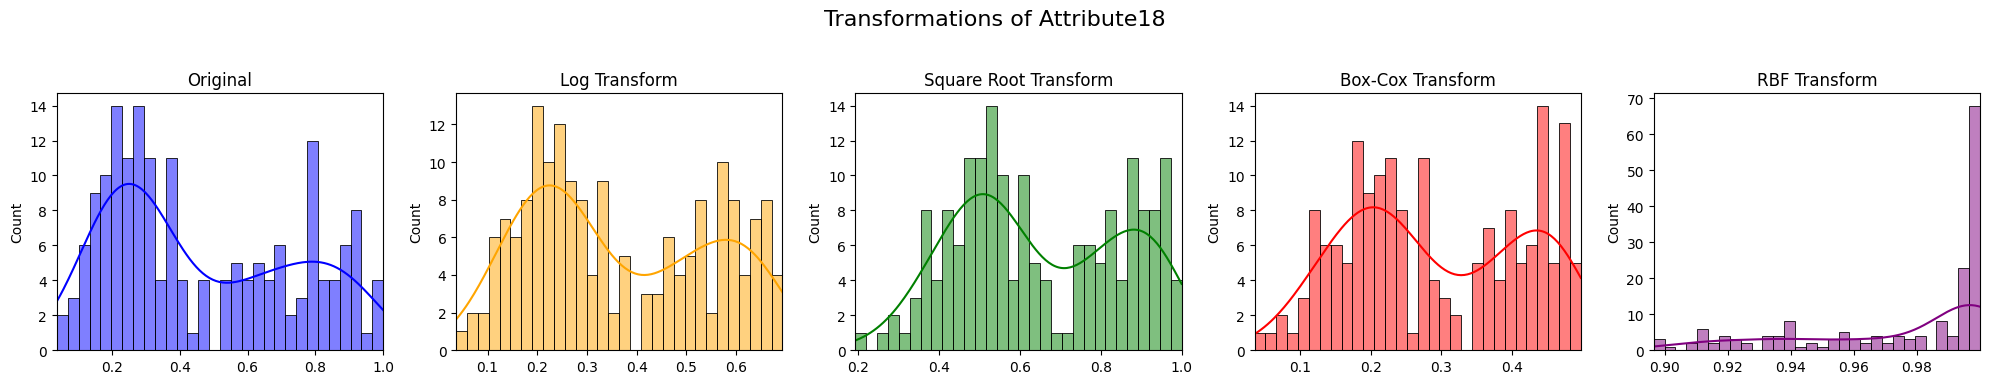

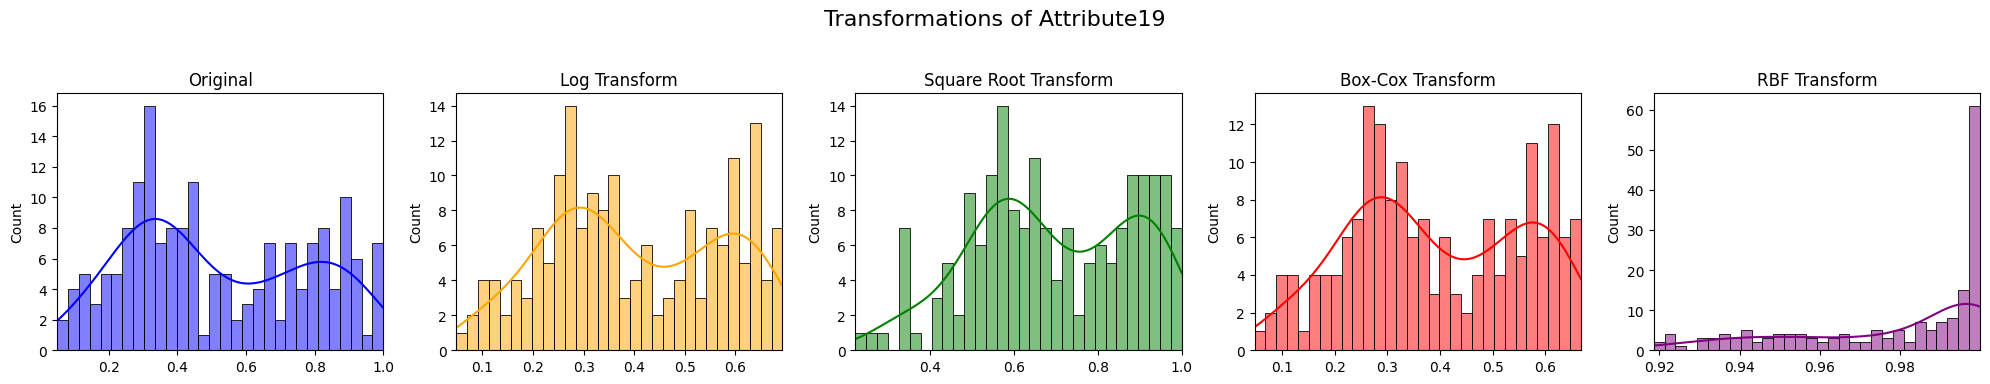

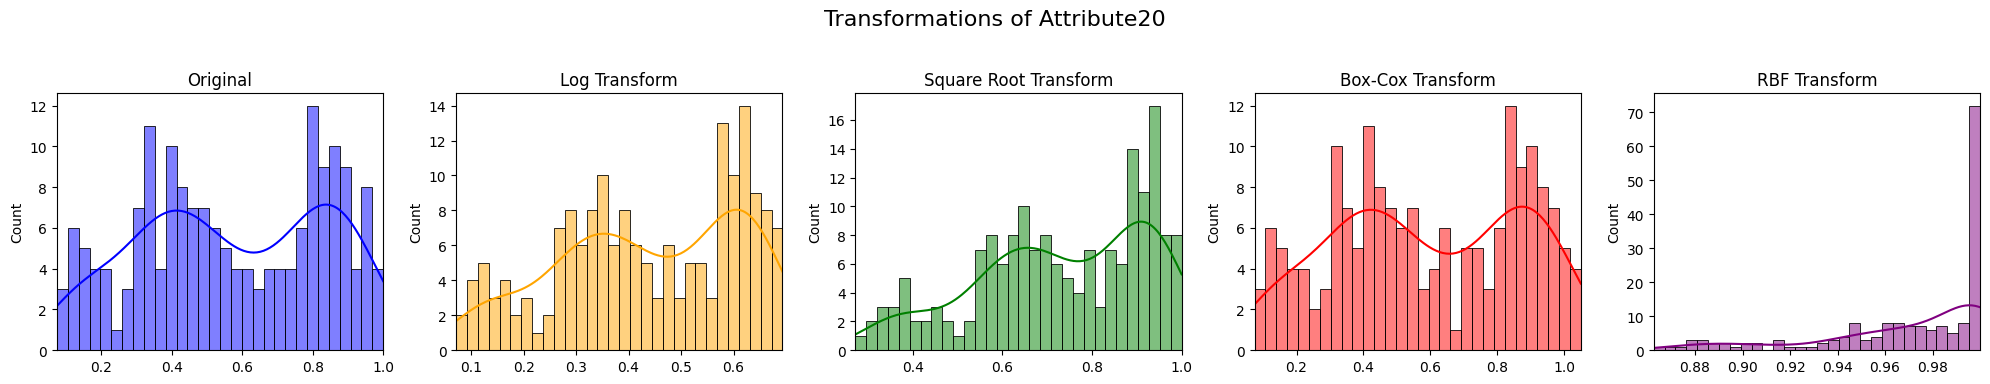

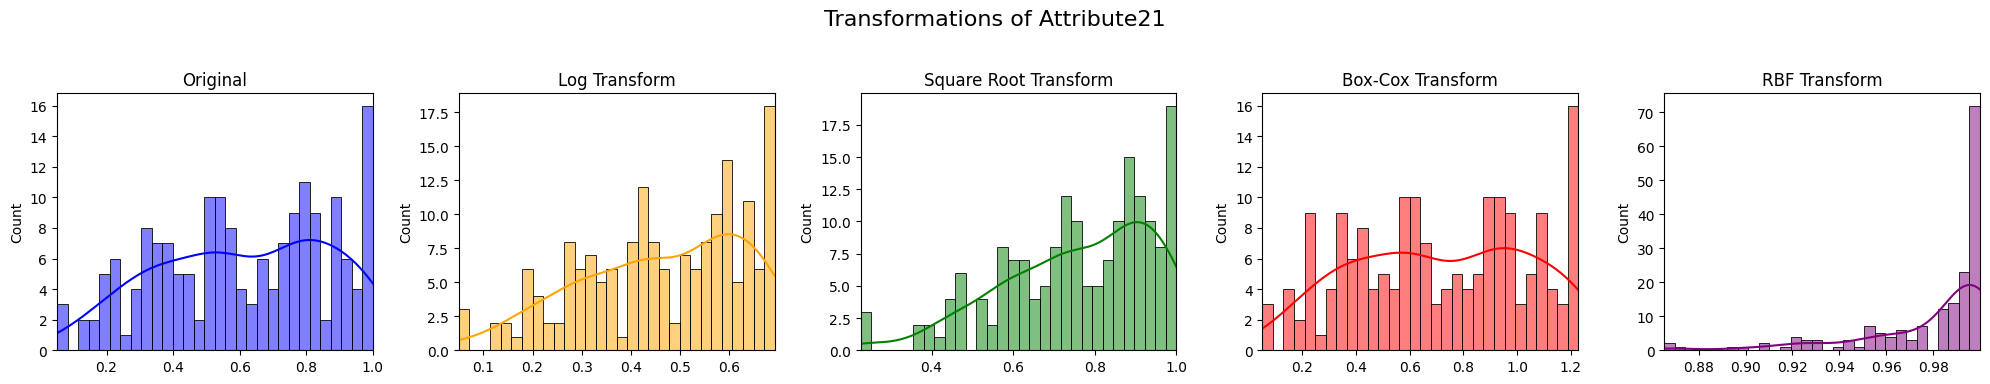

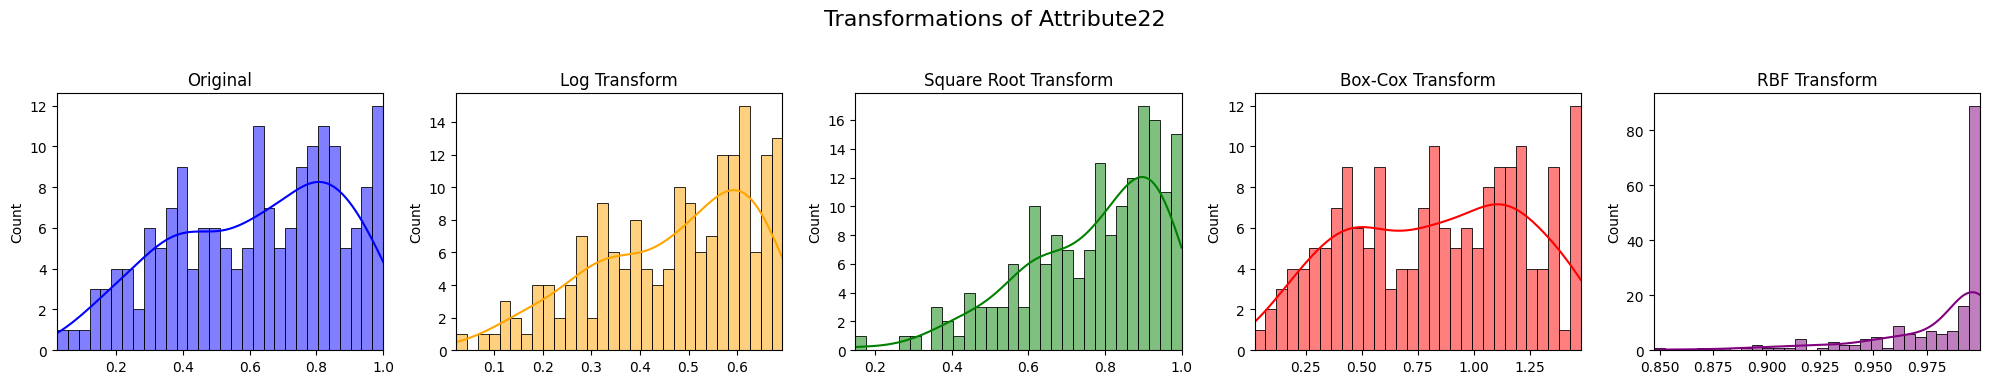

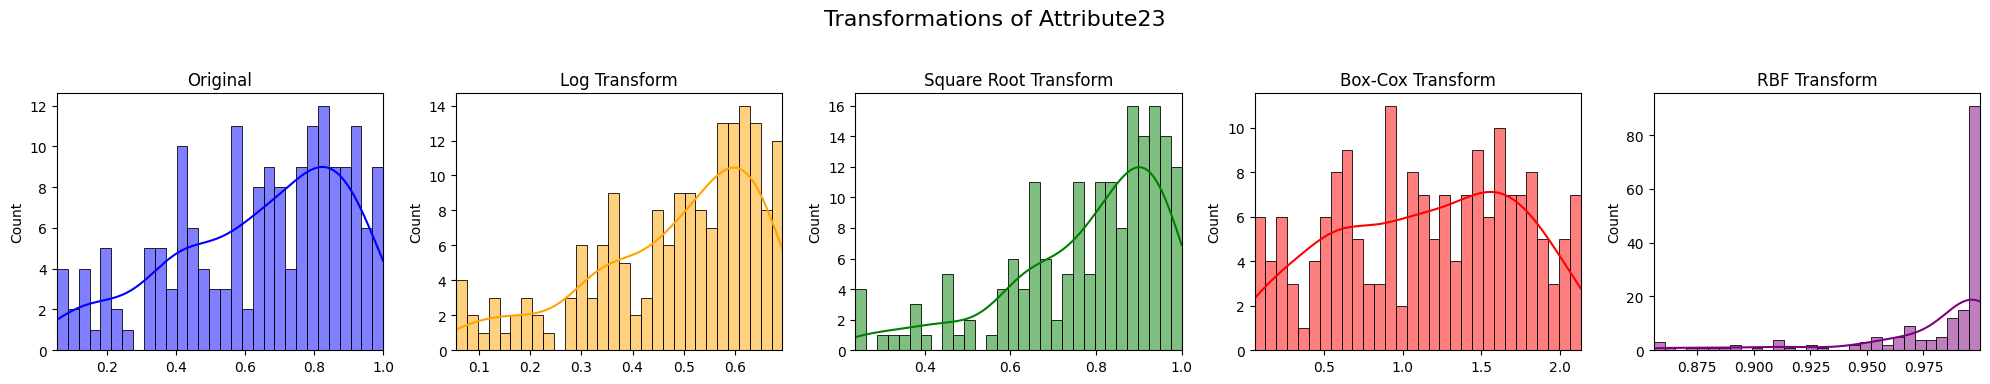

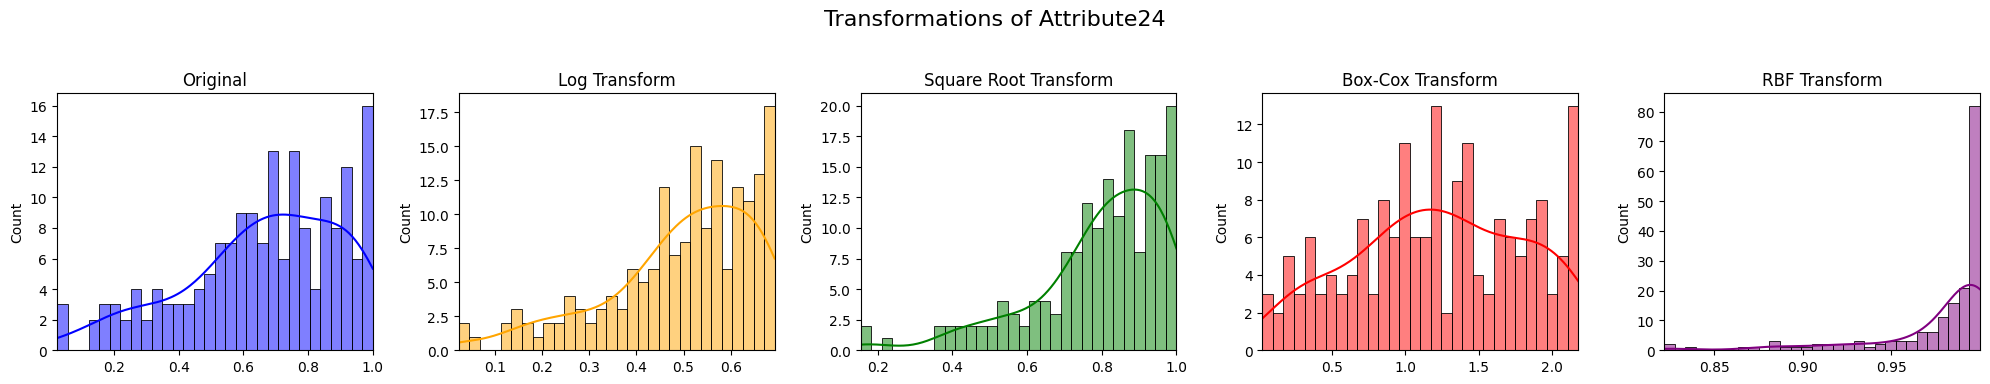

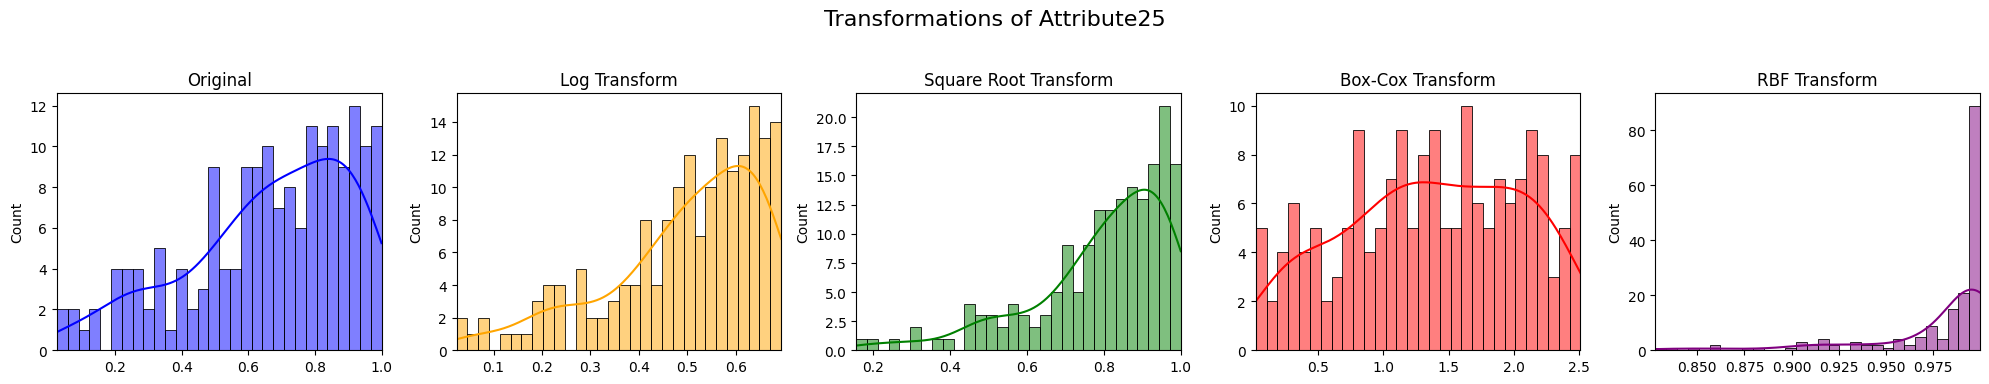

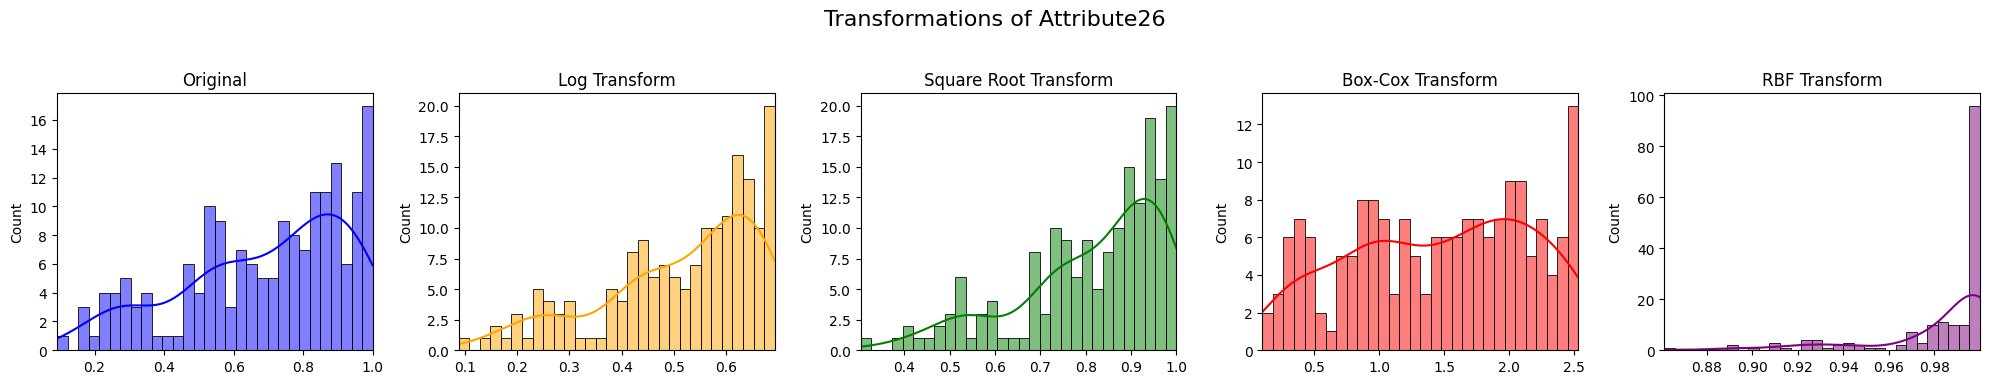

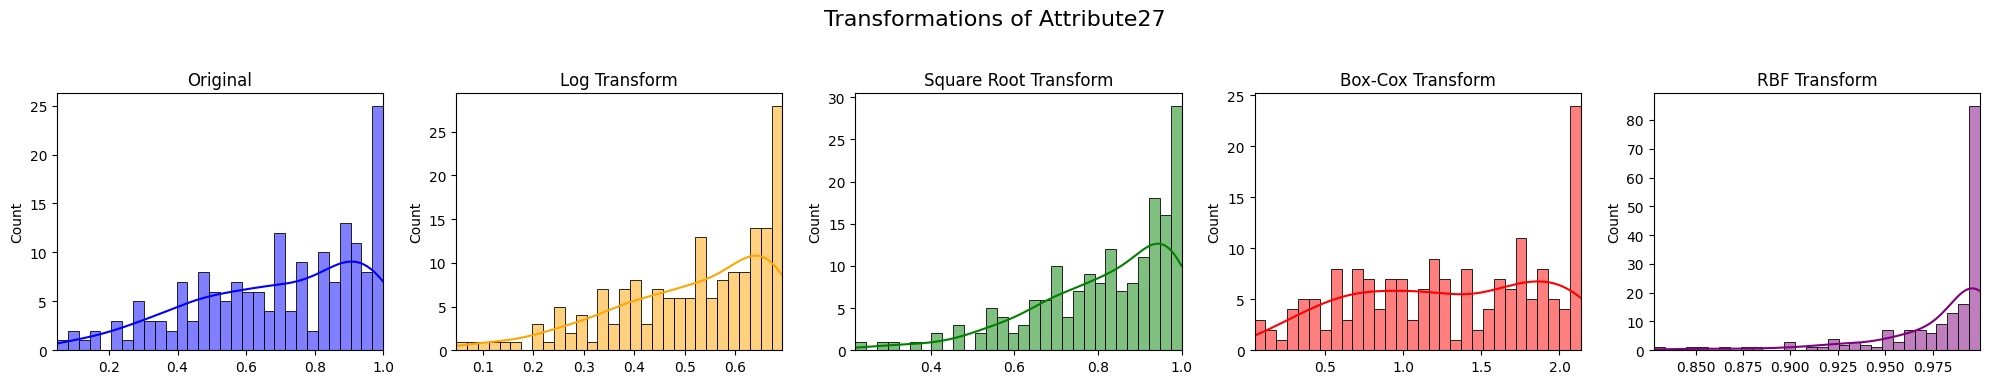

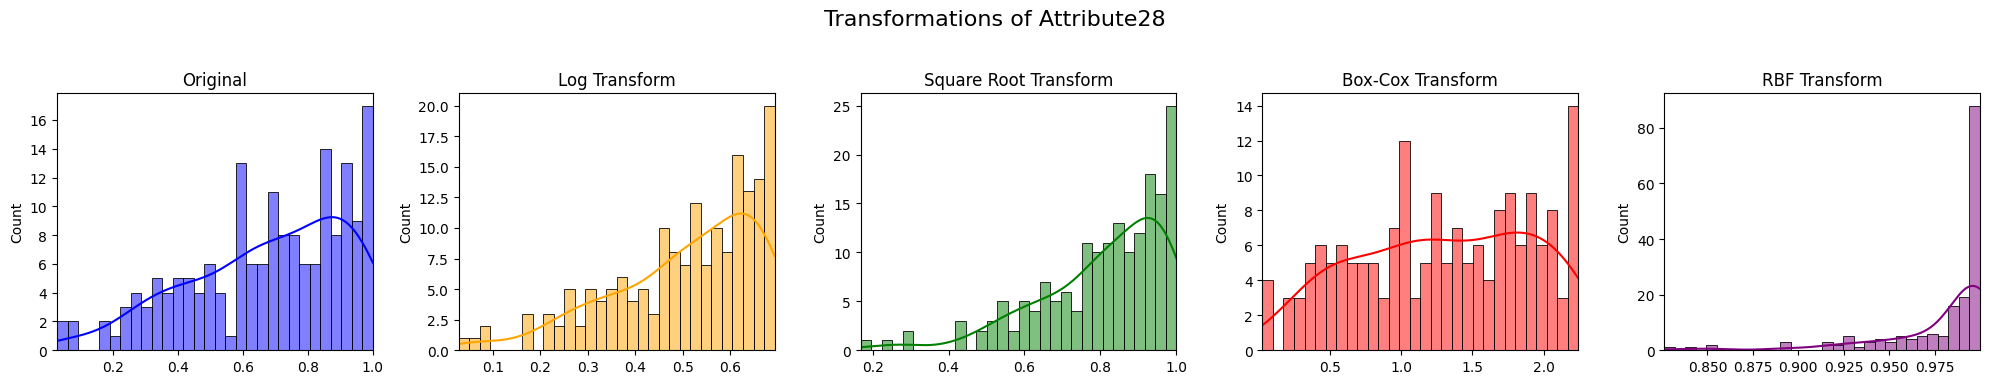

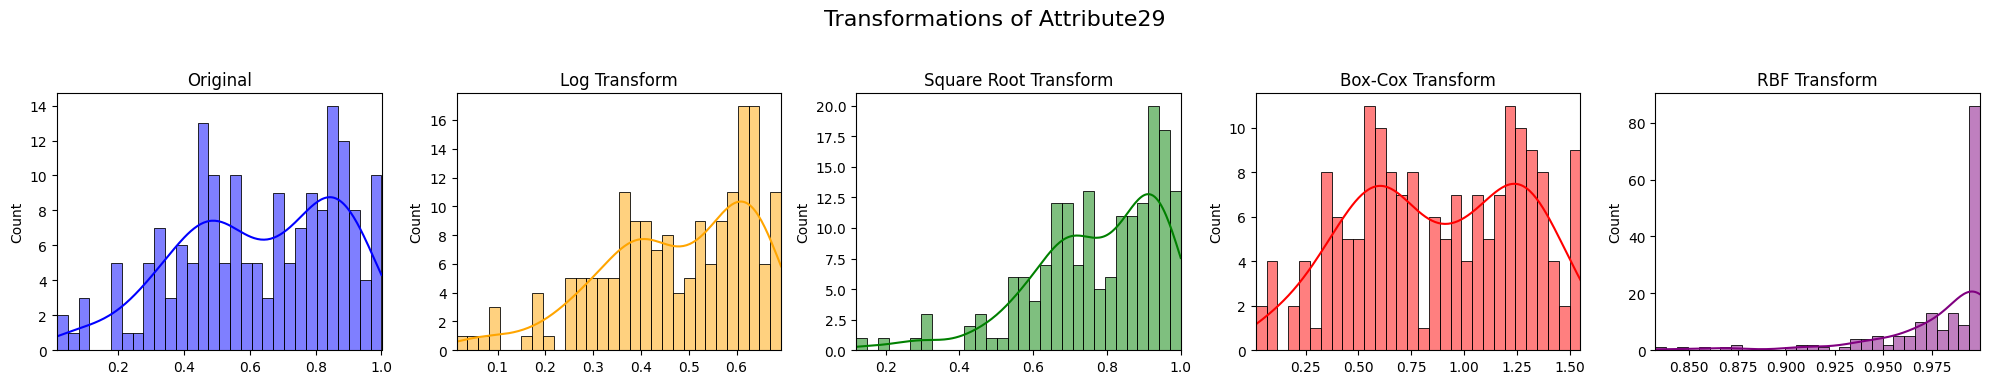

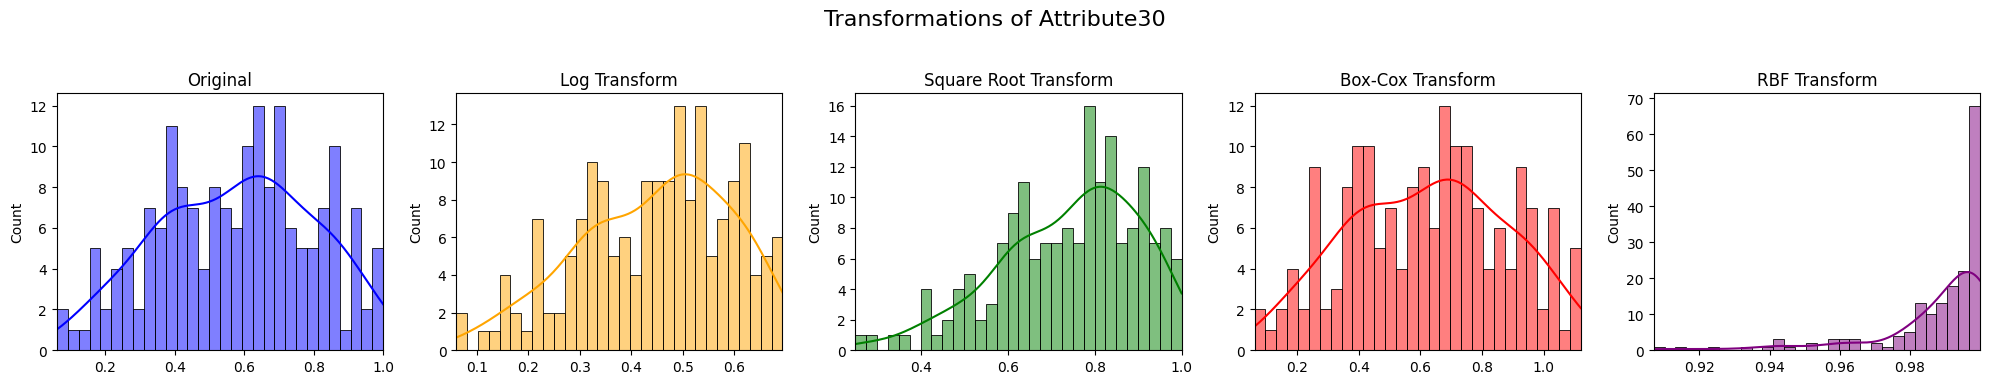

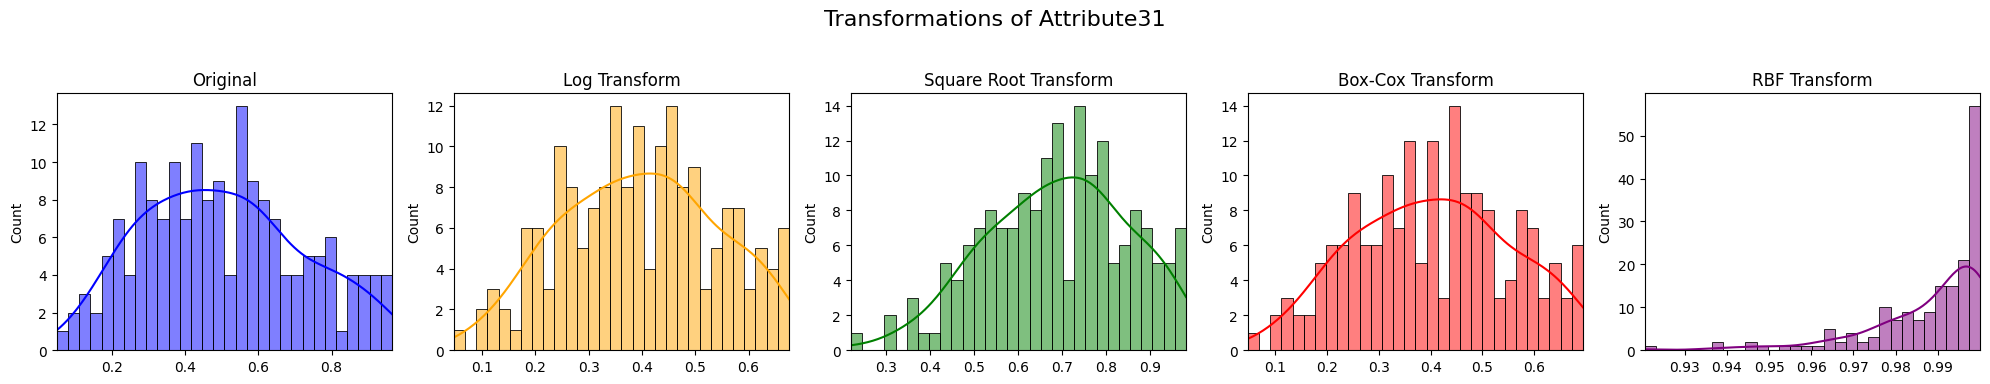

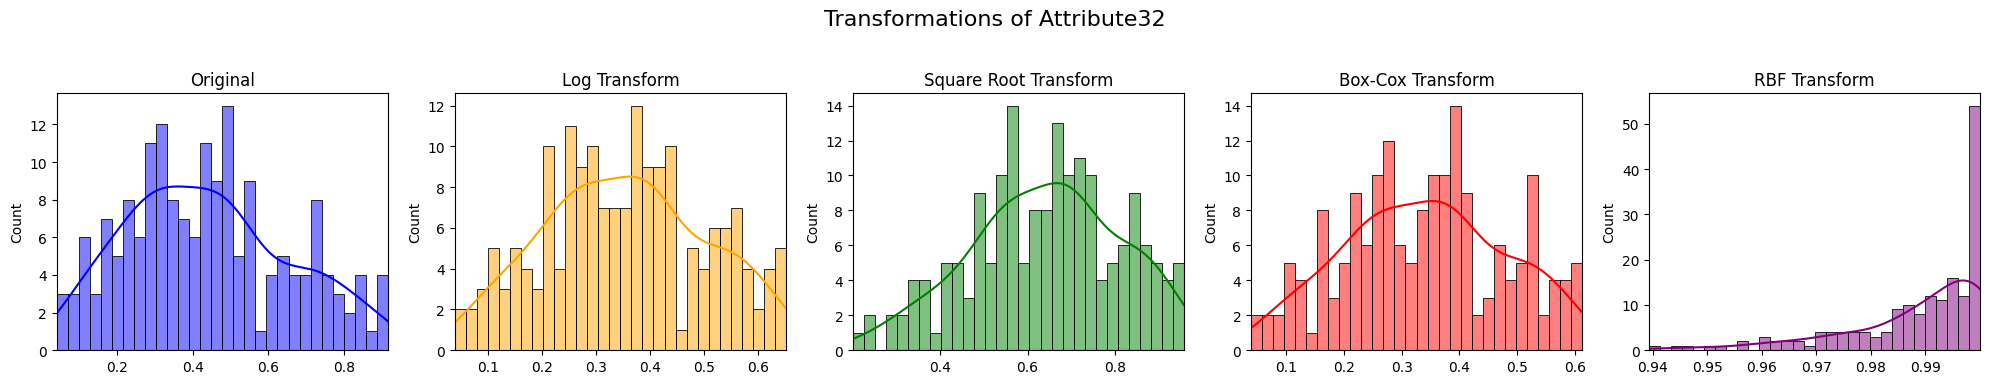

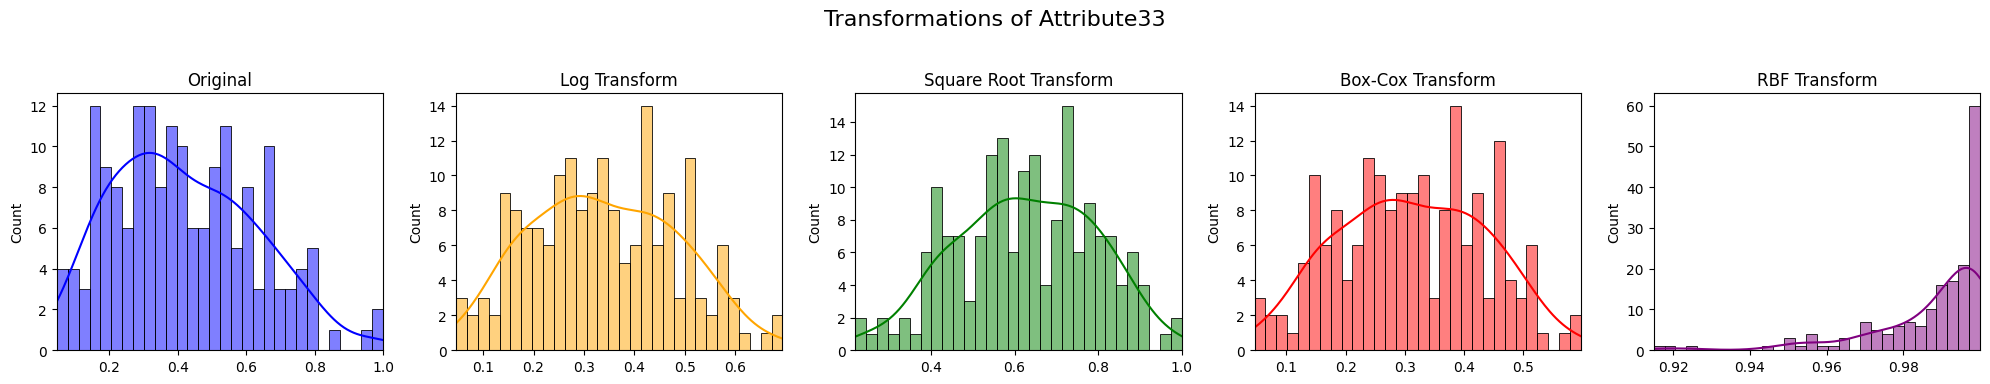

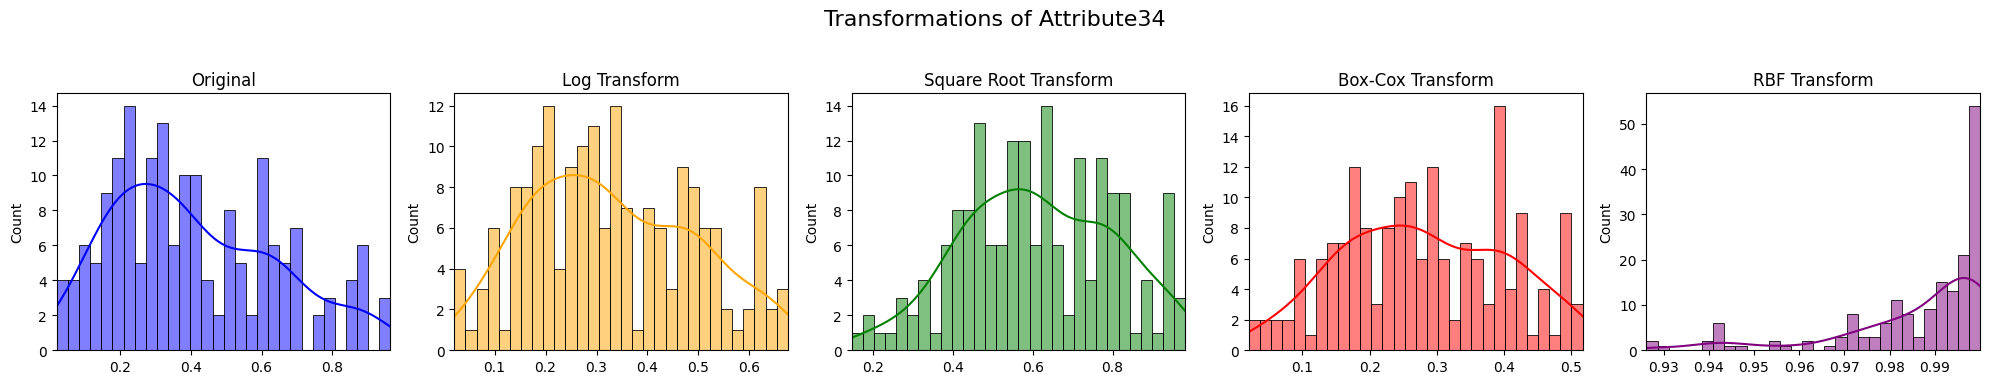

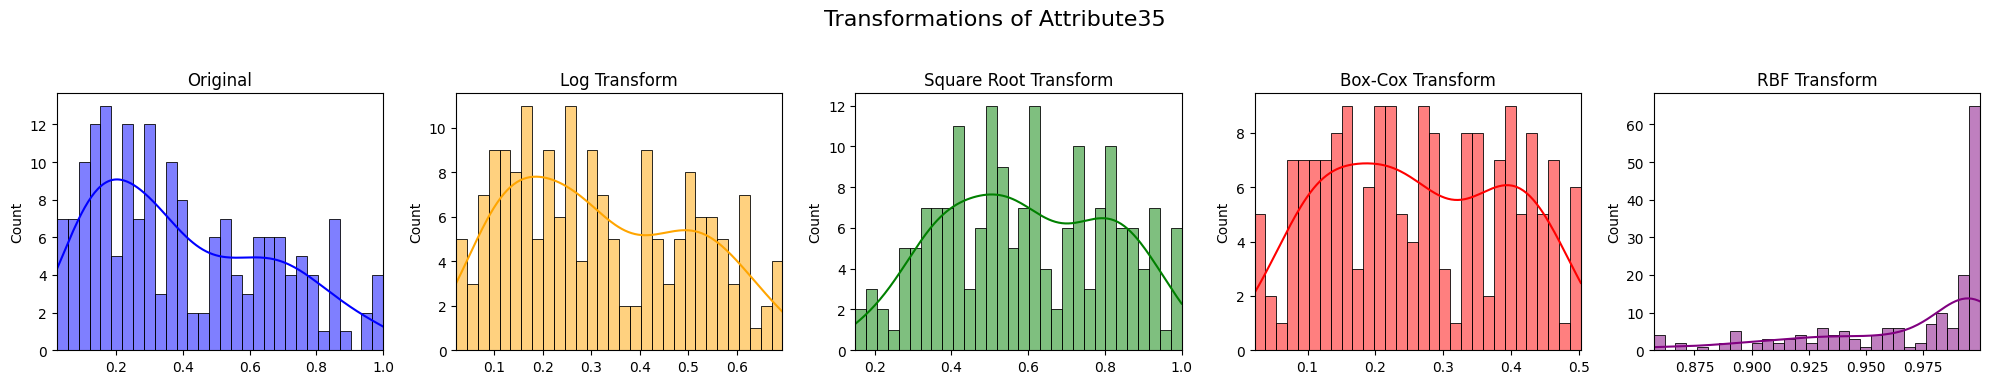

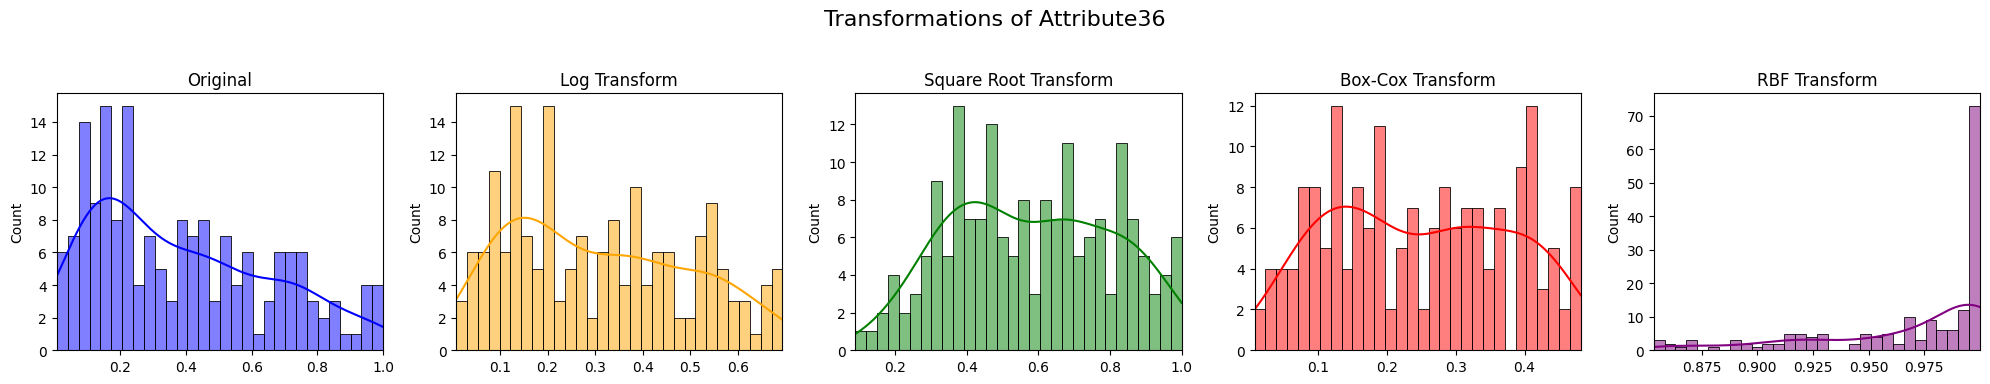

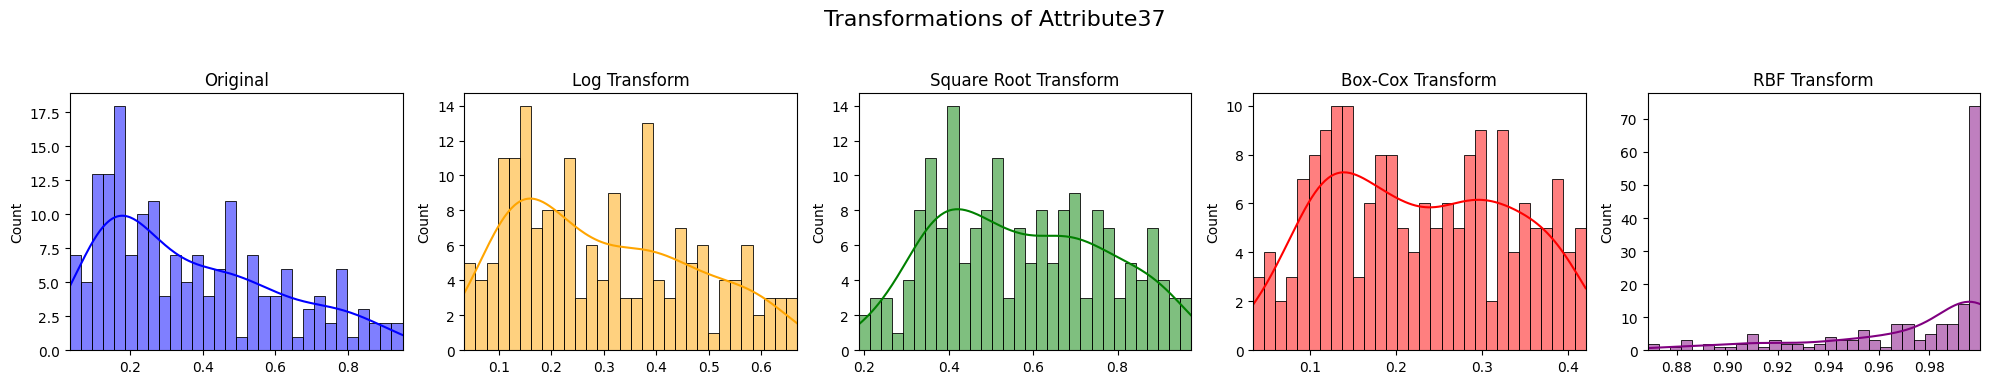

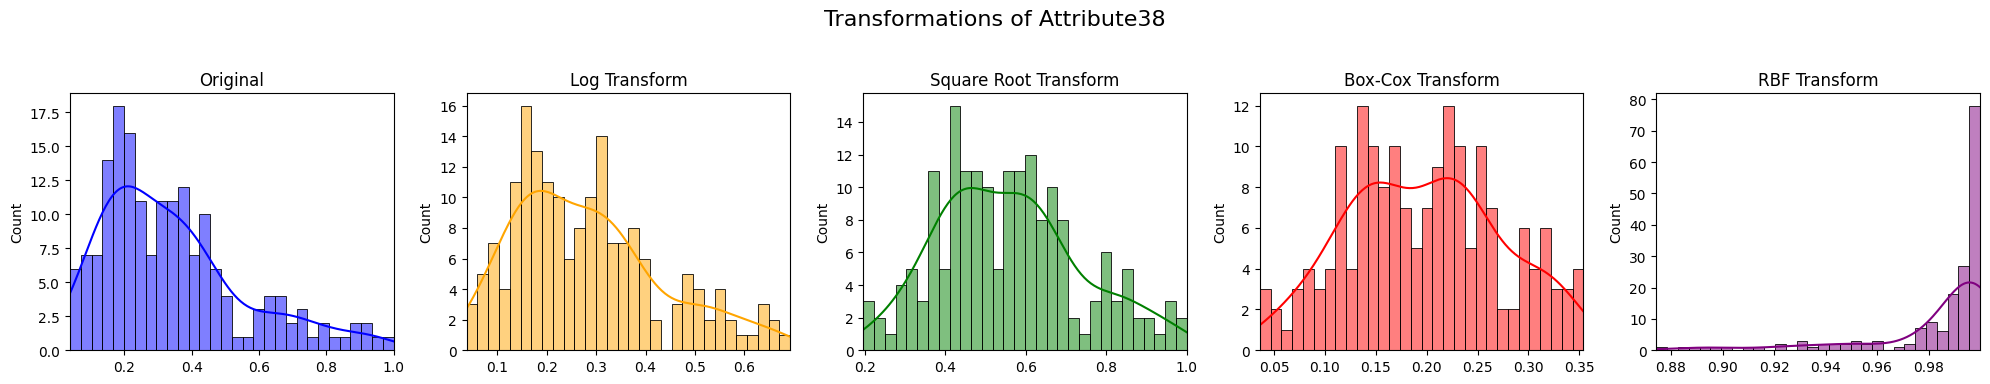

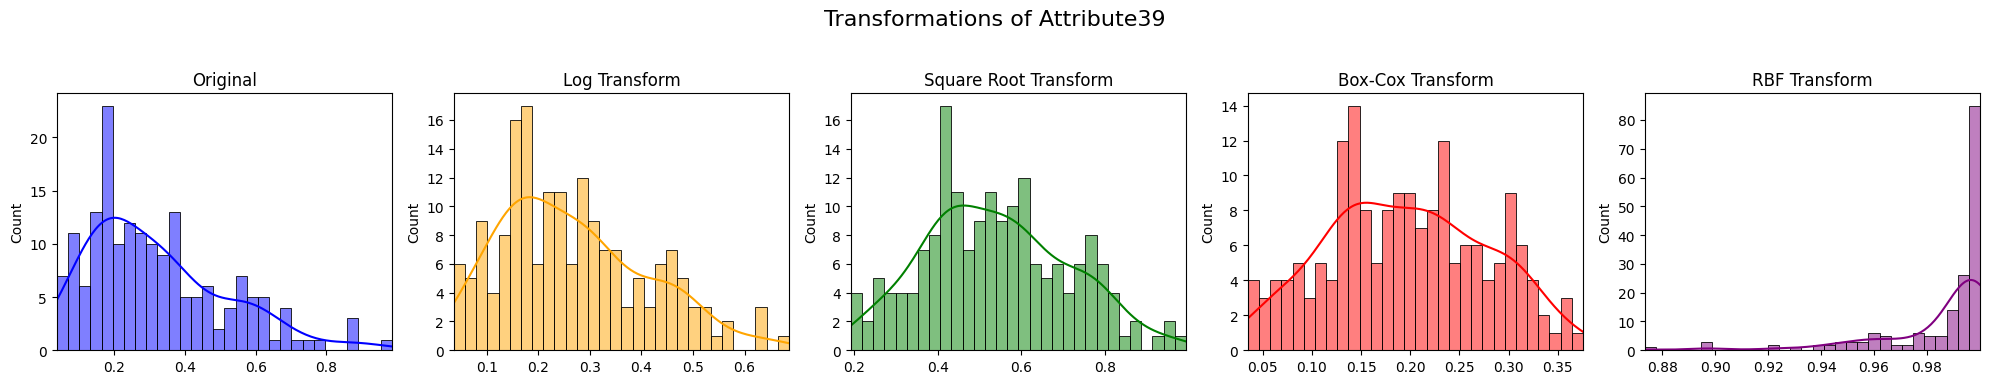

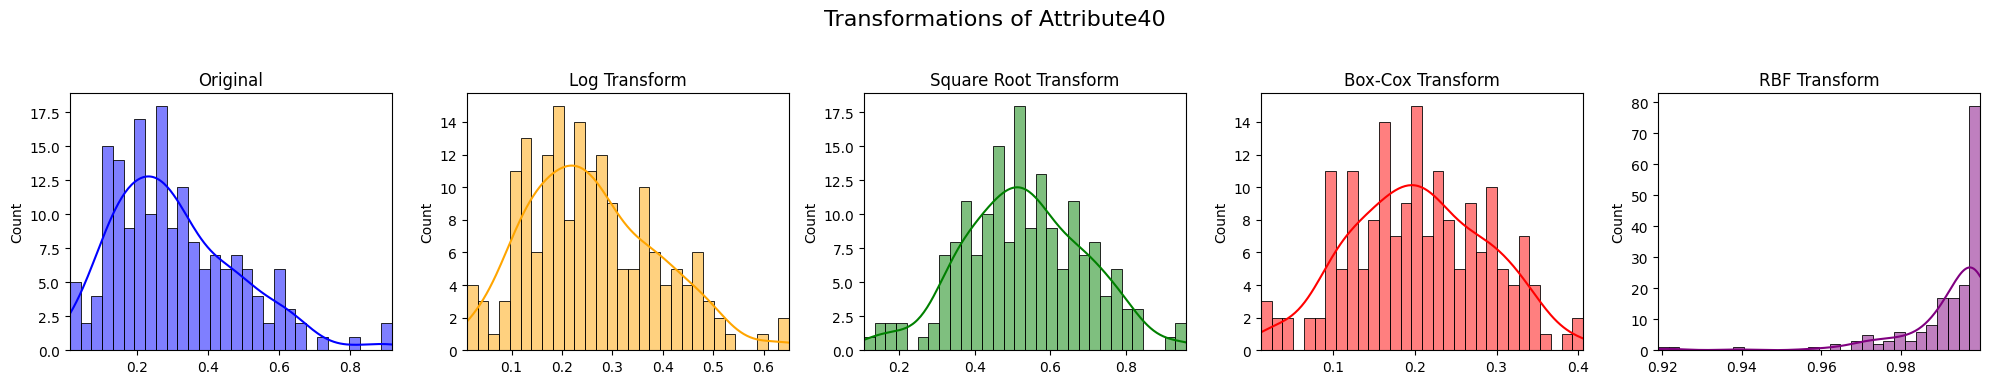

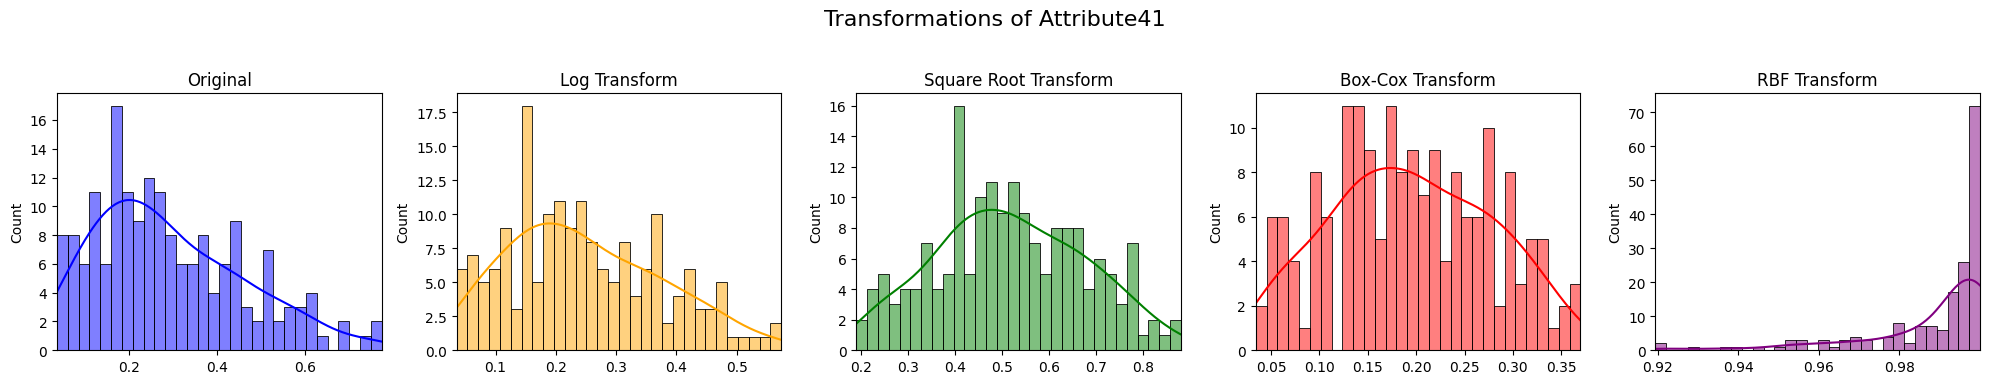

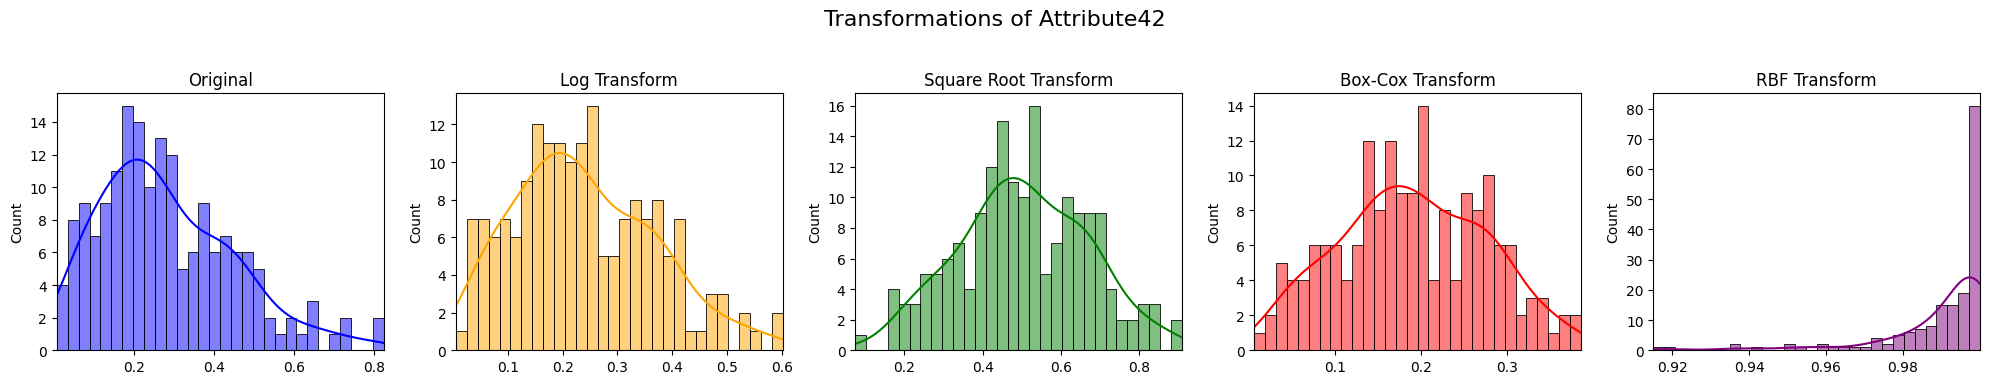

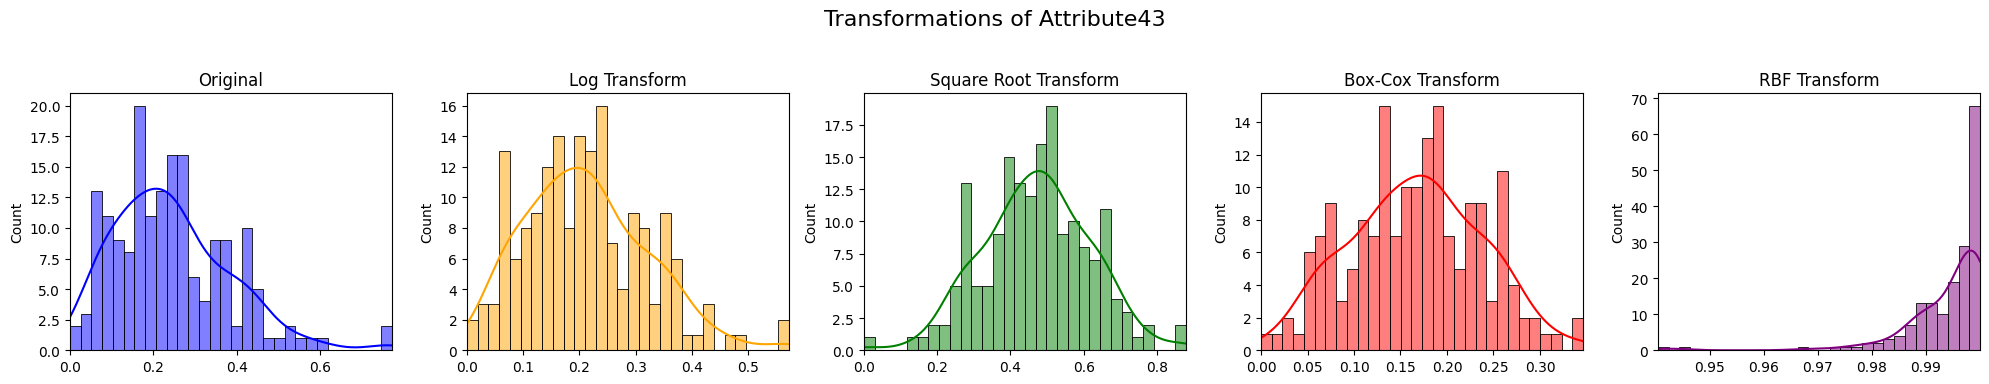

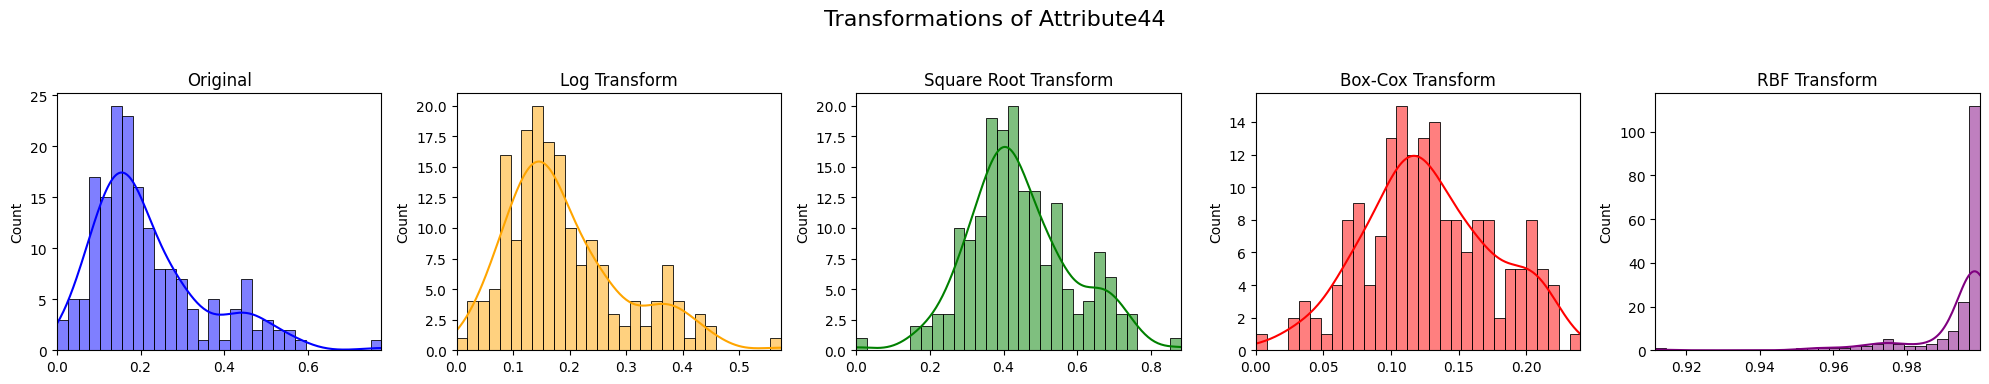

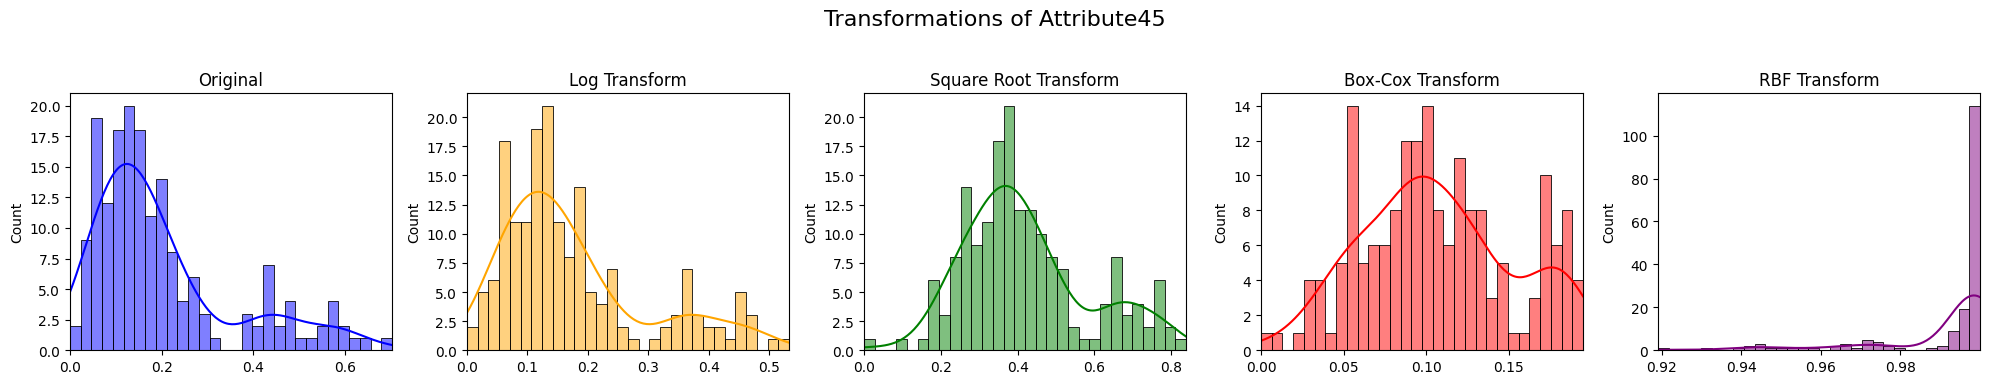

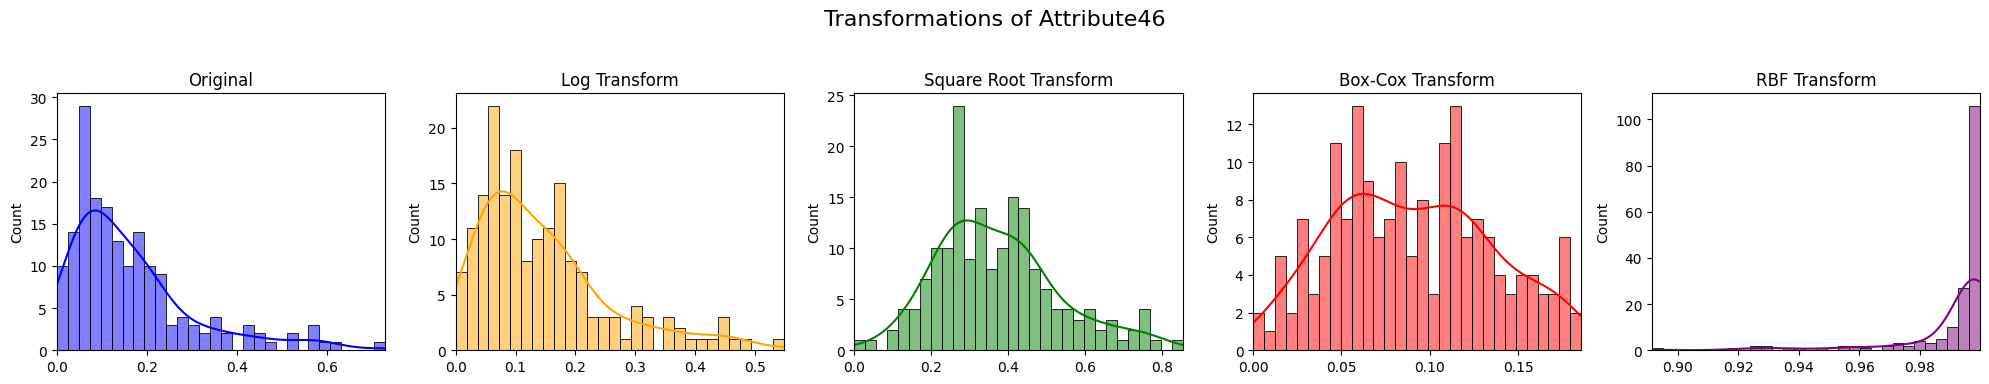

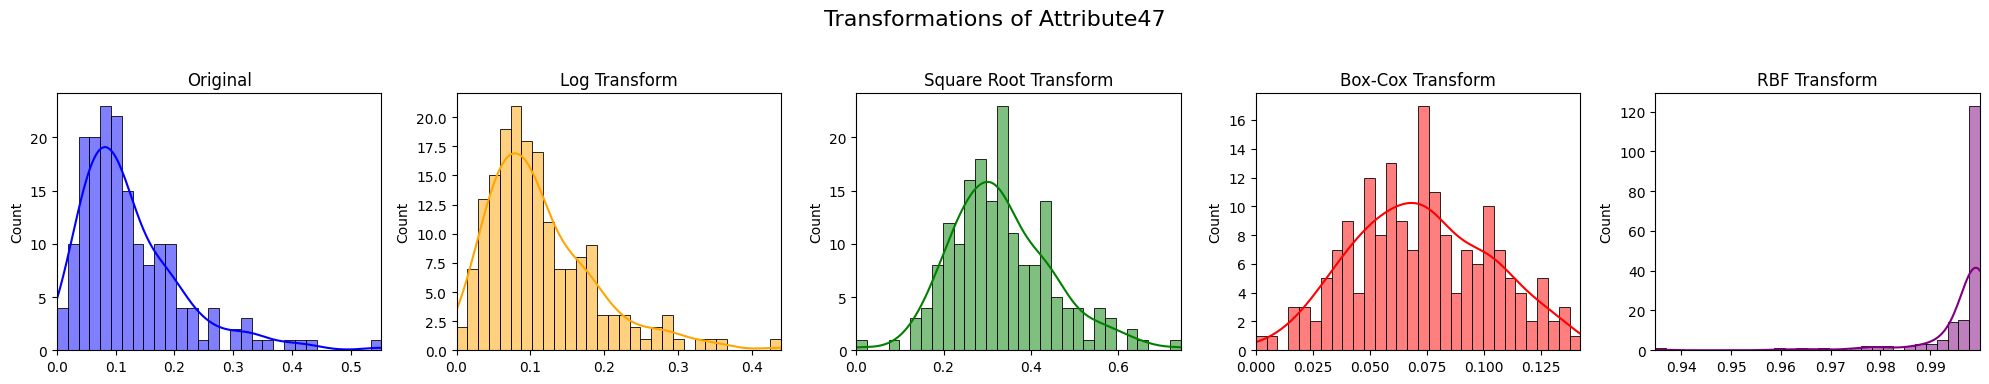

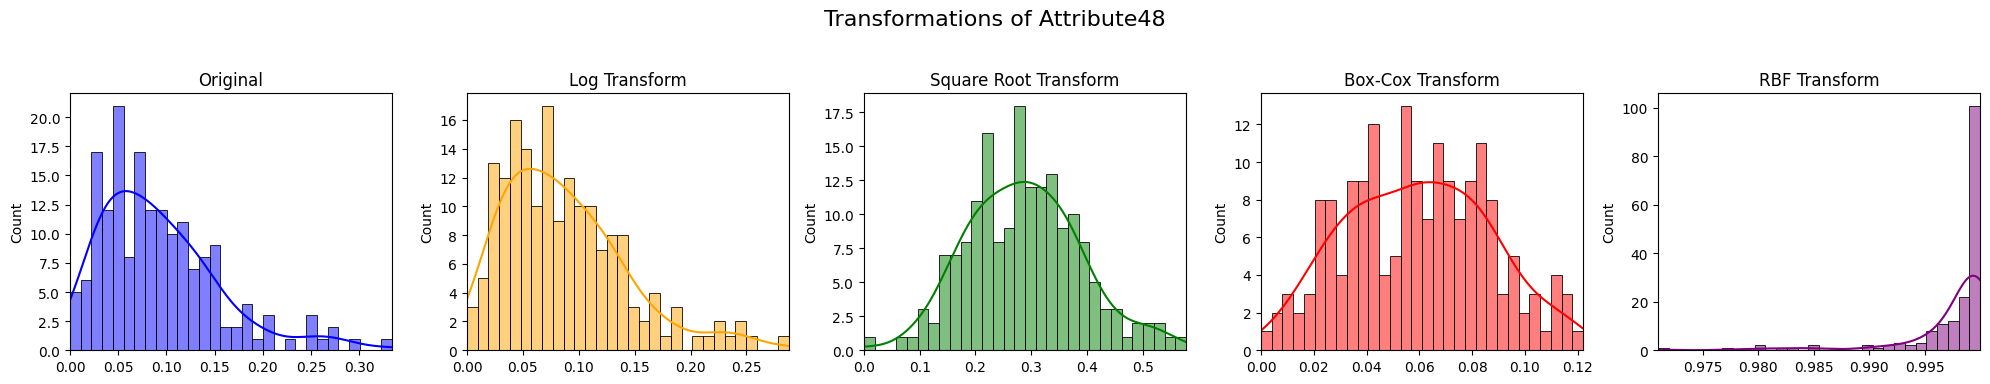

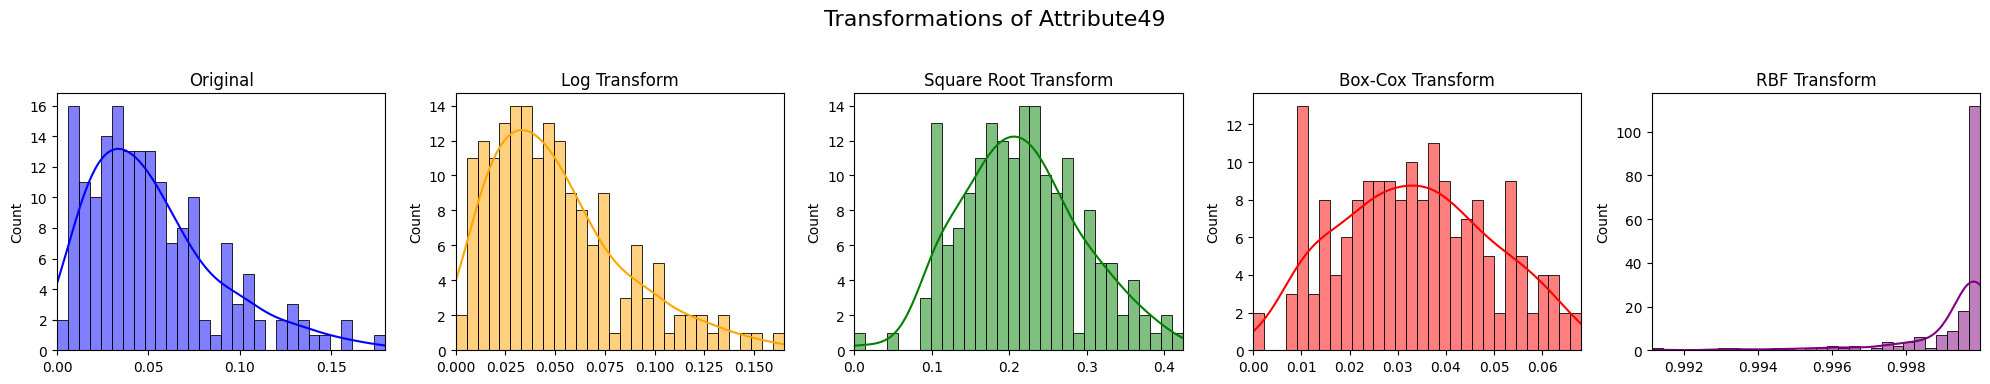

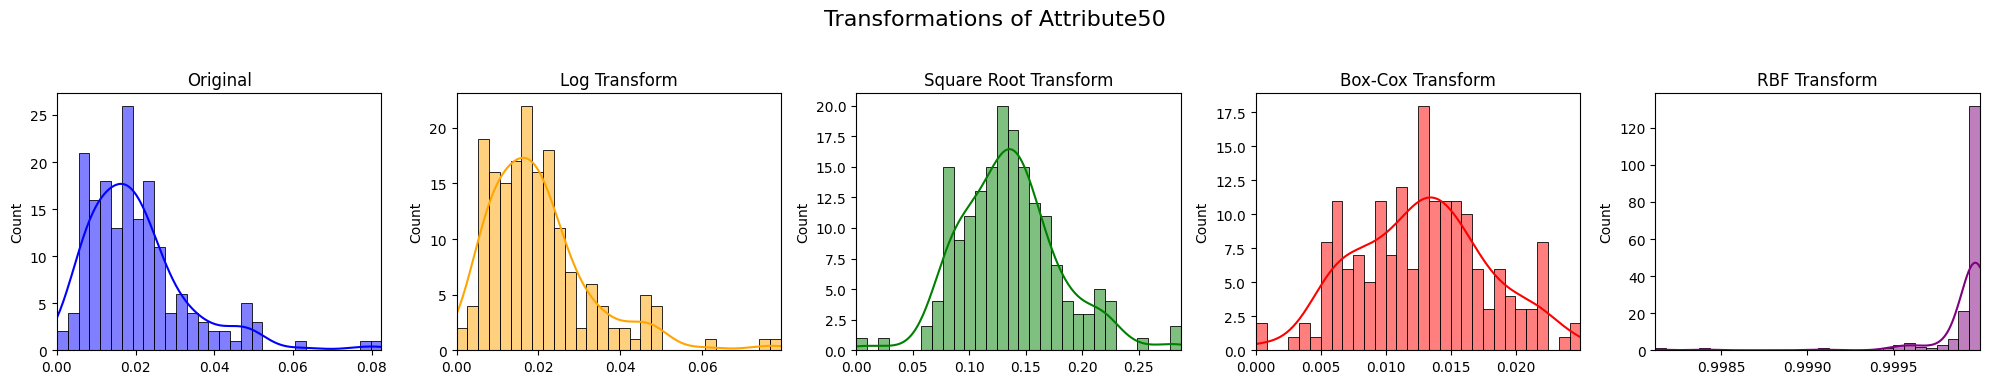

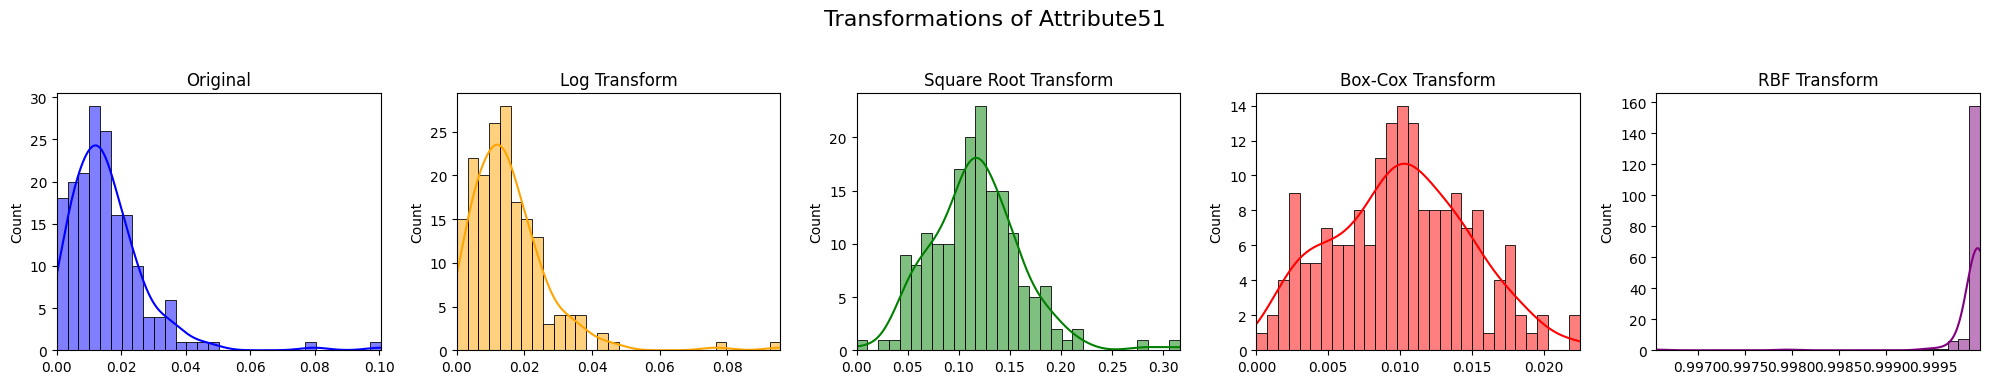

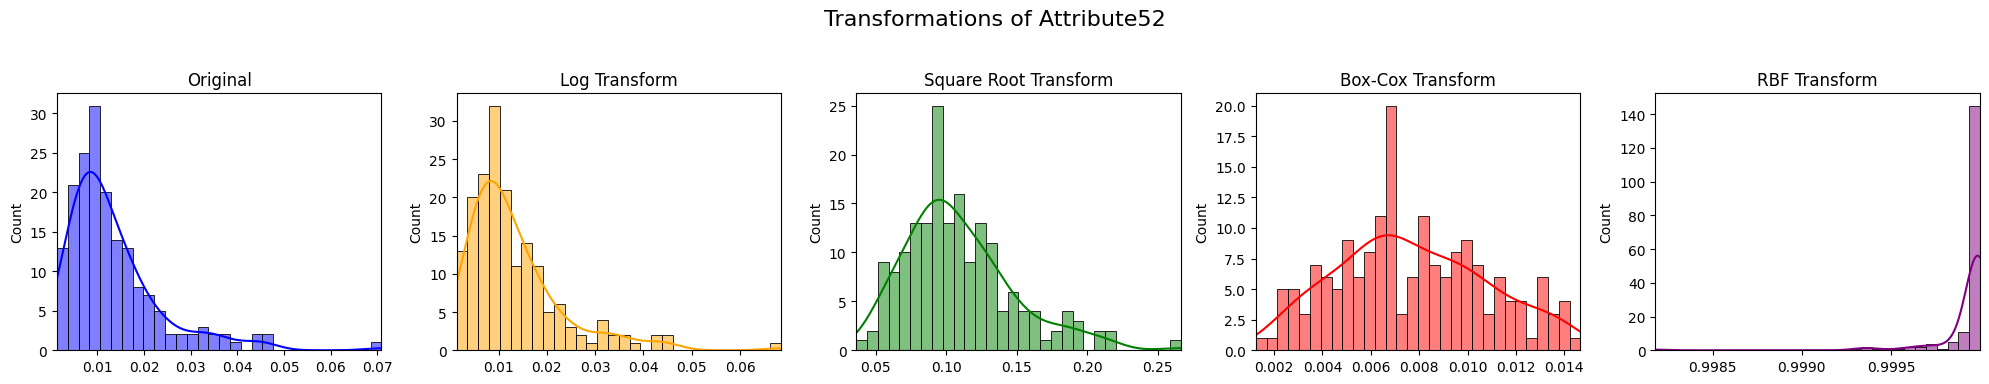

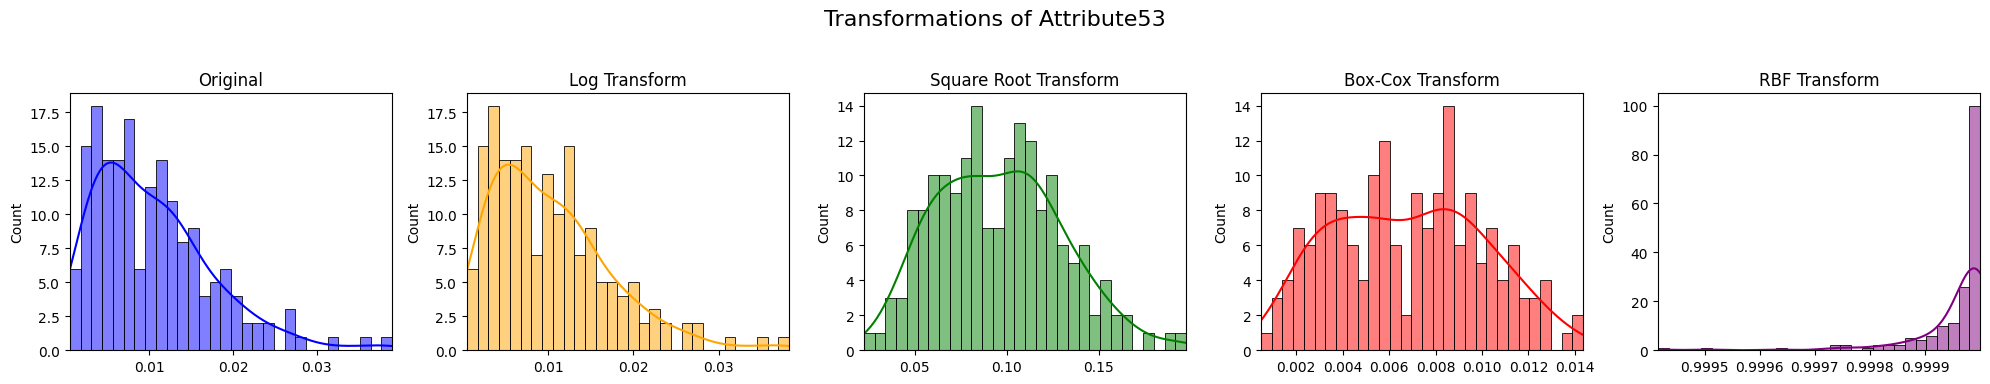

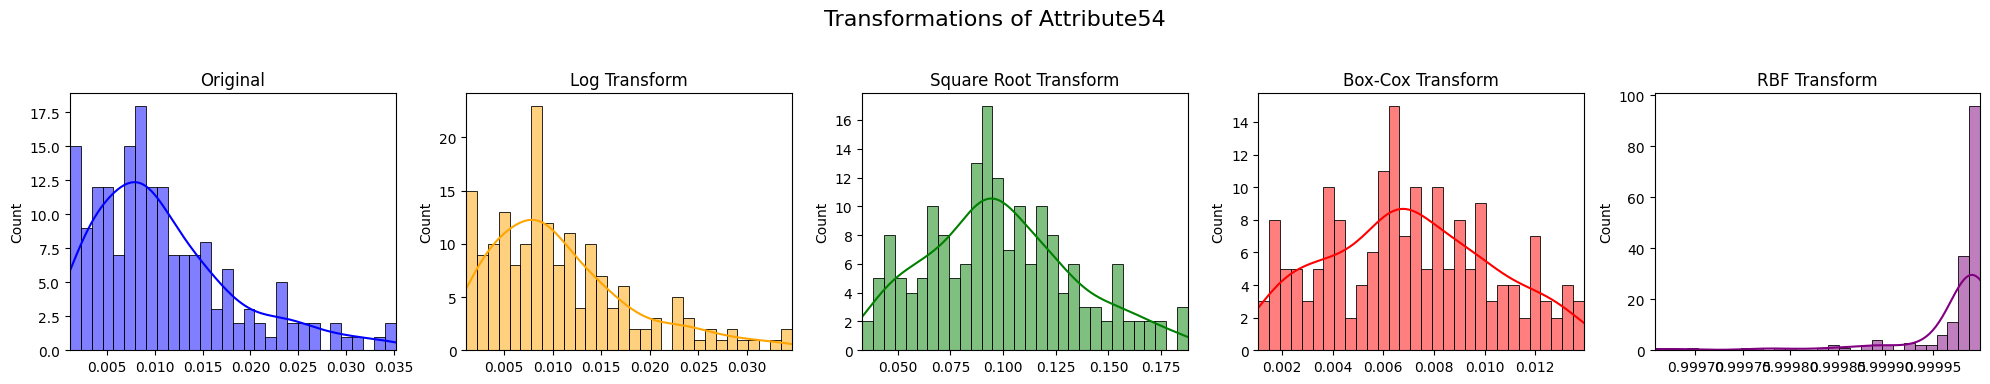

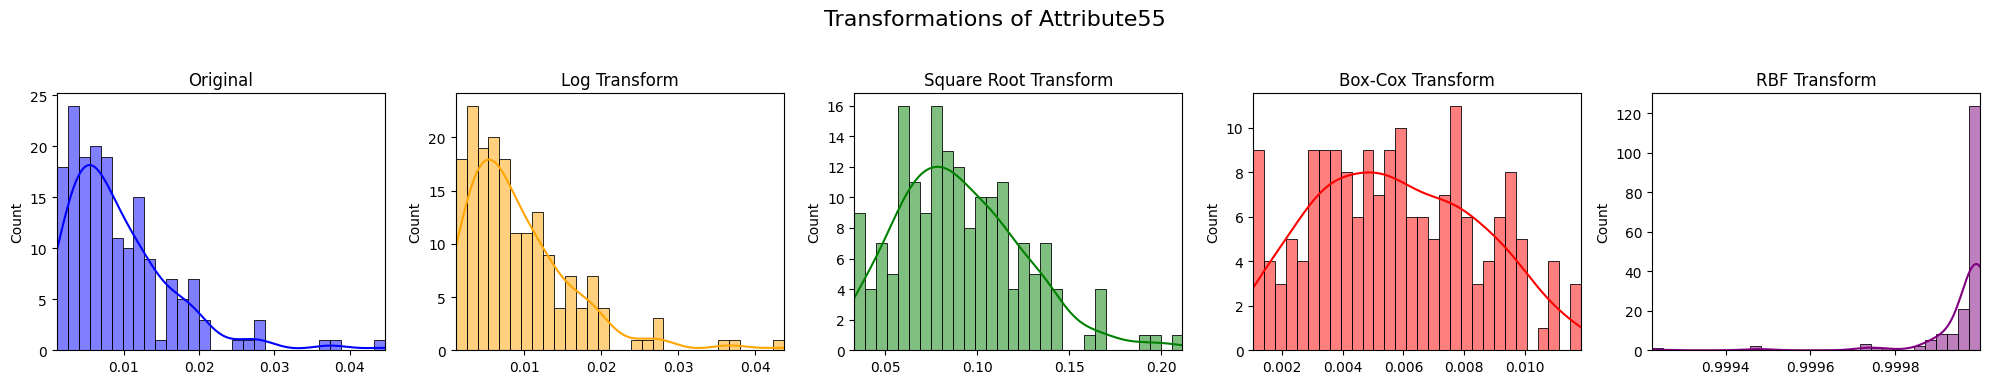

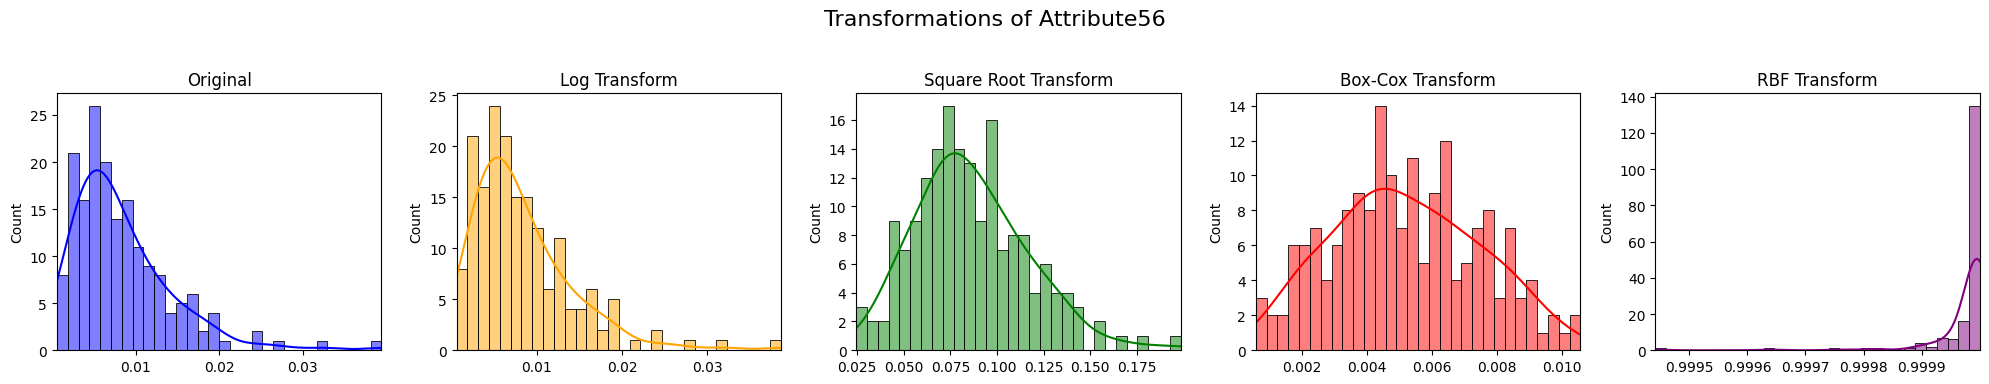

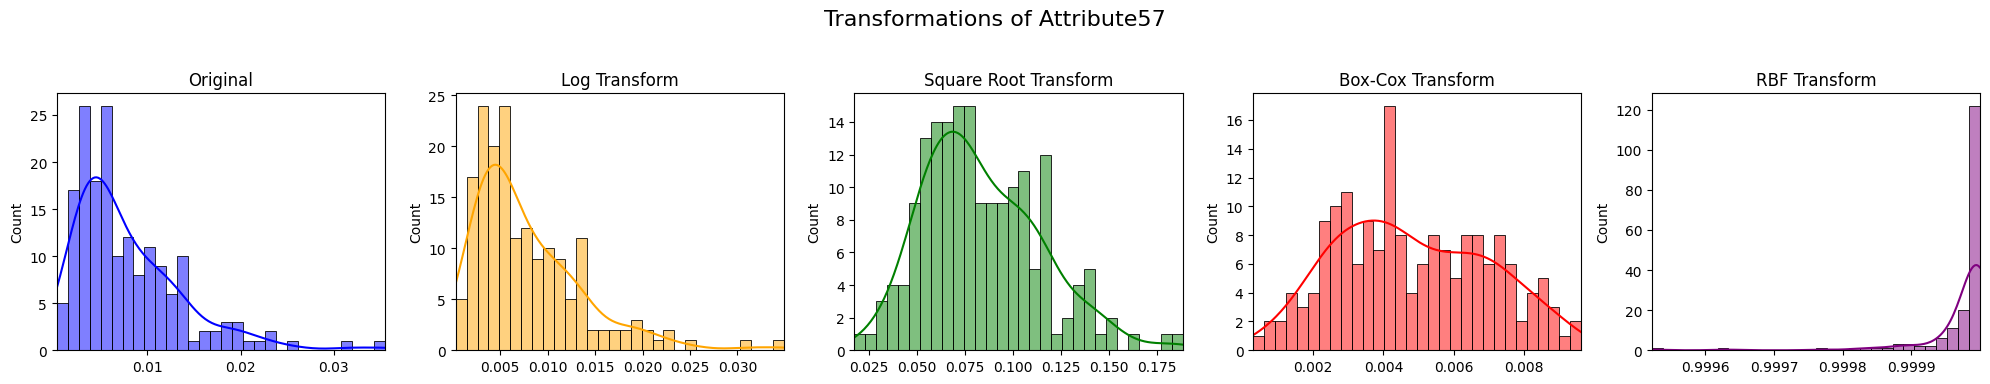

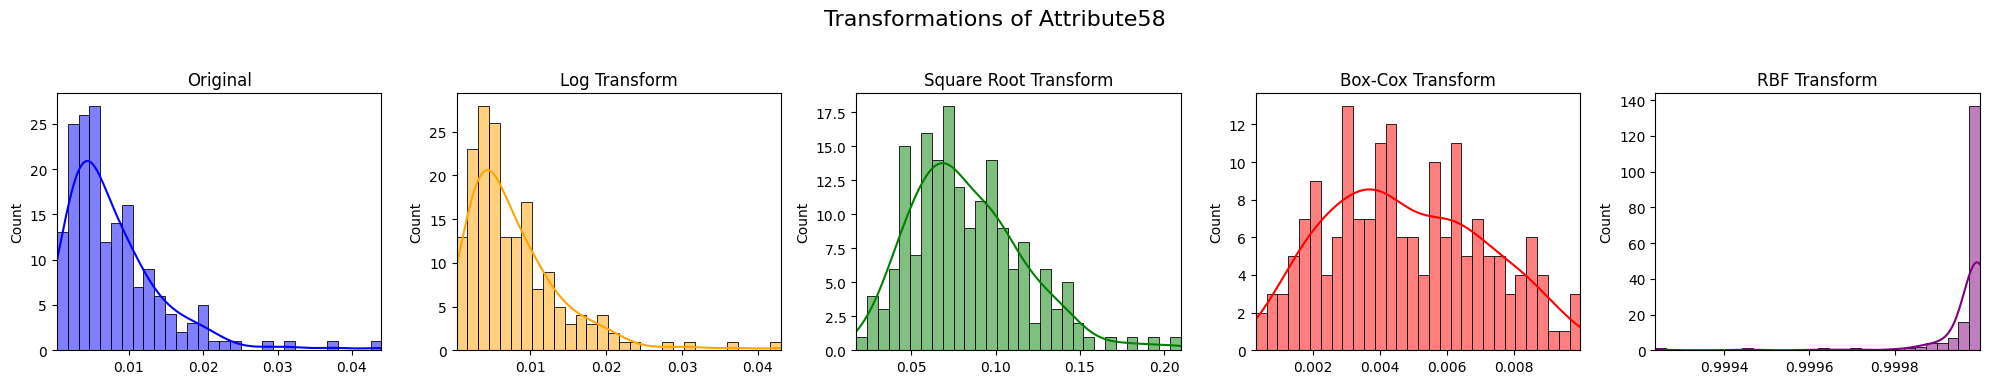

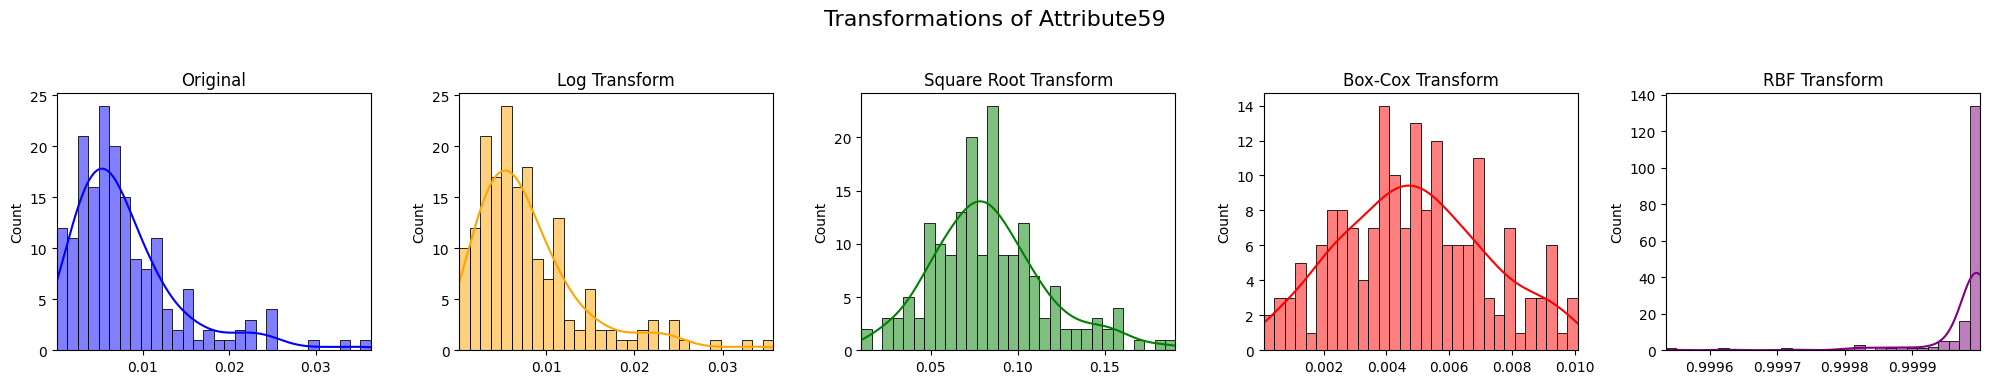

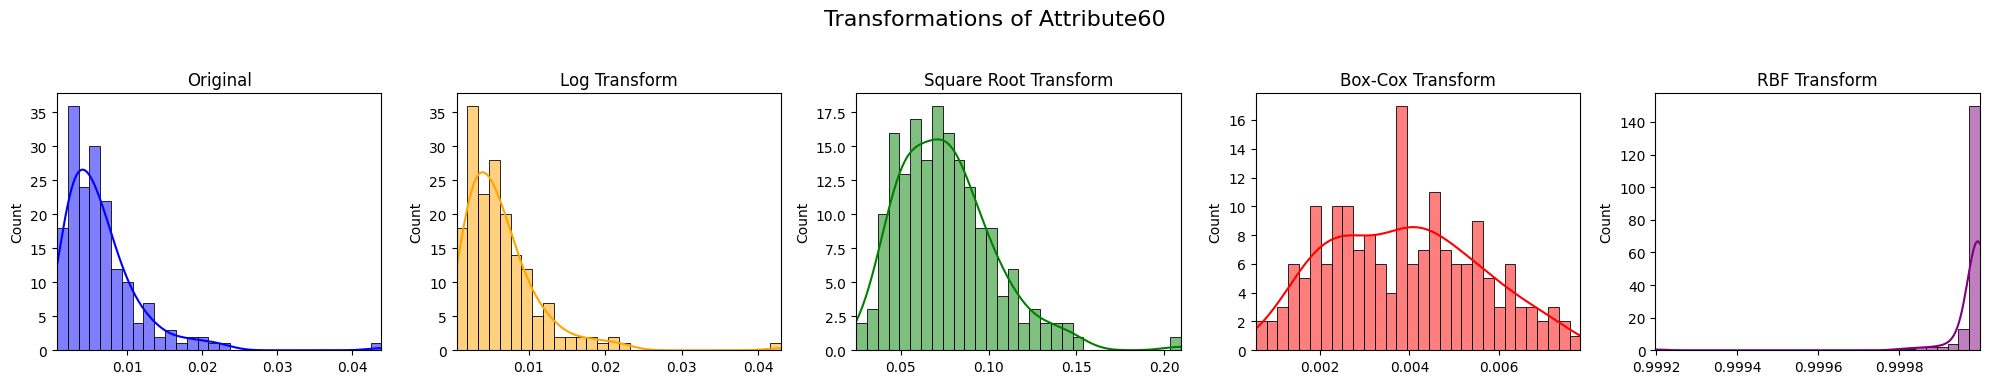

In [ ]:
# Assuming Train_Xy is your DataFrame
# Generate column names programmatically
columns = [f'Attribute{i}' for i in range(1, 61)]
gamma = 0.5  # Define gamma as needed

def apply_transformations(data):
    # Apply multiple transformations to handle different distributions
    log_data = np.log1p(data)
    sqrt_data = np.sqrt(data)
    boxcox_data, _ = boxcox(data + 1)  # Add 1 to avoid zero or negative values
    return log_data, sqrt_data, boxcox_data

for col_name in columns:
    # Get the original data
    original_data = Train_Xy[col_name].values

    # Apply transformations to the column data
    log_data, sqrt_data, boxcox_data = apply_transformations(original_data)

    # Calculate KDE for the log-transformed data
    kde_log = sns.kdeplot(log_data, bw_adjust=0.5).get_lines()[0].get_data()
    plt.close()  # Close the plot to avoid displaying it

    # Identify peaks in the KDE curve with a minimum height
    peaks, properties = find_peaks(kde_log[1], height=0.05)  # Adjust the height threshold as needed

    if len(peaks) > 0:
        # Find the value corresponding to the highest peak
        max_peak_value = kde_log[0][peaks[np.argmax(kde_log[1][peaks])]]

        # Apply RBF kernel transformation using the max peak value
        log_data_reshaped = log_data.reshape(-1, 1)  # Reshape the data for compatibility
        max_peak_value_array = np.array([[max_peak_value]])  # Ensure the peak value is in the correct shape
        rbf_transformed_values = rbf_kernel(log_data_reshaped, max_peak_value_array, gamma=gamma).flatten()
    else:
        rbf_transformed_values = np.zeros_like(log_data)  # If no peaks are found, use zeros

    # Create a 1x5 subplot for the original and transformed data
    fig, axes = plt.subplots(1, 5, figsize=(20, 4))
    fig.suptitle(f'Transformations of {col_name}', fontsize=16)

    # Plot original data
    sns.histplot(original_data, bins=30, kde=True, color='blue', ax=axes[0])
    axes[0].set_title('Original')
    axes[0].set_xlim(min(original_data), max(original_data))

    # Plot log-transformed data
    sns.histplot(log_data, bins=30, kde=True, color='orange', ax=axes[1])
    axes[1].set_title('Log Transform')
    axes[1].set_xlim(min(log_data), max(log_data))

    # Plot square root transformed data
    sns.histplot(sqrt_data, bins=30, kde=True, color='green', ax=axes[2])
    axes[2].set_title('Square Root Transform')
    axes[2].set_xlim(min(sqrt_data), max(sqrt_data))

    # Plot Box-Cox transformed data
    sns.histplot(boxcox_data, bins=30, kde=True, color='red', ax=axes[3])
    axes[3].set_title('Box-Cox Transform')
    axes[3].set_xlim(min(boxcox_data), max(boxcox_data))

    # Plot RBF transformed data
    sns.histplot(rbf_transformed_values, bins=30, kde=True, color='purple', ax=axes[4])
    axes[4].set_title('RBF Transform')
    axes[4].set_xlim(min(rbf_transformed_values), max(rbf_transformed_values))

    # Show the plot
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


**When to Use Square Root Transformation**
The square root transformation is a common technique in data preprocessing used to stabilize variance, make the data more normally distributed, and reduce the skewness of the data. It is particularly useful when dealing with certain types of data distributions. Here are some common scenarios where square root transformation is beneficial:

**1. Reducing Right Skewness:**

When the data has a long tail to the right, the square root transformation can reduce the skewness and make the distribution more symmetric.
This is helpful for algorithms that assume normality or symmetrical data distribution.

**2. Stabilizing Variance:**

When the variance of the data is not constant and increases with the mean, a square root transformation can help stabilize the variance (homoscedasticity).
This is important for regression models and ANOVA, where constant variance is an assumption.

**3. Reducing Impact of Outliers:**

When data contains outliers that disproportionately affect the analysis, the square root transformation can reduce the impact of these extreme values.

## **3. Feature Scaling**

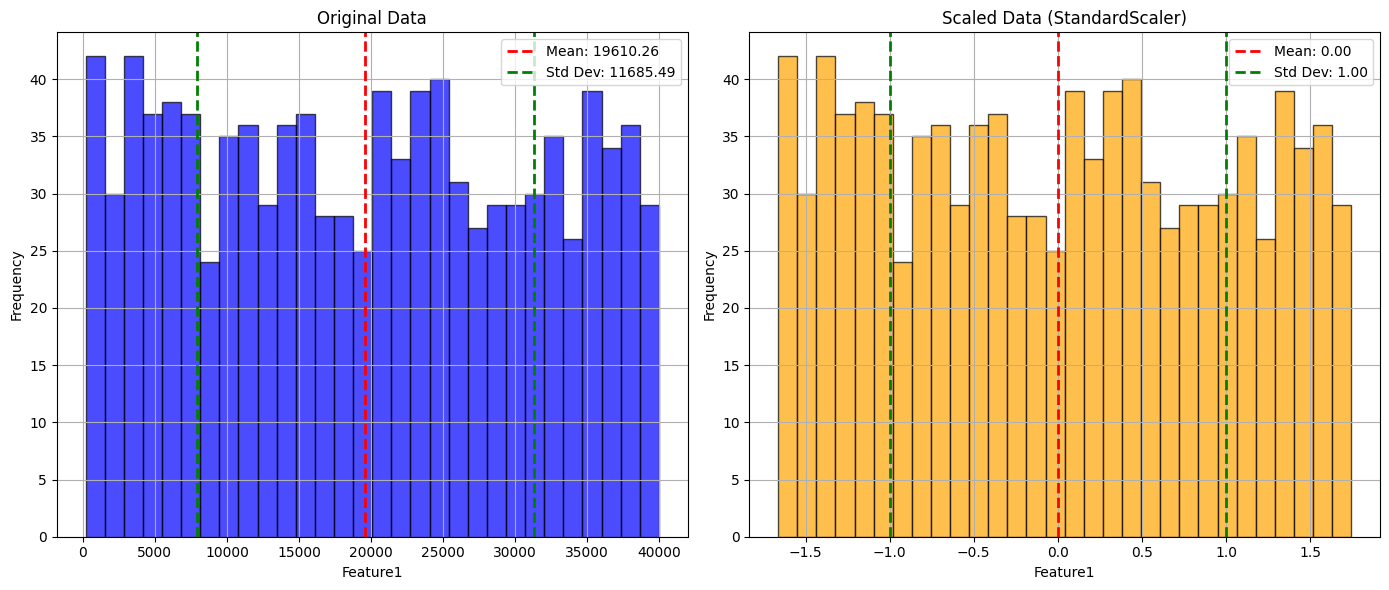

In [ ]:
# Create a dataset with one feature ranging from 0 to 40,000
np.random.seed(42)
data = {
    'Feature1': np.random.uniform(0, 40000, 1000)  # 1000 samples uniformly distributed between 0 and 40,000
}

df = pd.DataFrame(data)

# Apply StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[['Feature1']])

# Create a DataFrame for the scaled data
df_scaled = pd.DataFrame(X_scaled, columns=['Feature1'])

# Plot the original data and scaled data
plt.figure(figsize=(14, 6))

# Original Data
plt.subplot(1, 2, 1)
plt.hist(df['Feature1'], bins=30, color='blue', alpha=0.7, edgecolor='black')
plt.axvline(df['Feature1'].mean(), color='red', linestyle='dashed', linewidth=2, label=f'Mean: {df["Feature1"].mean():.2f}')
plt.axvline(df['Feature1'].mean() + df['Feature1'].std(), color='green', linestyle='dashed', linewidth=2, label=f'Std Dev: {df["Feature1"].std():.2f}')
plt.axvline(df['Feature1'].mean() - df['Feature1'].std(), color='green', linestyle='dashed', linewidth=2)
plt.title('Original Data')
plt.xlabel('Feature1')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)

# Scaled Data
plt.subplot(1, 2, 2)
plt.hist(df_scaled['Feature1'], bins=30, color='orange', alpha=0.7, edgecolor='black')
plt.axvline(df_scaled['Feature1'].mean(), color='red', linestyle='dashed', linewidth=2, label=f'Mean: {df_scaled["Feature1"].mean():.2f}')
plt.axvline(df_scaled['Feature1'].mean() + df_scaled['Feature1'].std(), color='green', linestyle='dashed', linewidth=2, label=f'Std Dev: {df_scaled["Feature1"].std():.2f}')
plt.axvline(df_scaled['Feature1'].mean() - df_scaled['Feature1'].std(), color='green', linestyle='dashed', linewidth=2)
plt.title('Scaled Data (StandardScaler)')
plt.xlabel('Feature1')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


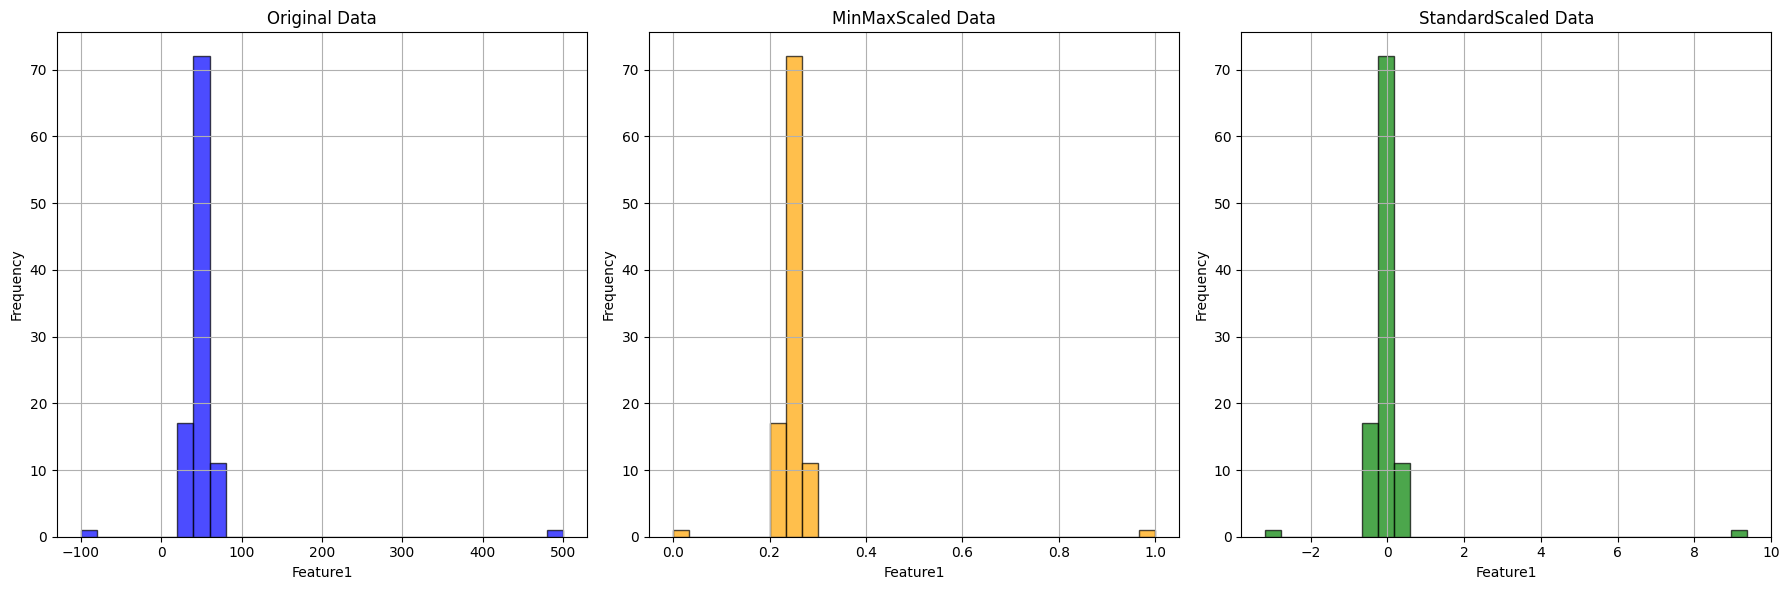

In [ ]:
# Generate a dataset with outliers
np.random.seed(42)
data = {
    'Feature1': np.random.normal(50, 10, 100).tolist() + [500, -100],  # Adding outliers
}

df = pd.DataFrame(data)

# Apply MinMaxScaler
minmax_scaler = MinMaxScaler()
X_minmax_scaled = minmax_scaler.fit_transform(df[['Feature1']])

# Apply StandardScaler
standard_scaler = StandardScaler()
X_standard_scaled = standard_scaler.fit_transform(df[['Feature1']])

# Create DataFrames for the scaled data
df_minmax_scaled = pd.DataFrame(X_minmax_scaled, columns=['Feature1'])
df_standard_scaled = pd.DataFrame(X_standard_scaled, columns=['Feature1'])

# Plot the original data, MinMaxScaled data, and StandardScaled data
plt.figure(figsize=(18, 6))

# Original Data
plt.subplot(1, 3, 1)
plt.hist(df['Feature1'], bins=30, color='blue', alpha=0.7, edgecolor='black')
plt.title('Original Data')
plt.xlabel('Feature1')
plt.ylabel('Frequency')
plt.grid(True)

# MinMaxScaled Data
plt.subplot(1, 3, 2)
plt.hist(df_minmax_scaled['Feature1'], bins=30, color='orange', alpha=0.7, edgecolor='black')
plt.title('MinMaxScaled Data')
plt.xlabel('Feature1')
plt.ylabel('Frequency')
plt.grid(True)

# StandardScaled Data
plt.subplot(1, 3, 3)
plt.hist(df_standard_scaled['Feature1'], bins=30, color='green', alpha=0.7, edgecolor='black')
plt.title('StandardScaled Data')
plt.xlabel('Feature1')
plt.ylabel('Frequency')
plt.grid(True)

plt.tight_layout()
plt.show()


## **4. Feature Encoding**

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

# Sample dataset
data = {
    'City': ['New York', 'Los Angeles', 'New York', 'Chicago', 'Houston', 'Los Angeles', 'Chicago', 'New York', 'New York']
}

# Create a DataFrame
df = pd.DataFrame(data)

# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the 'City' column
df['City_Encoded'] = label_encoder.fit_transform(df['City'])

# Create a DataFrame to show the original and encoded values
comparison_df = df.drop_duplicates().sort_values(by='City_Encoded').reset_index(drop=True)
comparison_df

City  City_Encoded
0      Chicago             0
1      Houston             1
2  Los Angeles             2
3     New York             3

In [ ]:
Train_y.value_counts()

class
M    94
R    82
Name: count, dtype: int64

## **5. Feature Building Pipeline**


In [ ]:
class CustomFeatureCreator(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.feature_names = [f'Sqrt_{feature}' for feature in X.columns]
        return self

    def transform(self, X):
        return np.sqrt(X)

    def get_feature_names_out(self, input_features=None):
        return self.feature_names


# Create the feature engineering pipeline
# Define the custom transformer, scaler, and label encoder

feature_engineering_pipeline = Pipeline([
    ('custom_transformer', CustomFeatureCreator()),
    ('scaler', StandardScaler())
])


# Fit and transform the data using the pipeline & Encode the target variable
Train_X_transformed = feature_engineering_pipeline.fit_transform(Train_X)
Train_y_transformed = LabelEncoder().fit_transform(Train_y)

# Now Train_X_transformed contains the scaled and square root transformed features,
# and Train_y_encoded contains the label encoded target variable.
print("Transformed Features Shape:", Train_X_transformed.shape)
print("Encoded Labels Shape:", Train_y_transformed.shape)


Transformed Features Shape: (176, 60)
Encoded Labels Shape: (176,)


In [ ]:
Train_X_transformed

array([[-0.88786515, -1.73436732, -0.72369165, ..., -0.20797151,
        -0.45604242,  0.31077927],
       [ 0.68106966,  0.35490342,  0.1891668 , ...,  0.13975881,
         2.23695094,  2.35147963],
       [ 0.1924557 ,  0.11900142, -0.64333328, ..., -0.54845473,
        -0.28506193, -1.07867114],
       ...,
       [ 0.48383292,  0.25092468, -0.23744379, ..., -0.03711091,
         0.14672146,  0.24573157],
       [ 0.65598758,  0.95796513,  0.03355756, ...,  0.53709005,
         0.00483536, -0.0543177 ],
       [-0.05043755,  0.38868255,  0.00452665, ...,  1.7391658 ,
         2.3236797 ,  2.11475546]])

In [ ]:
Train_y_transformed

array([1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1,
       1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0,
       1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0,
       1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1,
       0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1])

In [ ]:
# Get transformed feature names
transformed_feature_names = feature_engineering_pipeline.named_steps['custom_transformer'].get_feature_names_out()
transformed_feature_names


['Sqrt_Attribute1',
 'Sqrt_Attribute2',
 'Sqrt_Attribute3',
 'Sqrt_Attribute4',
 'Sqrt_Attribute5',
 'Sqrt_Attribute6',
 'Sqrt_Attribute7',
 'Sqrt_Attribute8',
 'Sqrt_Attribute9',
 'Sqrt_Attribute10',
 'Sqrt_Attribute11',
 'Sqrt_Attribute12',
 'Sqrt_Attribute13',
 'Sqrt_Attribute14',
 'Sqrt_Attribute15',
 'Sqrt_Attribute16',
 'Sqrt_Attribute17',
 'Sqrt_Attribute18',
 'Sqrt_Attribute19',
 'Sqrt_Attribute20',
 'Sqrt_Attribute21',
 'Sqrt_Attribute22',
 'Sqrt_Attribute23',
 'Sqrt_Attribute24',
 'Sqrt_Attribute25',
 'Sqrt_Attribute26',
 'Sqrt_Attribute27',
 'Sqrt_Attribute28',
 'Sqrt_Attribute29',
 'Sqrt_Attribute30',
 'Sqrt_Attribute31',
 'Sqrt_Attribute32',
 'Sqrt_Attribute33',
 'Sqrt_Attribute34',
 'Sqrt_Attribute35',
 'Sqrt_Attribute36',
 'Sqrt_Attribute37',
 'Sqrt_Attribute38',
 'Sqrt_Attribute39',
 'Sqrt_Attribute40',
 'Sqrt_Attribute41',
 'Sqrt_Attribute42',
 'Sqrt_Attribute43',
 'Sqrt_Attribute44',
 'Sqrt_Attribute45',
 'Sqrt_Attribute46',
 'Sqrt_Attribute47',
 'Sqrt_Attribute48',
 

# **Modelling**

## **1.Comparison of 9 Different Models**

In [ ]:
NR_FOLDS = 10

# Setting up models
models = {
    'Naive Bayes': GaussianNB(),
    'Logistic Regression': LogisticRegression(class_weight='balanced', solver='liblinear', max_iter=200),
    'Decision Tree': DecisionTreeClassifier(class_weight='balanced'),
    'Random Forest': RandomForestClassifier(class_weight='balanced'),
    'Gradient Boosting': GradientBoostingClassifier(),
    'XGBoost': XGBClassifier(scale_pos_weight=sum(Train_y_transformed == 0) / sum(Train_y_transformed == 1)),  # XGBoost handles imbalance by scale_pos_weight
    'Extra Trees': ExtraTreesClassifier(class_weight='balanced'),
    'AdaBoost': AdaBoostClassifier(estimator=DecisionTreeClassifier(class_weight='balanced')),
    'BaggingClassifier': BaggingClassifier(estimator=ExtraTreeClassifier(), n_estimators=100)
}

# Scorer for cross-validation: Area Under Precision-Recall Curve (AUPRC)
auprc_scorer = make_scorer(average_precision_score,
                           needs_proba=True)

# Perform cross-validation and store results
results = {}
skf = StratifiedKFold(n_splits = NR_FOLDS,
                     shuffle = True,
                     random_state = RANDOM_STATE)

for name, model in models.items():
    scores = cross_val_score(model,
                             Train_X_transformed,
                             Train_y_transformed,
                             cv = skf,
                             scoring = auprc_scorer)
    results[name] = np.mean(scores)
    print(f"{name}: Mean AUPRC = {results[name]:.4f}")

# Comparing models
best_model = max(results, key=results.get)
print(f"Best model based on AUPRC: {best_model} with an AUPRC of {results[best_model]:.4f}")


Naive Bayes: Mean AUPRC = 0.8248
Logistic Regression: Mean AUPRC = 0.8426
Decision Tree: Mean AUPRC = 0.6596
Random Forest: Mean AUPRC = 0.9071
Gradient Boosting: Mean AUPRC = 0.9124
XGBoost: Mean AUPRC = 0.9162
Extra Trees: Mean AUPRC = 0.9240
AdaBoost: Mean AUPRC = 0.6539
BaggingClassifier: Mean AUPRC = 0.9286
Best model based on AUPRC: BaggingClassifier with an AUPRC of 0.9286


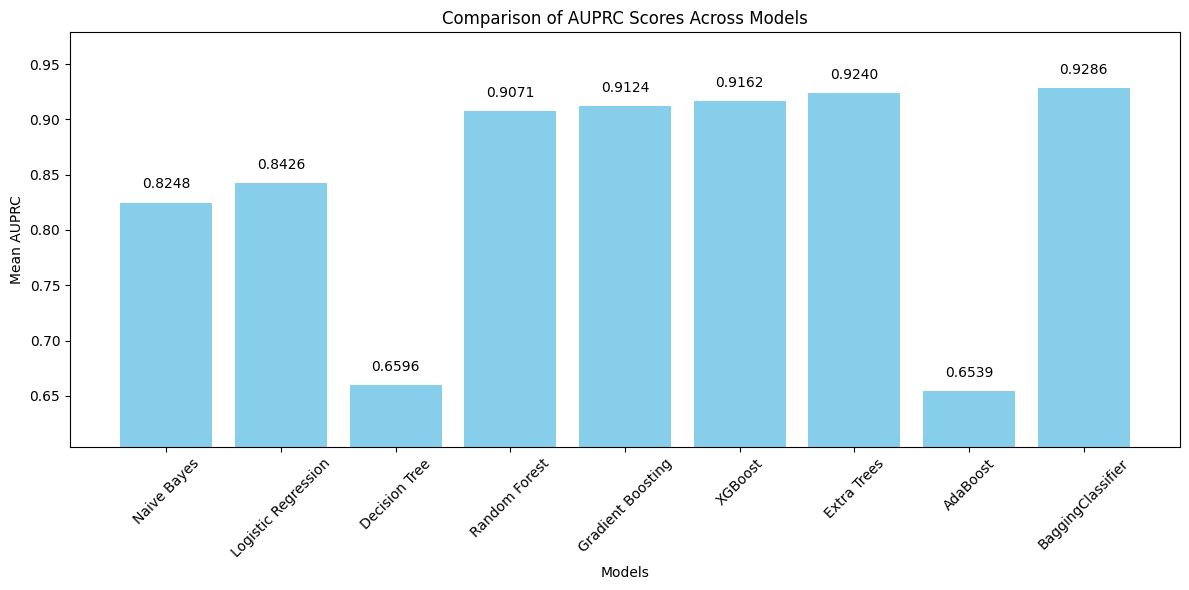

In [ ]:
# Names of the models
model_names = list(results.keys())
# AUPRC scores
auprc_scores = [results[name] for name in model_names]

# Creating the bar plot
plt.figure(figsize=(12, 6))
plt.bar(model_names, auprc_scores, color='skyblue')
plt.xlabel('Models')
plt.ylabel('Mean AUPRC')
plt.title('Comparison of AUPRC Scores Across Models')
plt.xticks(rotation=45)
plt.ylim([min(auprc_scores) - 0.05, max(auprc_scores) + 0.05])  # Set y-axis limits to give some padding

# Adding the score above each bar
for i, v in enumerate(auprc_scores):
    plt.text(i, v + 0.01, f"{v:.4f}", ha='center', va='bottom')

plt.tight_layout()
plt.show()


**Logistic Regression solver liblinear:**

* This solver uses a coordinate descent algorithm, which is particularly effective for small to medium-sized datasets.

* Regularization: Supports both L1 (Lasso) and L2 (Ridge) regularization.
* Convergence: Generally converges well for smaller datasets but may struggle with larger datasets or those with many features.
* Parallelization: Does not support parallel computation, which can make it slower for large datasets.
* Suitability: Best for smaller datasets where interpretability of the model coefficients (especially with L1 regularization) is important.

**Logistic Regression solver saga:**

* This solver uses a stochastic average gradient descent algorithm, which is suitable for large-scale datasets and handles both dense and sparse data efficiently.
* Regularization: Supports L1, L2, and elastic-net regularization. Elastic-net is a combination of L1 and L2, which can be useful for feature selection and model stability.
* Convergence: More robust to convergence issues in larger datasets and higher-dimensional spaces due to its stochastic nature.
* Parallelization: Supports parallel computation, making it faster for large datasets.
* Suitability: Best for large datasets and high-dimensional feature spaces, particularly when different types of regularization are required.

In [ ]:
NR_FOLDS = 10

# Scorer for cross-validation: Area Under Precision-Recall Curve (AUPRC)
auprc_scorer = make_scorer(average_precision_score,
                           needs_proba=True)

# Setup cross-validation
skf = StratifiedKFold(n_splits=NR_FOLDS,
                      shuffle=True,
                      random_state=RANDOM_STATE)

# Define parameter grid for Decision Tree
param_grid_dt = {
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'class_weight': ['balanced']
}

# Define parameter grid for AdaBoost
param_grid_ab = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 1],
    'estimator__max_depth': [None, 10, 20],
    'estimator__min_samples_split': [2, 5],
    'estimator__min_samples_leaf': [1, 2],
    'estimator__class_weight': ['balanced']
}

# Create a GridSearchCV object for Decision Tree
grid_search_dt = GridSearchCV(DecisionTreeClassifier(),
                              param_grid_dt,
                              cv=skf,
                              scoring=auprc_scorer)
grid_search_dt.fit(Train_X_transformed, Train_y_transformed)

# Create a GridSearchCV object for AdaBoost
base_estimator = DecisionTreeClassifier()
ada_boost = AdaBoostClassifier(estimator=base_estimator)
grid_search_ab = GridSearchCV(ada_boost,
                              param_grid_ab,
                              cv=skf,
                              scoring=auprc_scorer)
grid_search_ab.fit(Train_X_transformed, Train_y_transformed)

# Print best parameters and best AUPRC score for each model
print("Best parameters for Decision Tree:", grid_search_dt.best_params_)
print("Best AUPRC score for Decision Tree:", grid_search_dt.best_score_)

print("Best parameters for AdaBoost:", grid_search_ab.best_params_)
print("Best AUPRC score for AdaBoost:", grid_search_ab.best_score_)


Best parameters for Decision Tree: {'class_weight': 'balanced', 'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 5}
Best AUPRC score for Decision Tree: 0.7585227508511823
Best parameters for AdaBoost: {'estimator__class_weight': 'balanced', 'estimator__max_depth': None, 'estimator__min_samples_leaf': 2, 'estimator__min_samples_split': 2, 'learning_rate': 0.1, 'n_estimators': 200}
Best AUPRC score for AdaBoost: 0.9413512760387761


## **2. Model Evaluation**

In [ ]:
# Dictionary to store precision and recall values for each model
precision_recall_data = {}

# Setup cross-validation
skf = StratifiedKFold(n_splits=NR_FOLDS, shuffle=True, random_state=RANDOM_STATE)

for name, model in models.items():
    model_precisions = []
    model_recalls = []
    model_thresholds = []
    for train_index, val_index in skf.split(Train_X_transformed, Train_y_transformed):
        X_train, X_val = Train_X_transformed[train_index], Train_X_transformed[val_index]
        y_train, y_val = Train_y_transformed[train_index], Train_y_transformed[val_index]

        cloned_model = clone(model)
        cloned_model.fit(X_train, y_train)
        y_scores = cloned_model.predict_proba(X_val)[:, 1]

        precision, recall, thresholds = precision_recall_curve(y_val, y_scores)
        model_precisions.append(precision)
        model_recalls.append(recall)
        model_thresholds.append(thresholds)

    # Average precision and recall over folds
    mean_precision = np.mean([np.interp(np.linspace(0, 1, 100), np.sort(r), p[np.argsort(r)]) for p, r in zip(model_precisions, model_recalls)], axis=0)
    mean_recall = np.linspace(0, 1, 100)
    precision_recall_data[name] = (mean_precision, mean_recall)

# Compute AUC PR for each model
from sklearn.metrics import auc
model_auc_pr = {name: auc(recall, precision) for name, (precision, recall) in precision_recall_data.items()}


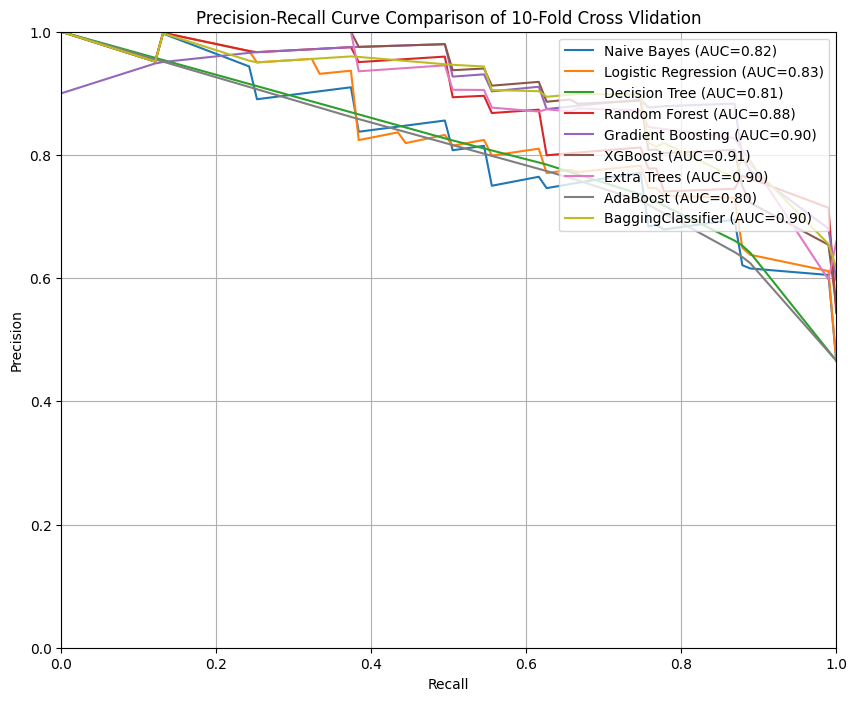

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
for name, (precision, recall) in precision_recall_data.items():
    plt.plot(recall, precision, label=f'{name} (AUC={model_auc_pr[name]:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve Comparison of 10-Fold Cross Vlidation')
plt.legend(loc='upper right')
plt.grid(True)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.show()


The zigzag nature of your Precision-Recall (PR) curve can be caused by several factors, including the inherent variability in the model's predictions and the averaging process over multiple folds.

Here are some potential reasons and suggestions to address the issue:

* Small Sample Size: If your dataset is small, the variability in the folds can cause fluctuations in the PR curve.
* Threshold Selection: The precision_recall_curve function computes precision and recall for different thresholds, and the interpolation method might introduce zigzags.
* Interpolation Artifacts: Interpolating precision values over a fixed range of recall values can introduce artifacts, especially if there are few data points.

Suggestions to Improve the PR Curve Smoothness

* Increase the Number of Folds: Increasing the number of folds in cross-validation can provide more data points for averaging, which can smooth out the curve.

* Smoothing the Curve: Applying a smoothing function to the PR curve can help reduce zigzag patterns.

* More Data Points: Ensure that you have enough data points for interpolation.

* Alternative Averaging Method: Instead of interpolating, you can average the precision and recall values directly, though this might require handling cases where the lengths of the precision and recall arrays differ.

### **Improved AUC PR Plot with Smoothing**

**Savitzky-Golay filter** is a type of digital filter that is used to smooth data by fitting successive polynomials to a series of data points.

It is particularly useful for reducing noise while maintaining the shape and features of the original signal.

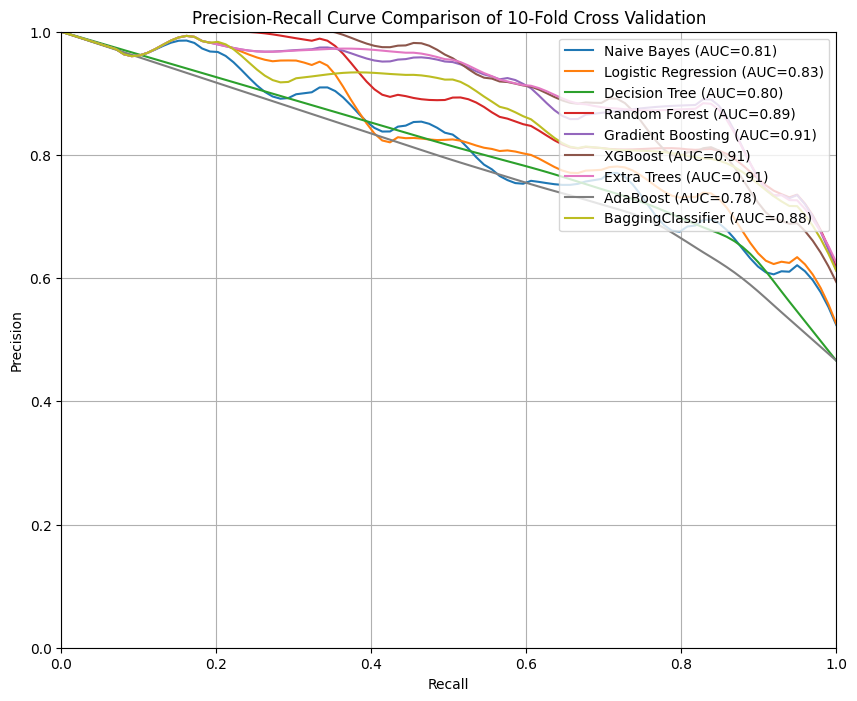

In [ ]:
# Dictionary to store precision and recall values for each model
precision_recall_data = {}

# Setup cross-validation
NR_FOLDS = 10  # You can adjust this as needed


skf = StratifiedKFold(n_splits=NR_FOLDS, shuffle=True, random_state=RANDOM_STATE)

for name, model in models.items():
    model_precisions = []
    model_recalls = []
    model_thresholds = []
    for train_index, val_index in skf.split(Train_X_transformed, Train_y_transformed):
        X_train, X_val = Train_X_transformed[train_index], Train_X_transformed[val_index]
        y_train, y_val = Train_y_transformed[train_index], Train_y_transformed[val_index]

        cloned_model = clone(model)
        cloned_model.fit(X_train, y_train)
        y_scores = cloned_model.predict_proba(X_val)[:, 1]

        precision, recall, thresholds = precision_recall_curve(y_val, y_scores)
        model_precisions.append(precision)
        model_recalls.append(recall)
        model_thresholds.append(thresholds)

    # Average precision and recall over folds
    mean_precision = np.mean([np.interp(np.linspace(0, 1, 100), np.sort(r), p[np.argsort(r)]) for p, r in zip(model_precisions, model_recalls)], axis=0)
    mean_recall = np.linspace(0, 1, 100)

    # Apply smoothing to the mean precision
    # Adjust window_length and polyorder as needed
    smoothed_precision = savgol_filter(mean_precision, window_length=11, polyorder=2)

    precision_recall_data[name] = (smoothed_precision, mean_recall)

# Compute AUC PR for each model
model_auc_pr = {name: auc(recall, precision) for name, (precision, recall) in precision_recall_data.items()}

# Plot the Precision-Recall curves
plt.figure(figsize=(10, 8))
for name, (precision, recall) in precision_recall_data.items():
    plt.plot(recall, precision, label=f'{name} (AUC={model_auc_pr[name]:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve Comparison of 10-Fold Cross Validation')
plt.legend(loc='upper right')
plt.grid(True)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.show()


## **3. Model Selection**

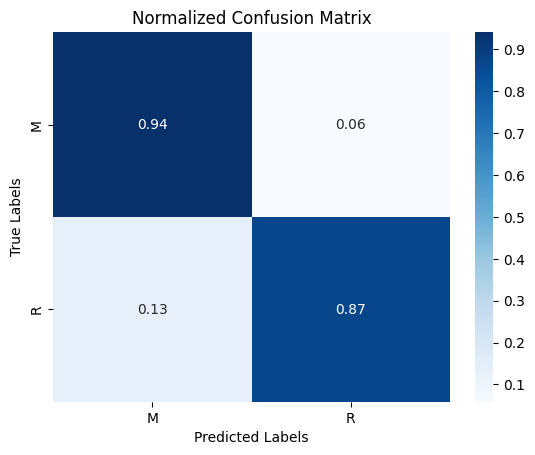

In [ ]:
# Fit the best model to the entire training data
best_model = XGBClassifier(scale_pos_weight=sum(Train_y_transformed == 0) / sum(Train_y_transformed == 1))
best_model.fit(Train_X_transformed, Train_y_transformed)

# Transform the test data
Test_X_transformed = feature_engineering_pipeline.transform(Test_X)
Test_y_transformed = LabelEncoder().fit_transform(Test_y)

# Predictions
y_pred = best_model.predict(Test_X_transformed)
y_proba = best_model.predict_proba(Test_X_transformed)

TARGET_NAMES = LabelEncoder().fit(Train_y).classes_
#print(classification_report(Test_y_transformed, y_pred, target_names=TARGET_NAMES))

# Plot confusion matrix
# Plot normalized confusion matrix
cm = confusion_matrix(Test_y_transformed, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=TARGET_NAMES, yticklabels=TARGET_NAMES)
plt.title('Normalized Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

## **4. Model Fine Tunning**

In [ ]:
NR_FOLDS = 5

# Define the parameter space for Hyperopt
param_space = {
    'max_depth': hp.quniform('max_depth', 3, 15, 1),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.3),
    'n_estimators': hp.quniform('n_estimators', 50, 300, 10),
    'gamma': hp.uniform('gamma', 0, 0.5),
    'min_child_weight': hp.quniform('min_child_weight', 1, 10, 1),
    'subsample': hp.uniform('subsample', 0.6, 1),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.6, 1),
    'scale_pos_weight': hp.uniform('scale_pos_weight', 0.1, 2)
}

# Define the objective function for Hyperopt
def objective(params):
    params['max_depth'] = int(params['max_depth'])
    params['n_estimators'] = int(params['n_estimators'])
    model = XGBClassifier(**params,
                          use_label_encoder=False,
                          eval_metric='logloss')

    # Cross-validation
    skf = StratifiedKFold(n_splits=NR_FOLDS,
                          shuffle=True,
                          random_state=RANDOM_STATE)
    scores = cross_val_score(model,
                             Train_X_transformed,
                             Train_y_transformed,
                             cv=skf,
                             scoring='average_precision')
    return {'loss': -scores.mean(), 'status': STATUS_OK}

# Run Hyperopt optimization
# tpe = Tree-structured Parzen estimator (TPE), a Bayesian optimization method
# which will build models to propose new points based on the historical observed trials.
trials = Trials()
best_params = fmin(fn=objective,
                   space=param_space,
                   algo=tpe.suggest,
                   max_evals=50,
                   trials=trials,
                   rstate=np.random.default_rng(42))

# Convert hyperopt parameters to the proper types
best_params['max_depth'] = int(best_params['max_depth'])
best_params['n_estimators'] = int(best_params['n_estimators'])

print("Best parameters found by Hyperopt:", best_params)

100%|██████████| 50/50 [00:38<00:00,  1.31trial/s, best loss: -0.9303837158969669]
Best parameters found by Hyperopt: {'colsample_bytree': 0.8987630460504965, 'gamma': 0.49318297662296384, 'learning_rate': 0.08994815994413279, 'max_depth': 8, 'min_child_weight': 2.0, 'n_estimators': 220, 'scale_pos_weight': 1.893834741459248, 'subsample': 0.9952686714394833}


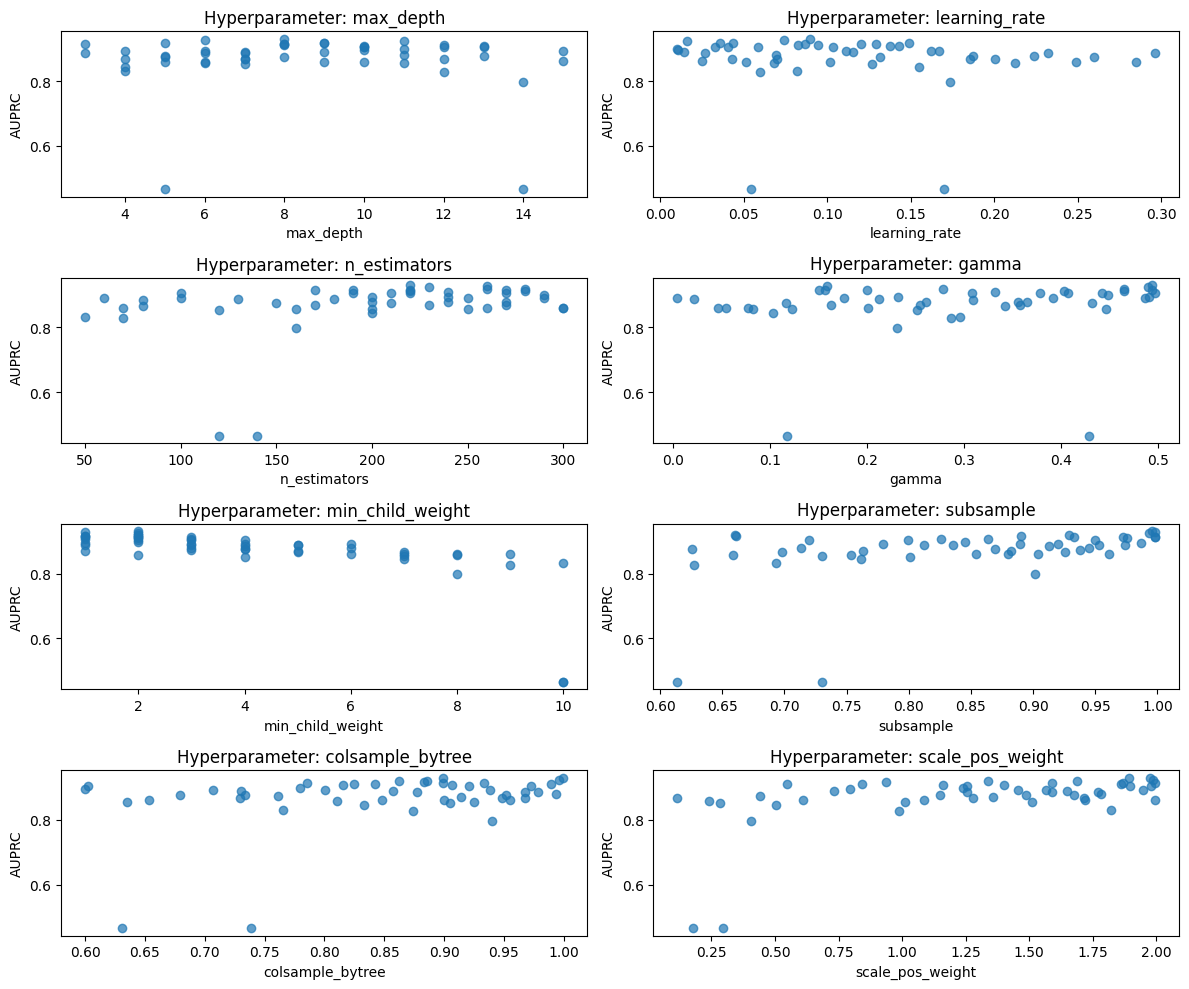

In [ ]:
# Extract information from trials
results = []
for trial in trials.trials:
    result = trial['result']
    vals = trial['misc']['vals']
    for key, value in vals.items():
        if isinstance(value, list) and len(value) == 1:
            vals[key] = value[0]
    result.update(vals)
    results.append(result)

# Create a DataFrame for visualization
results_df = pd.DataFrame(results)
results_df['loss'] = -results_df['loss']  # Convert loss to positive for visualization

# Plot the hyperparameter tuning process
plt.figure(figsize=(12, 10))

# Plot each hyperparameter against the loss
for i, column in enumerate(param_space.keys()):
    plt.subplot(4, 2, i + 1)
    plt.scatter(results_df[column], results_df['loss'], alpha=0.7)
    plt.xlabel(column)
    plt.ylabel('AUPRC')
    plt.title(f'Hyperparameter: {column}')

plt.tight_layout()
plt.show()

* **min_child_weight:** in XGBoost is a regularization parameter that specifies the minimum sum of instance weight (also known as the hessian, a measure of the second-order derivative of the loss function) needed in a child node. It is used to control overfitting by preventing the model from creating overly complex trees with nodes that have too few data points.

* **gamma:** Regularization parameter to control the minimum loss reduction required to make a split in a leaf node.


In [ ]:
pd.DataFrame([best_params]).T.rename(columns={0: 'Best_Params'})

Best_Params
colsample_bytree     0.898763
gamma                0.493183
learning_rate        0.089948
max_depth            8.000000
min_child_weight     2.000000
n_estimators       220.000000
scale_pos_weight     1.893835
subsample            0.995269

## **5. Build Final Model**

In [ ]:
# Convert hyperopt parameters to the proper types
best_params['max_depth'] = int(best_params['max_depth'])
best_params['n_estimators'] = int(best_params['n_estimators'])

print("Best parameters found by Hyperopt:", best_params)

# Train the best XGBoost model with the optimized hyperparameters
best_model = XGBClassifier(**best_params, use_label_encoder=False, eval_metric='logloss')

best_model.fit(Train_X_transformed, Train_y_transformed)

Best parameters found by Hyperopt: {'colsample_bytree': 0.8987630460504965, 'gamma': 0.49318297662296384, 'learning_rate': 0.08994815994413279, 'max_depth': 8, 'min_child_weight': 2.0, 'n_estimators': 220, 'scale_pos_weight': 1.893834741459248, 'subsample': 0.9952686714394833}


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8987630460504965, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', feature_types=None,
              gamma=0.49318297662296384, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.08994815994413279,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=2.0, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=220, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

## **6. Test Final Model**

Best parameters found by Hyperopt: {'colsample_bytree': 0.8987630460504965, 'gamma': 0.49318297662296384, 'learning_rate': 0.08994815994413279, 'max_depth': 8, 'min_child_weight': 2.0, 'n_estimators': 220, 'scale_pos_weight': 1.893834741459248, 'subsample': 0.9952686714394833}


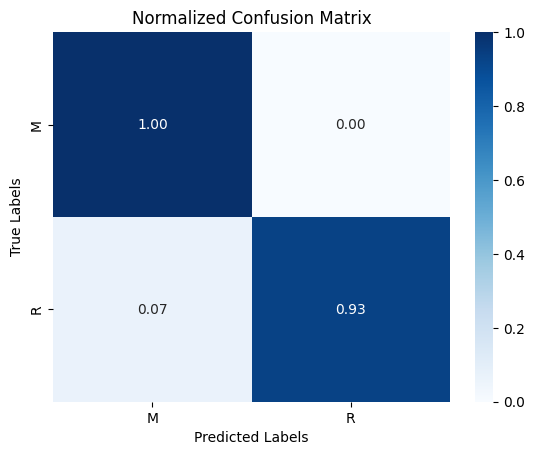

In [ ]:
# Transform the test data
Test_X_transformed = feature_engineering_pipeline.transform(Test_X)
Test_y_transformed = LabelEncoder().fit_transform(Test_y)

# Predictions
y_pred = best_model.predict(Test_X_transformed)
y_proba = best_model.predict_proba(Test_X_transformed)

TARGET_NAMES = LabelEncoder().fit(Train_y).classes_
#print(classification_report(Test_y_transformed, y_pred, target_names=TARGET_NAMES))

# Plot confusion matrix
# Plot normalized confusion matrix
cm = confusion_matrix(Test_y_transformed, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=TARGET_NAMES, yticklabels=TARGET_NAMES)
plt.title('Normalized Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [ ]:
# Select 10 random samples from the test data
random_indices = np.random.choice(len(Test_X_transformed), size=10, replace=False)
random_samples = Test_X_transformed[random_indices]
random_labels = Test_y_transformed[random_indices]

# Predictions
random_predictions = best_model.predict(random_samples)

# Create a DataFrame to show the original and predicted labels
prediction_comparison = pd.DataFrame({
    'Original Label': random_labels,
    'Predicted Label': random_predictions
})

# If you need to inverse transform the labels for better readability
label_encoder = LabelEncoder().fit(Train_y)

# Calculate TP, FP, FN, and TN for each comparison
def label_comparison(row):
    if row['Original Label'] == row['Predicted Label'] == 1:
        return 'TP'
    elif row['Original Label'] == row['Predicted Label'] == 0:
        return 'TN'
    elif row['Original Label'] == 0 and row['Predicted Label'] == 1:
        return 'FP'
    elif row['Original Label'] == 1 and row['Predicted Label'] == 0:
        return 'FN'

prediction_comparison['Comparison'] = prediction_comparison.apply(label_comparison, axis=1)
prediction_comparison['Original Label'] = label_encoder.inverse_transform(prediction_comparison['Original Label'])
prediction_comparison['Predicted Label'] = label_encoder.inverse_transform(prediction_comparison['Predicted Label'])


prediction_comparison

Original Label Predicted Label Comparison
0              M               M         TN
1              M               M         TN
2              M               M         TN
3              M               M         TN
4              R               M         FN
5              R               R         TP
6              R               R         TP
7              M               M         TN
8              R               R         TP
9              M               M         TN